Looking for flares in all the STIS data.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from matplotlib import cm
from scipy import interpolate
from astropy.convolution import convolve, Box1DKernel, convolve_fft, Gaussian1DKernel
import matplotlib.patches as mpatches
from astropy.modeling import models, fitting
from astropy.units import cds
cds.enable()

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [15]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/'

In [100]:
tags = glob.glob('{}*tag.fits'.format(path))

In [70]:
g140ms = []
g140m_stars = []
e140ms = []
e140m_stars = []
g140ls = []
g140l_stars = []
g230ls = []
g230l_stars = []
for tag in tags:
    grating = fits.getheader(tag, 0)['OPT_ELEM']
    star = fits.getheader(tag, 0)['TARGNAME']
    if grating == 'E140M':
        e140ms.append(tag)
        e140m_stars.append(star)
    elif grating == 'G140M':
        g140ms.append(tag)
        g140m_stars.append(star)
    elif grating == 'G140L':
        g140ls.append(tag)
        g140l_stars.append(star)
    elif grating == 'G230L':
        g230ls.append(tag)
        g230l_stars.append(star)
        
    else:
        print ('Unknown grating: {}'.format(grating))

g140m_stars = np.unique(g140m_stars)
g140l_stars = np.unique(g140l_stars)
e140m_stars = np.unique(e140m_stars)


In [13]:
outpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/'

In [9]:
import stistools


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [118]:
t_bin = 20 #in seconds
grating = 'e140m'

use_tags = []
stars = []

for tag in tags:
    grating_i = fits.getheader(tag, 0)['OPT_ELEM']
    star = fits.getheader(tag, 0)['TARGNAME']
    if grating_i.lower() == grating:
        use_tags.append(tag)
        stars.append(star)

stars = np.unique(stars)
print(stars)

['GJ15A' 'GJ729']


In [119]:

for tag in use_tags:
    print(tag)
    rootname = fits.getheader(tag)['ROOTNAME'] #find the rootname of the tagfile to name the output file
    exptime = fits.getheader(tag)['TEXPTIME']
    n_bins = int(exptime/t_bin) #use the exposure time to tell inttag how many time bins there will be
    print('n_bins = {}'.format(n_bins) )
    outfile = '{}{}/{}_{}s_raw.fits'.format(outpath, grating, rootname, t_bin) #build the file path and file name of the output
    if os.path.exists(outfile) == False:
        # os.remove(outfile)
        stistools.inttag.inttag(tag, outfile, rcount = n_bins, increment = t_bin, verbose=False) #change verbose to true to diagnose problems

/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm08030_tag.fits
n_bins = 40
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm08040_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm08050_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm08060_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm09030_tag.fits
n_bins = 40
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm09040_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm09050_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm09060_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm37030_tag.fits
n_bins = 37
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm37040_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/o

In [120]:
os.environ['oref'] = path 

In [121]:
raws = glob.glob('{}{}/*raw.fits'.format(outpath, grating))
raws

['/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm08030_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm08040_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm08050_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm08060_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm09030_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm09040_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm09050_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm09060_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm37030_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm37040_20s_raw.fits',
 '/media/david/2tb_ext_hd/hdda

In [122]:
for raw in raws:
    rootname = fits.getheader(raw)['ROOTNAME'] 
    outname = '{}{}/{}_{}s'.format(outpath, grating, rootname, t_bin) #build the file path and file name of the output
    # if os.path.exists(outname):
    #     os.remove(outname)
    if os.path.exists(outname) == False:
        
        stistools.calstis.calstis(raw, outroot = outname, wavecal='{}{}_wav.fits'.format(path, rootname), trailer='{}_{}s_extract.trl'.format(rootname,t_bin))

In [123]:
new_x1ds = glob.glob('{}{}/*{}s*x1d.fits'.format(outpath, grating, t_bin))
new_x1ds

['/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm08030_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm08040_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm08050_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm08060_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm09030_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm09040_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm09050_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm09060_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm37030_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/e140m/odlm37040_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hdda

odlm08030


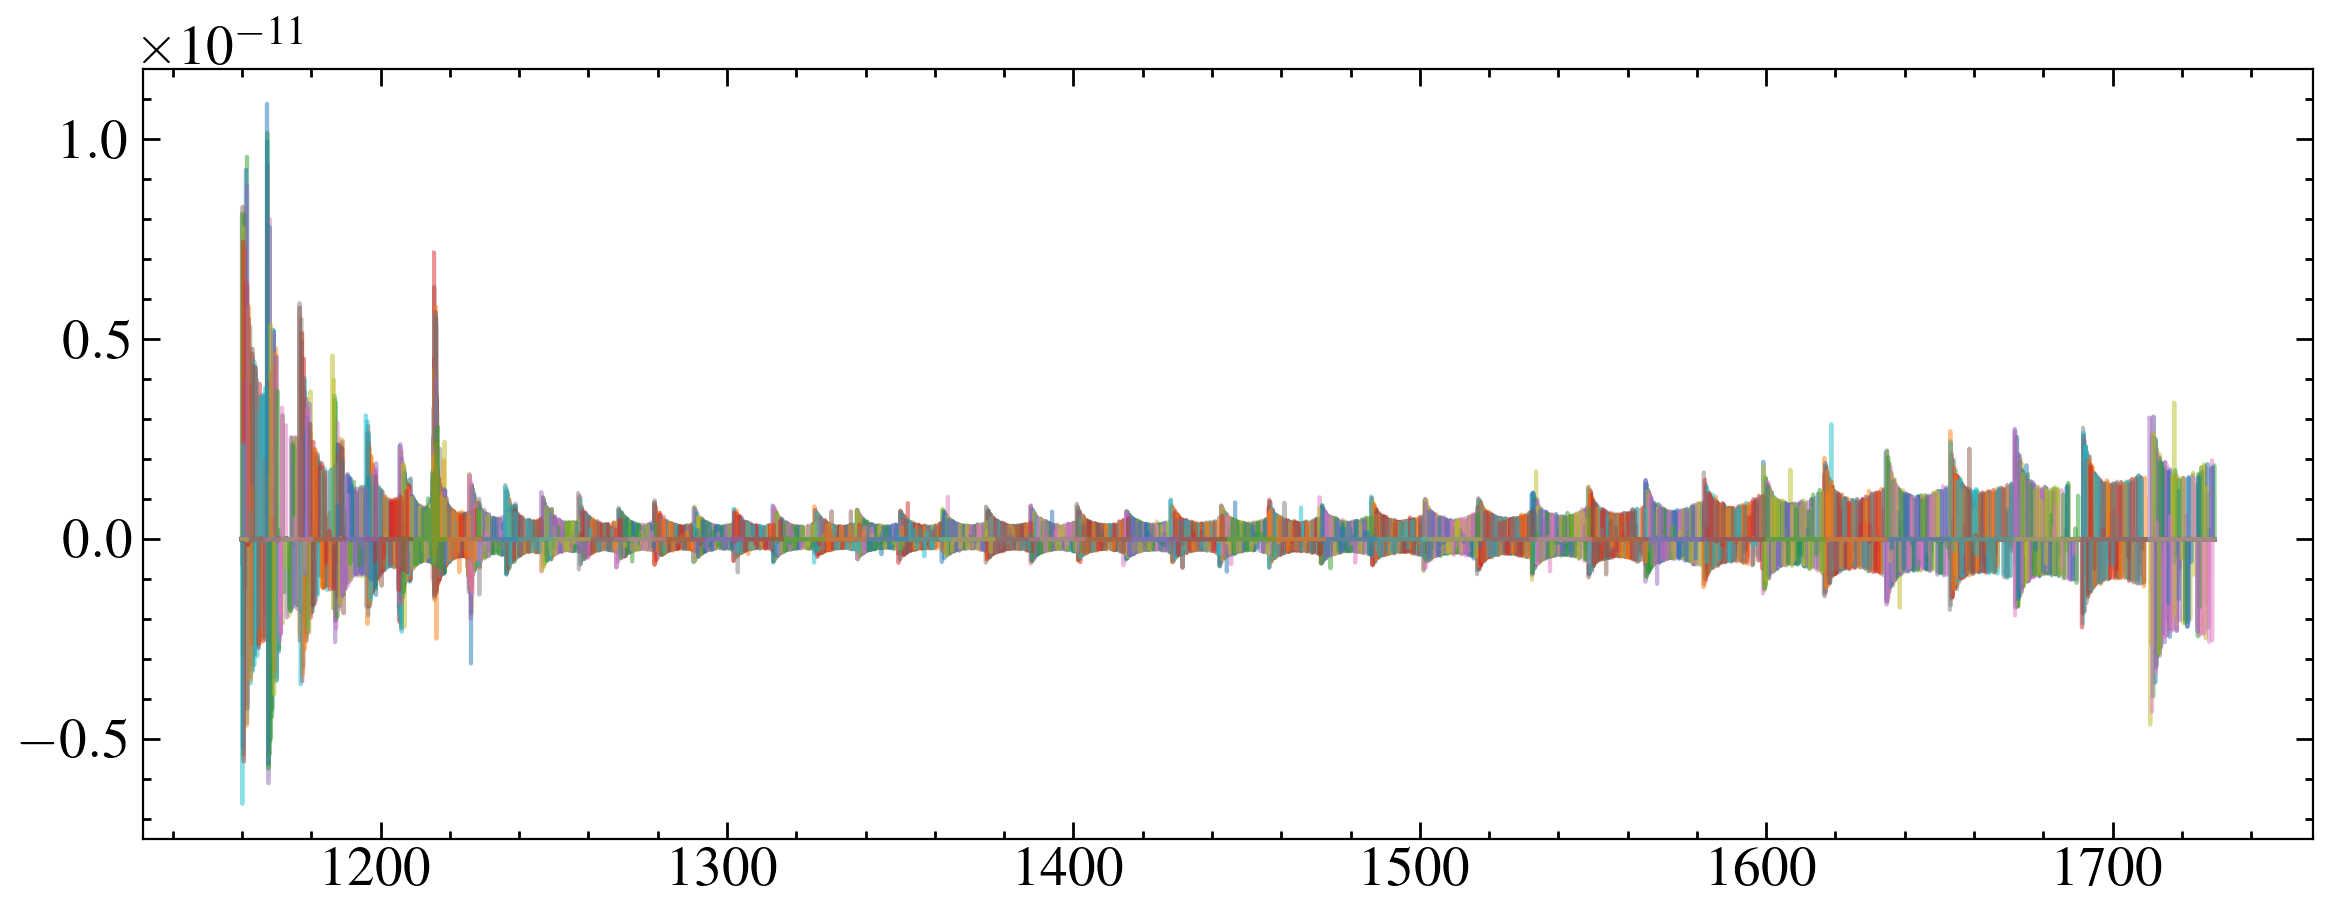

odlm08040


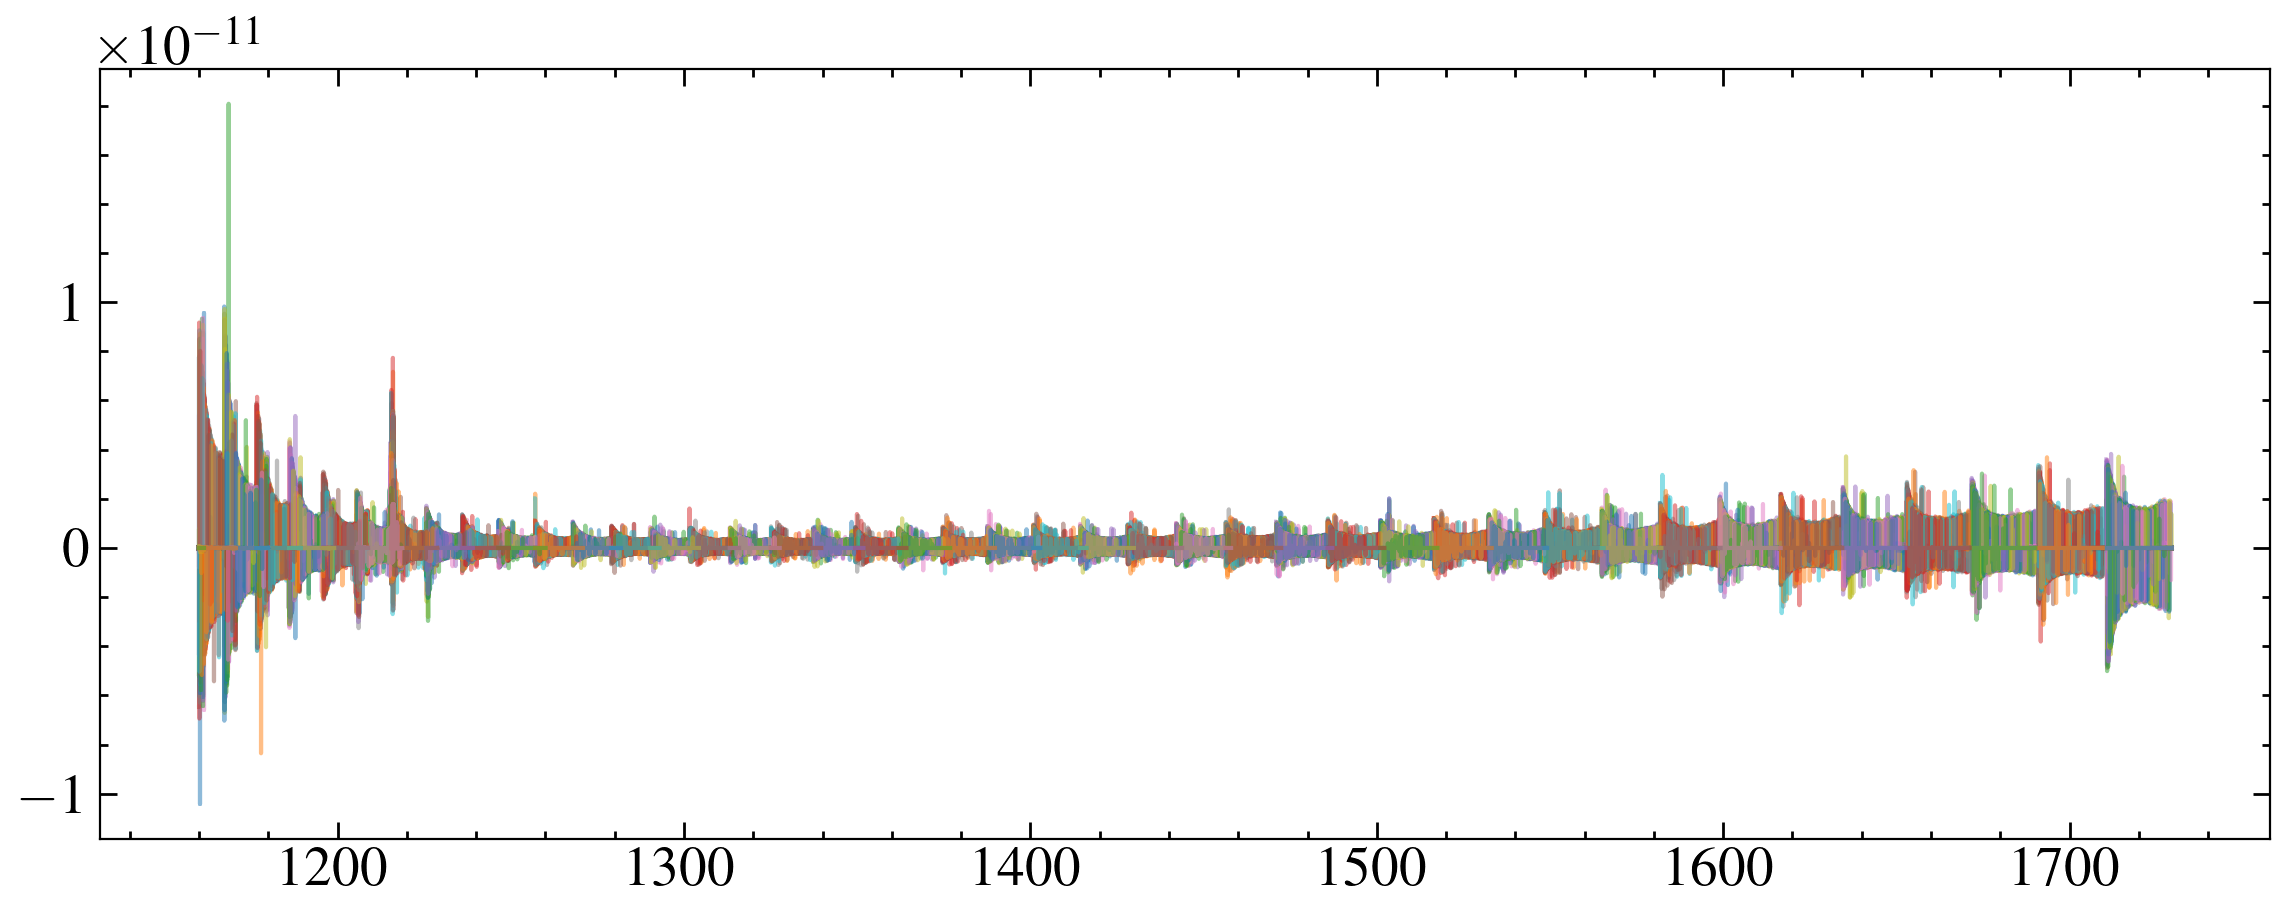

odlm08050


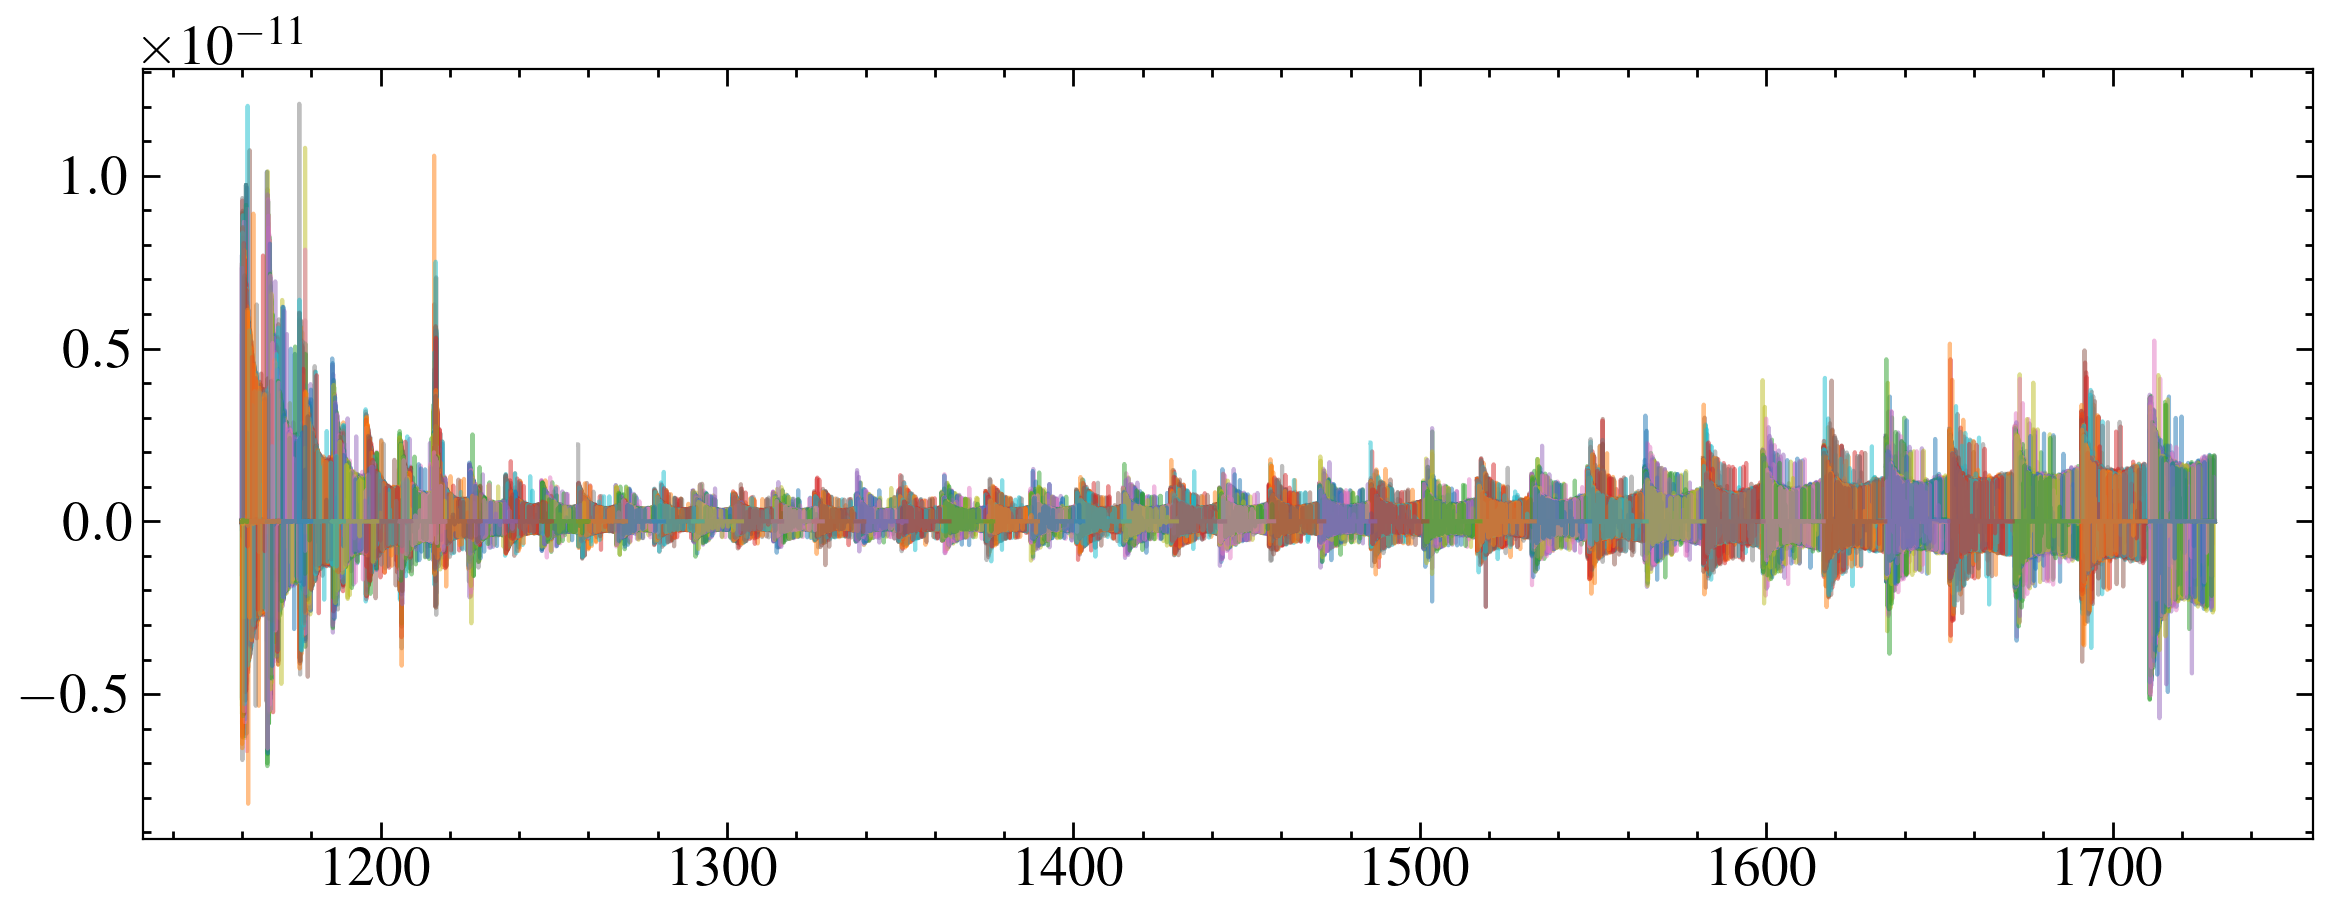

odlm08060


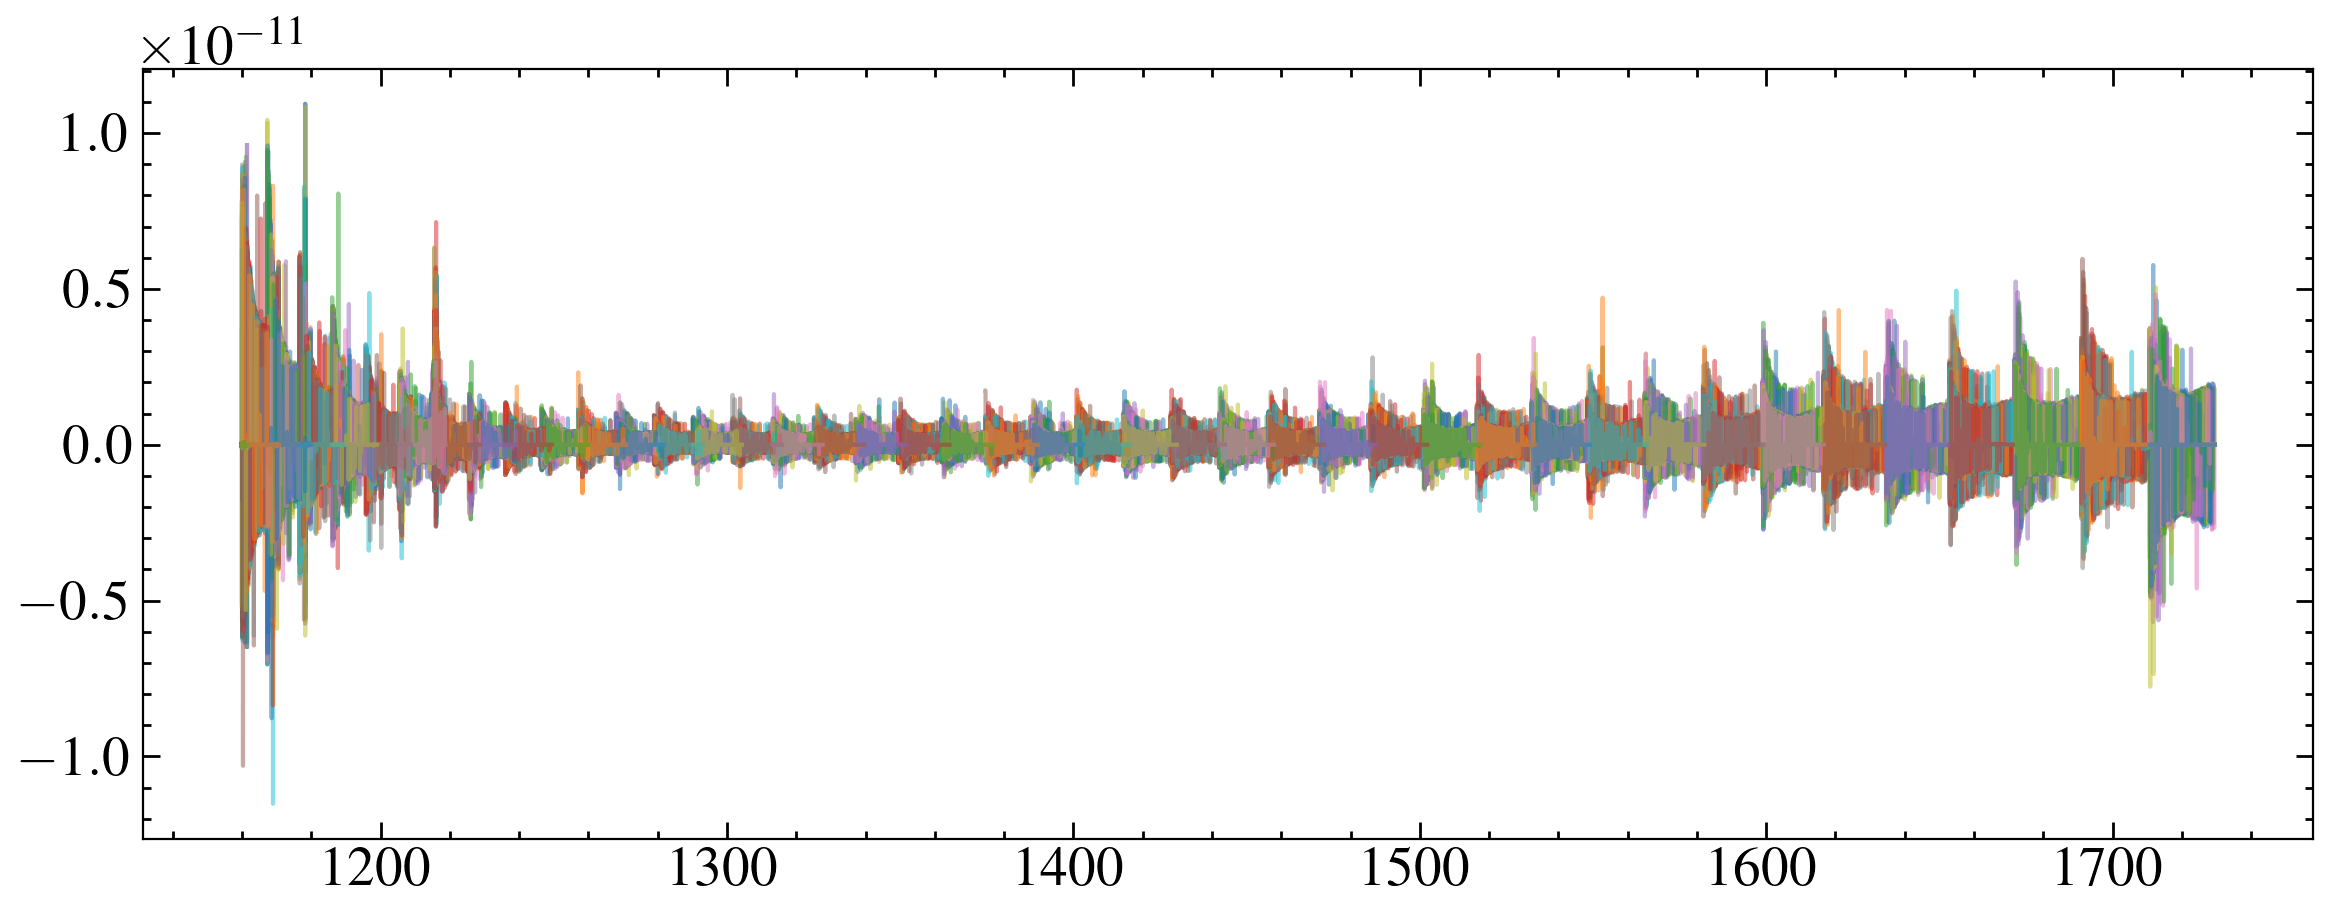

odlm09030


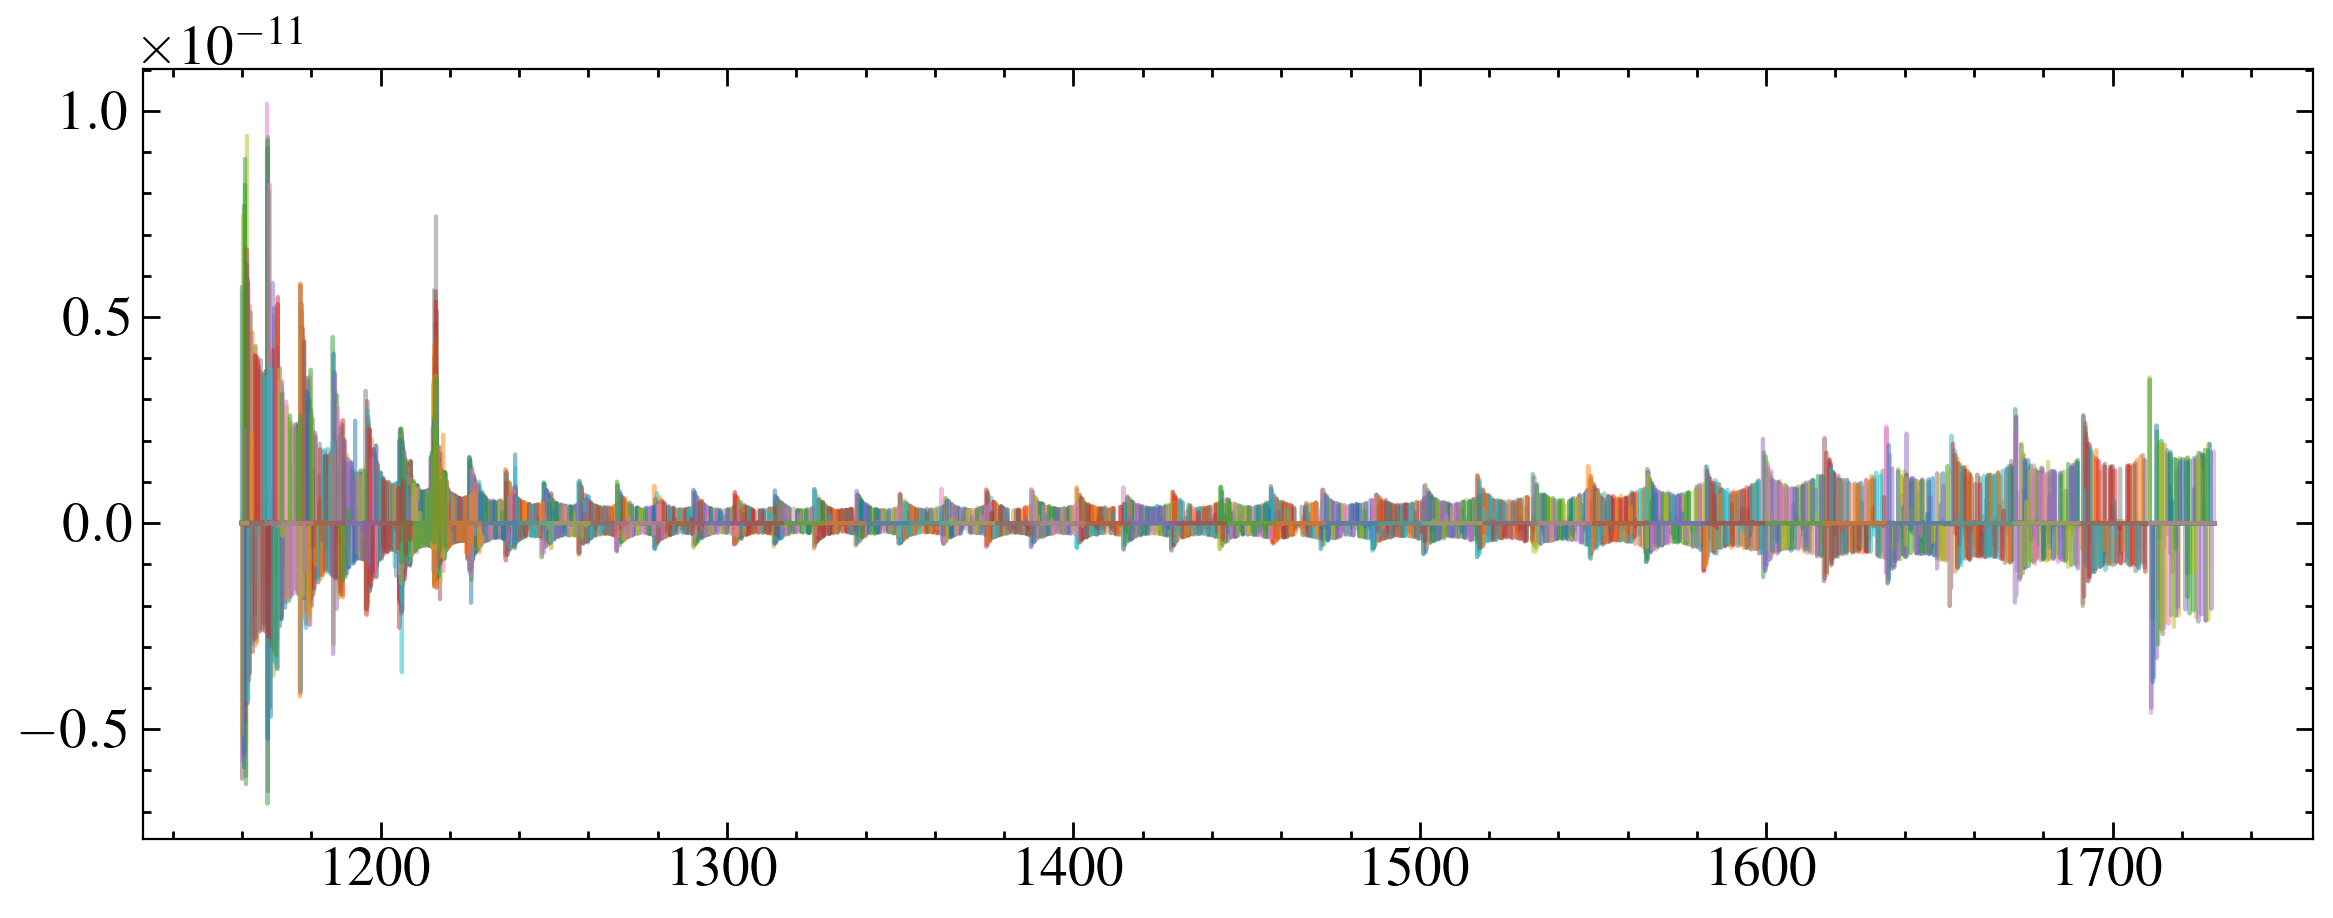

odlm09040


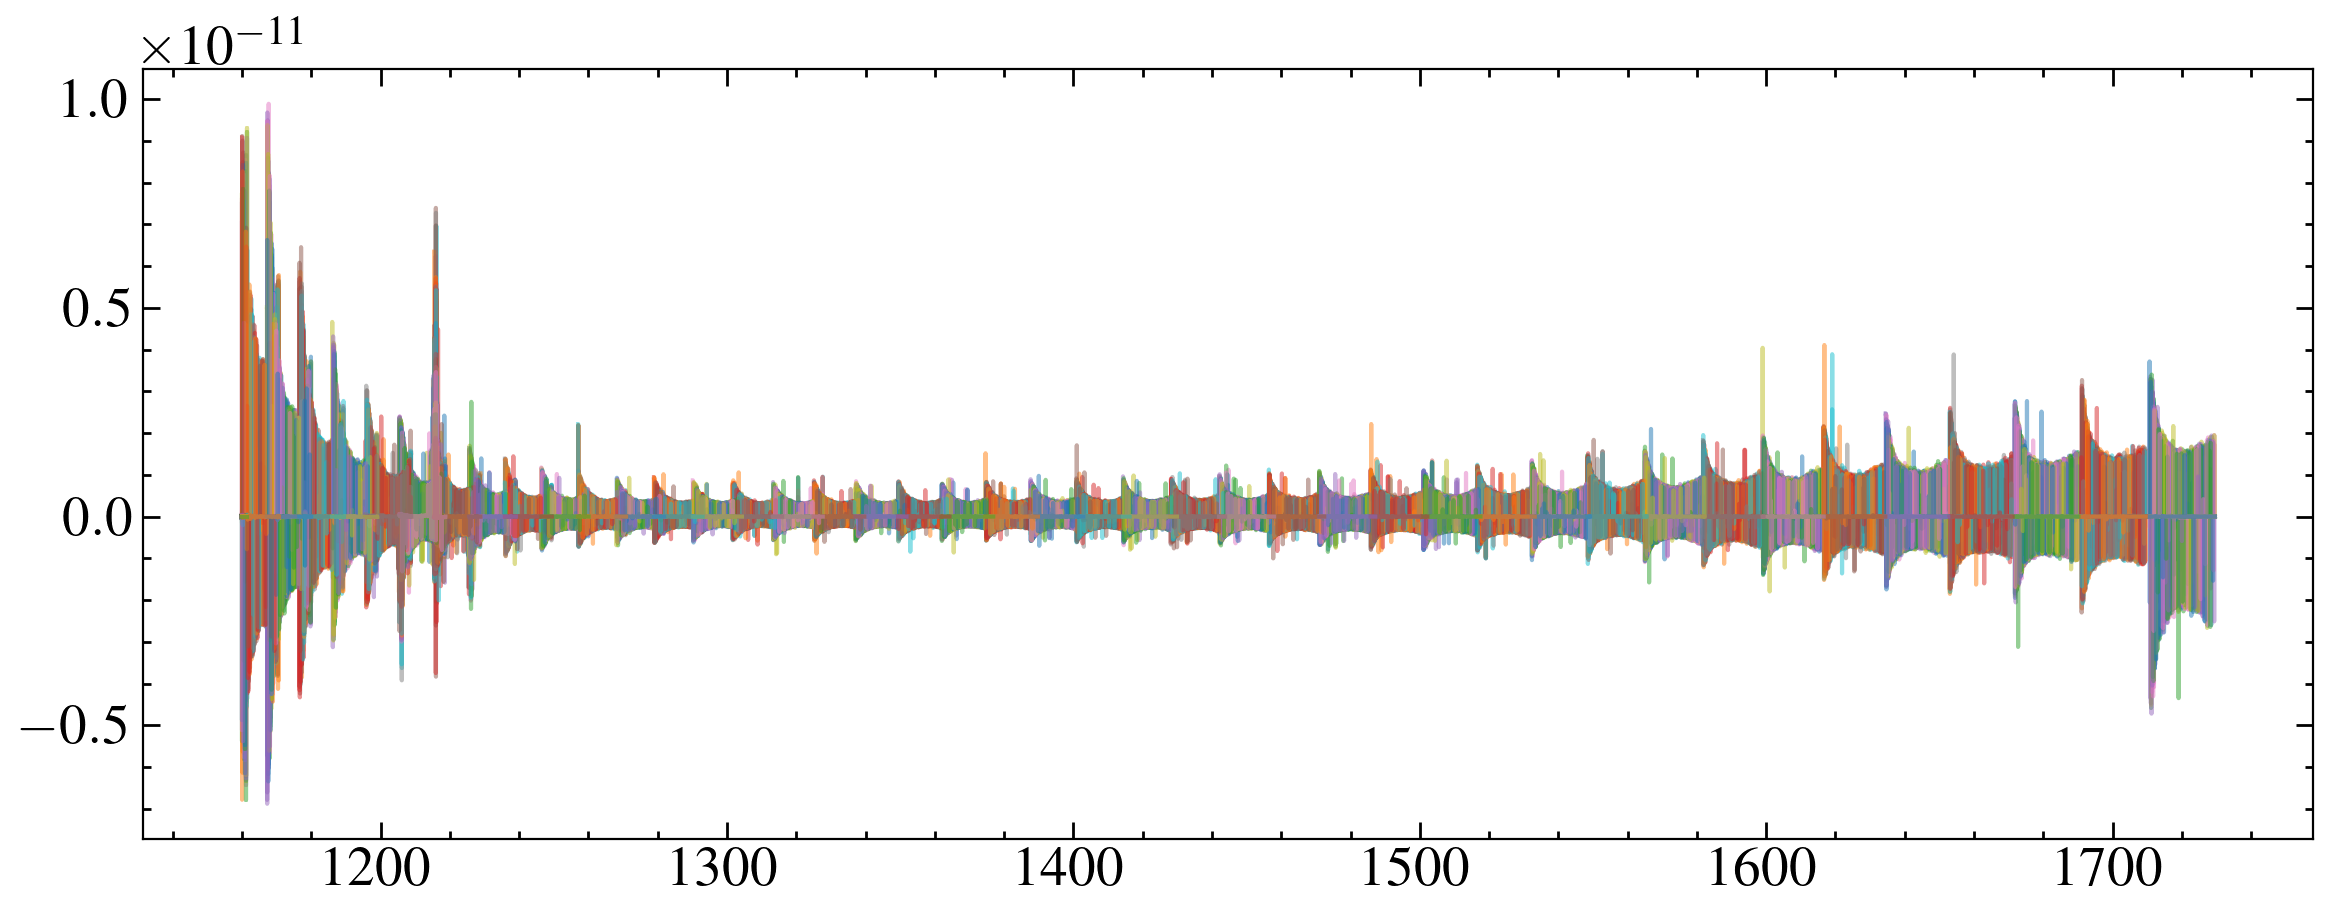

odlm09050


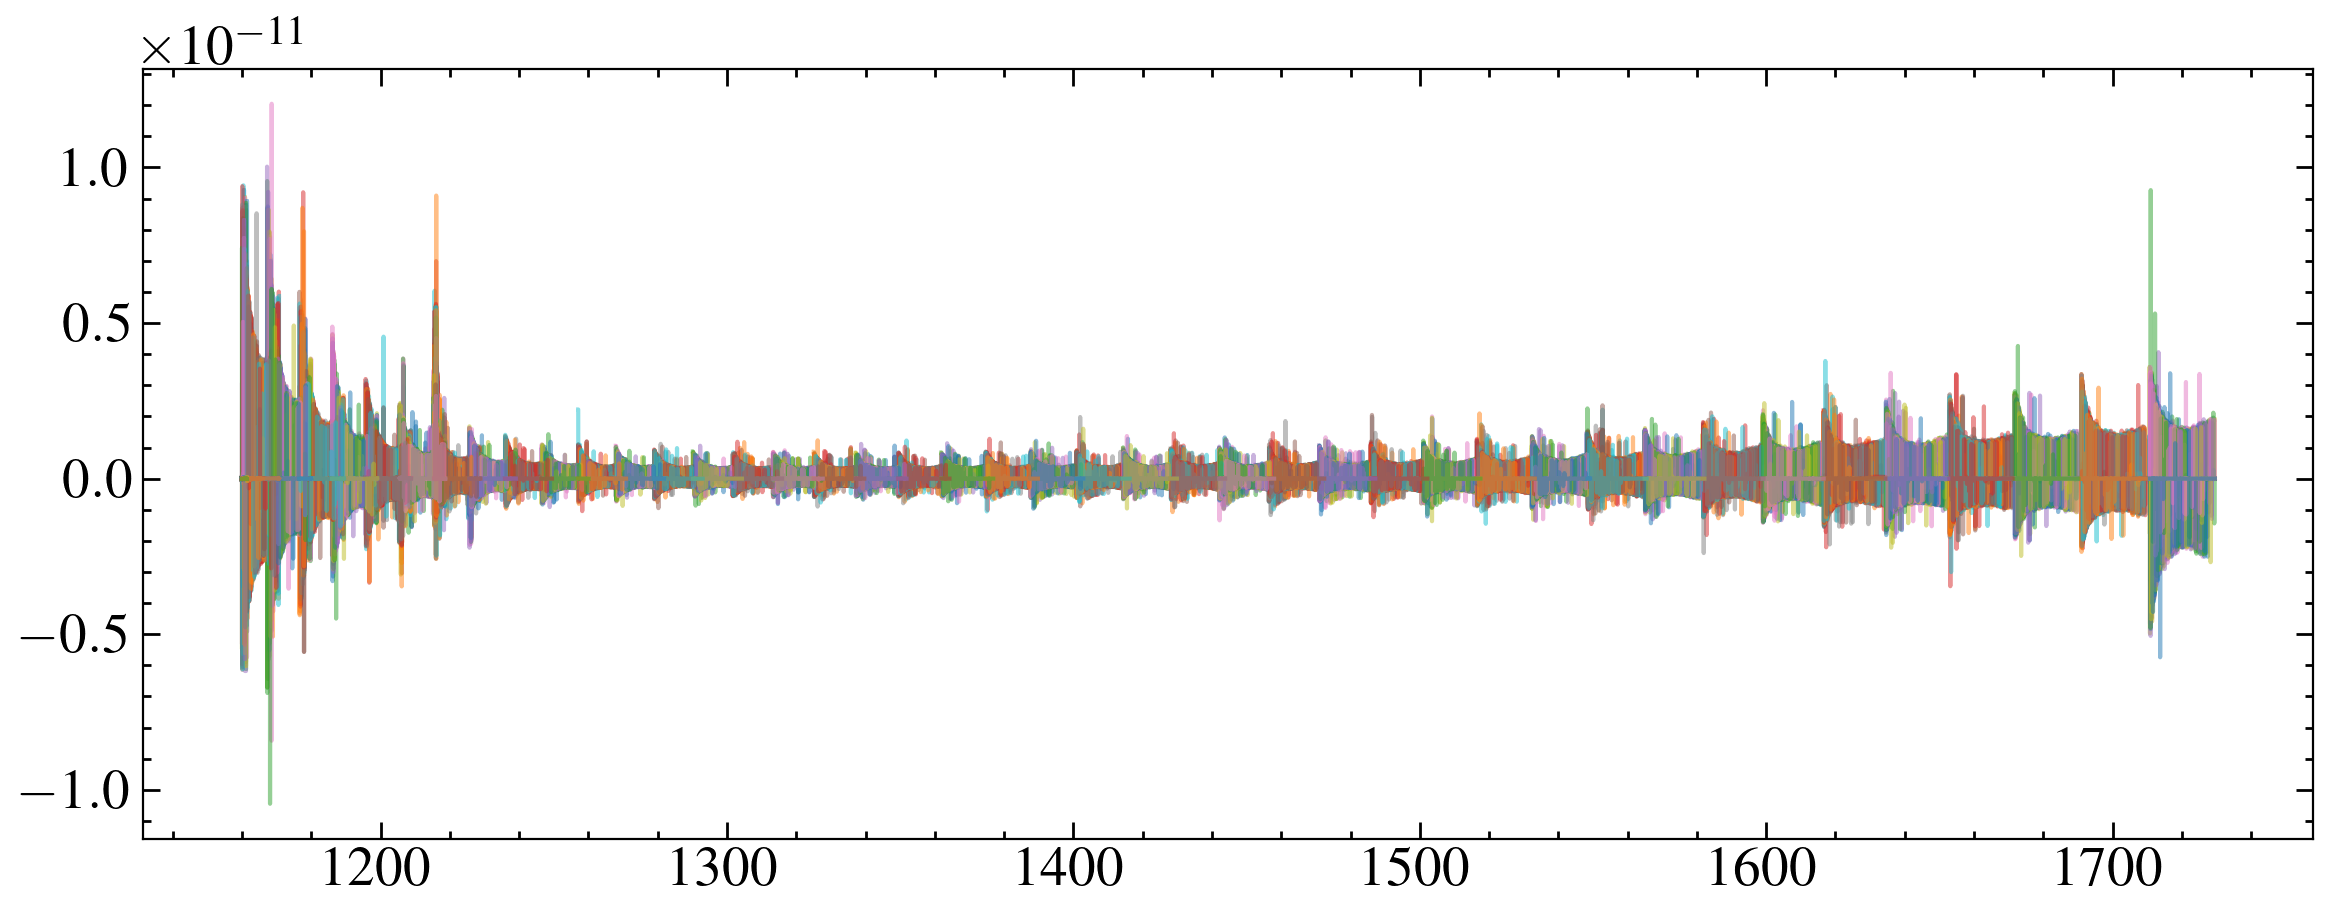

odlm09060


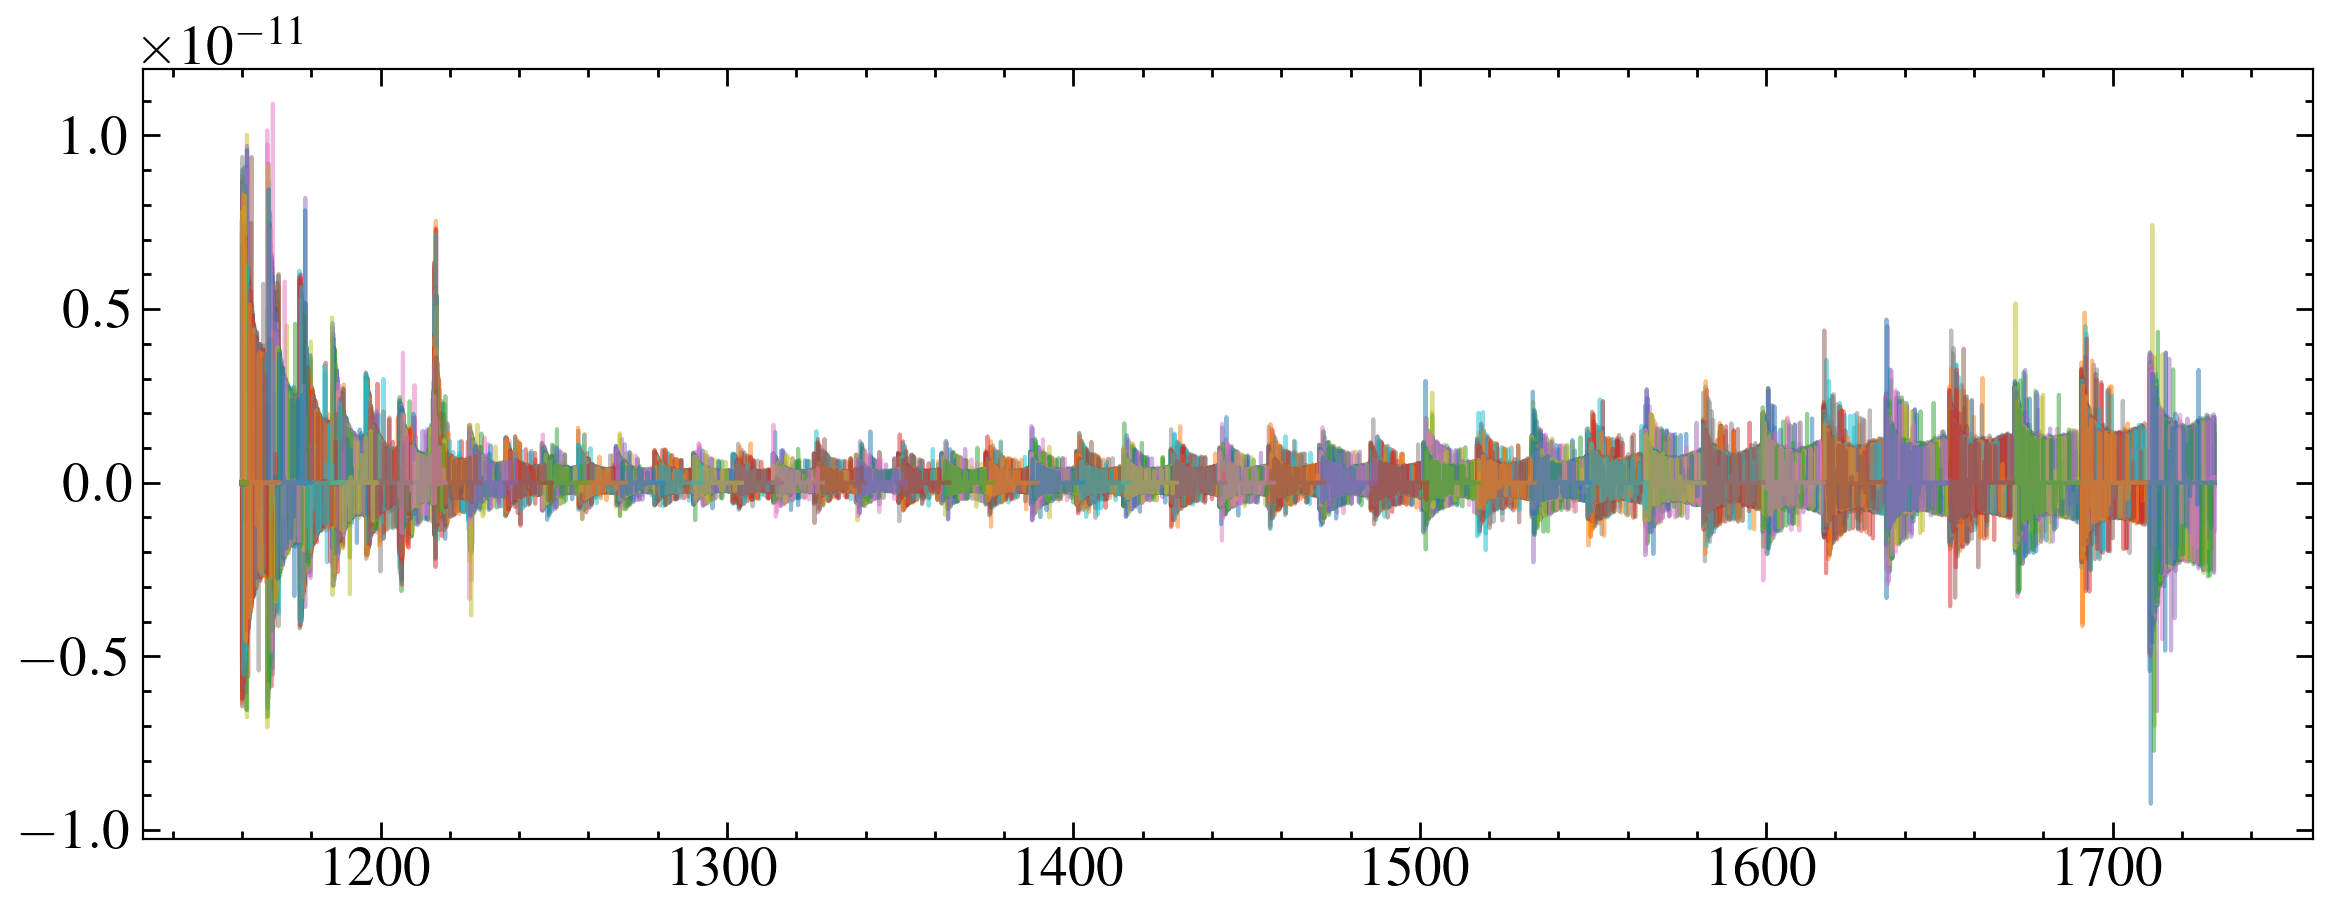

odlm37030


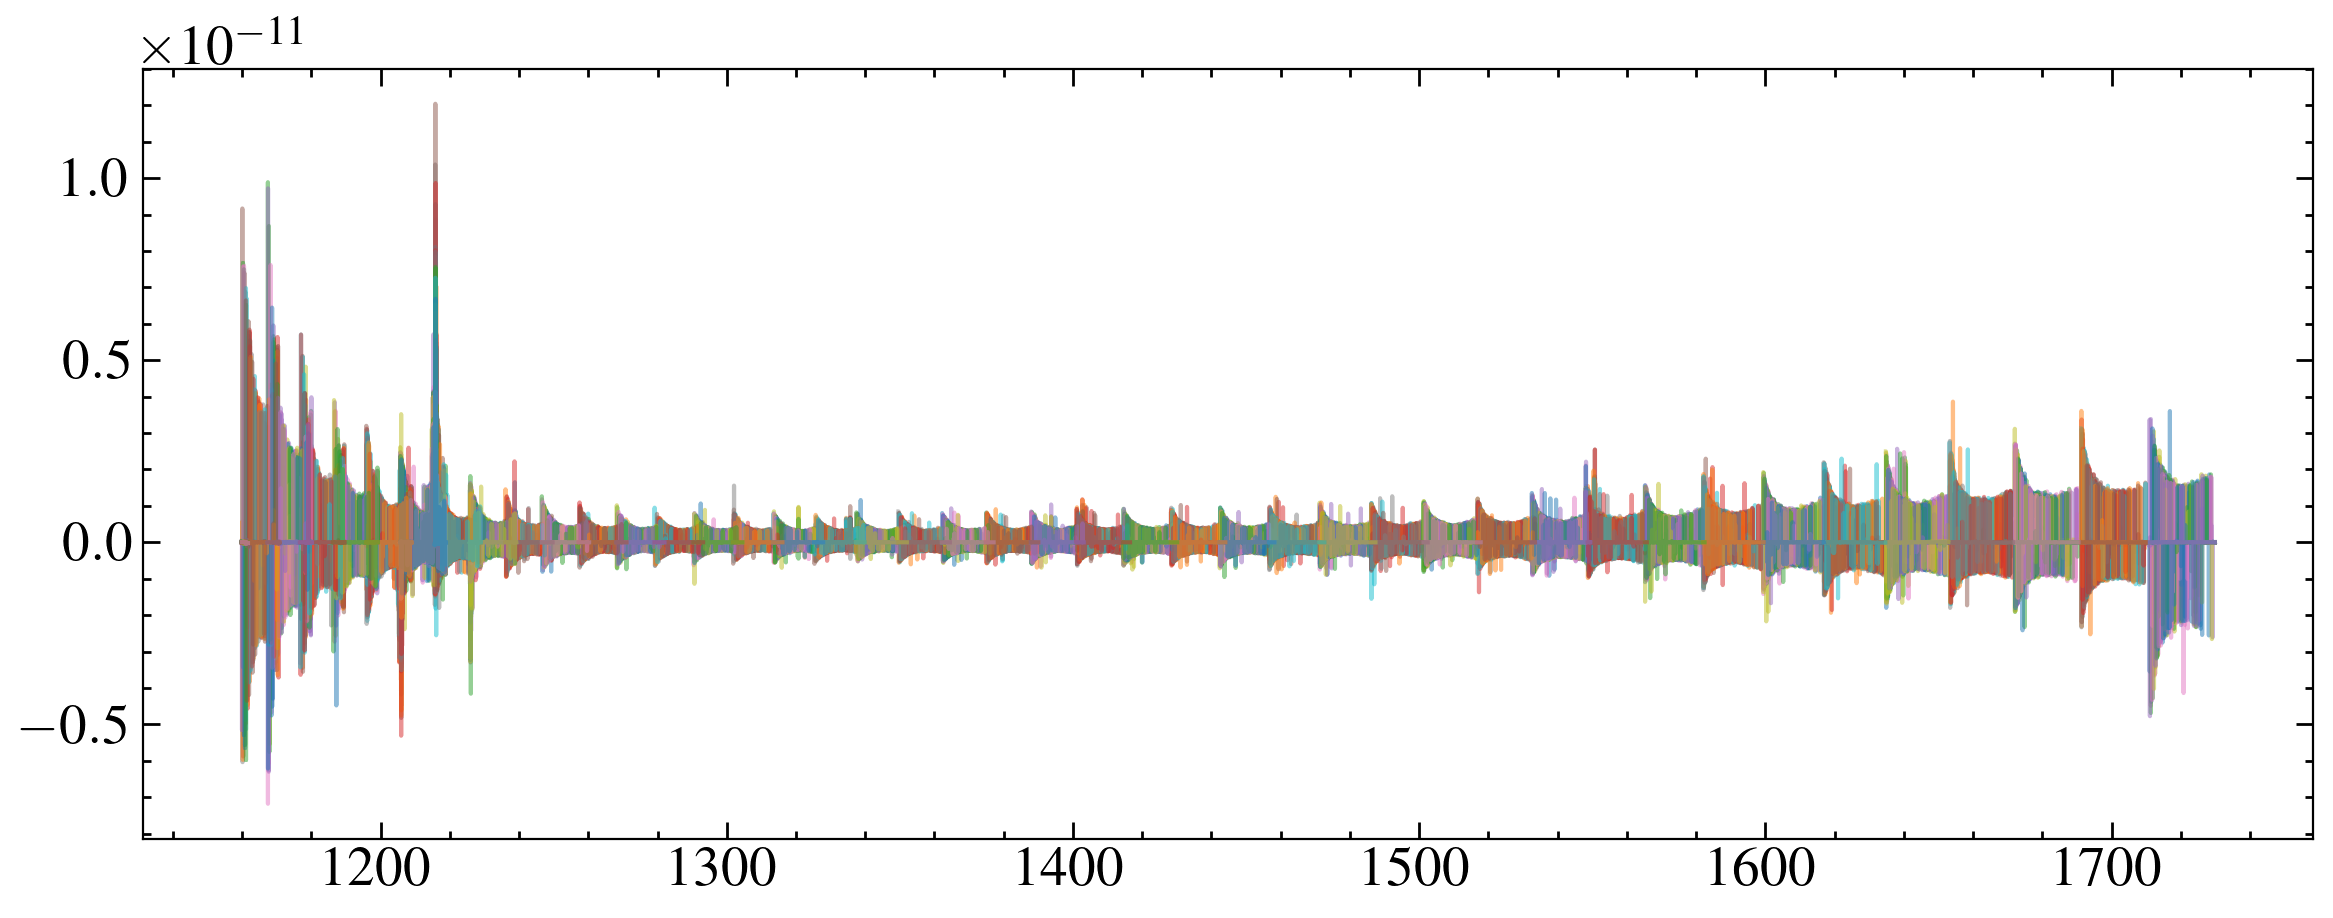

odlm37040


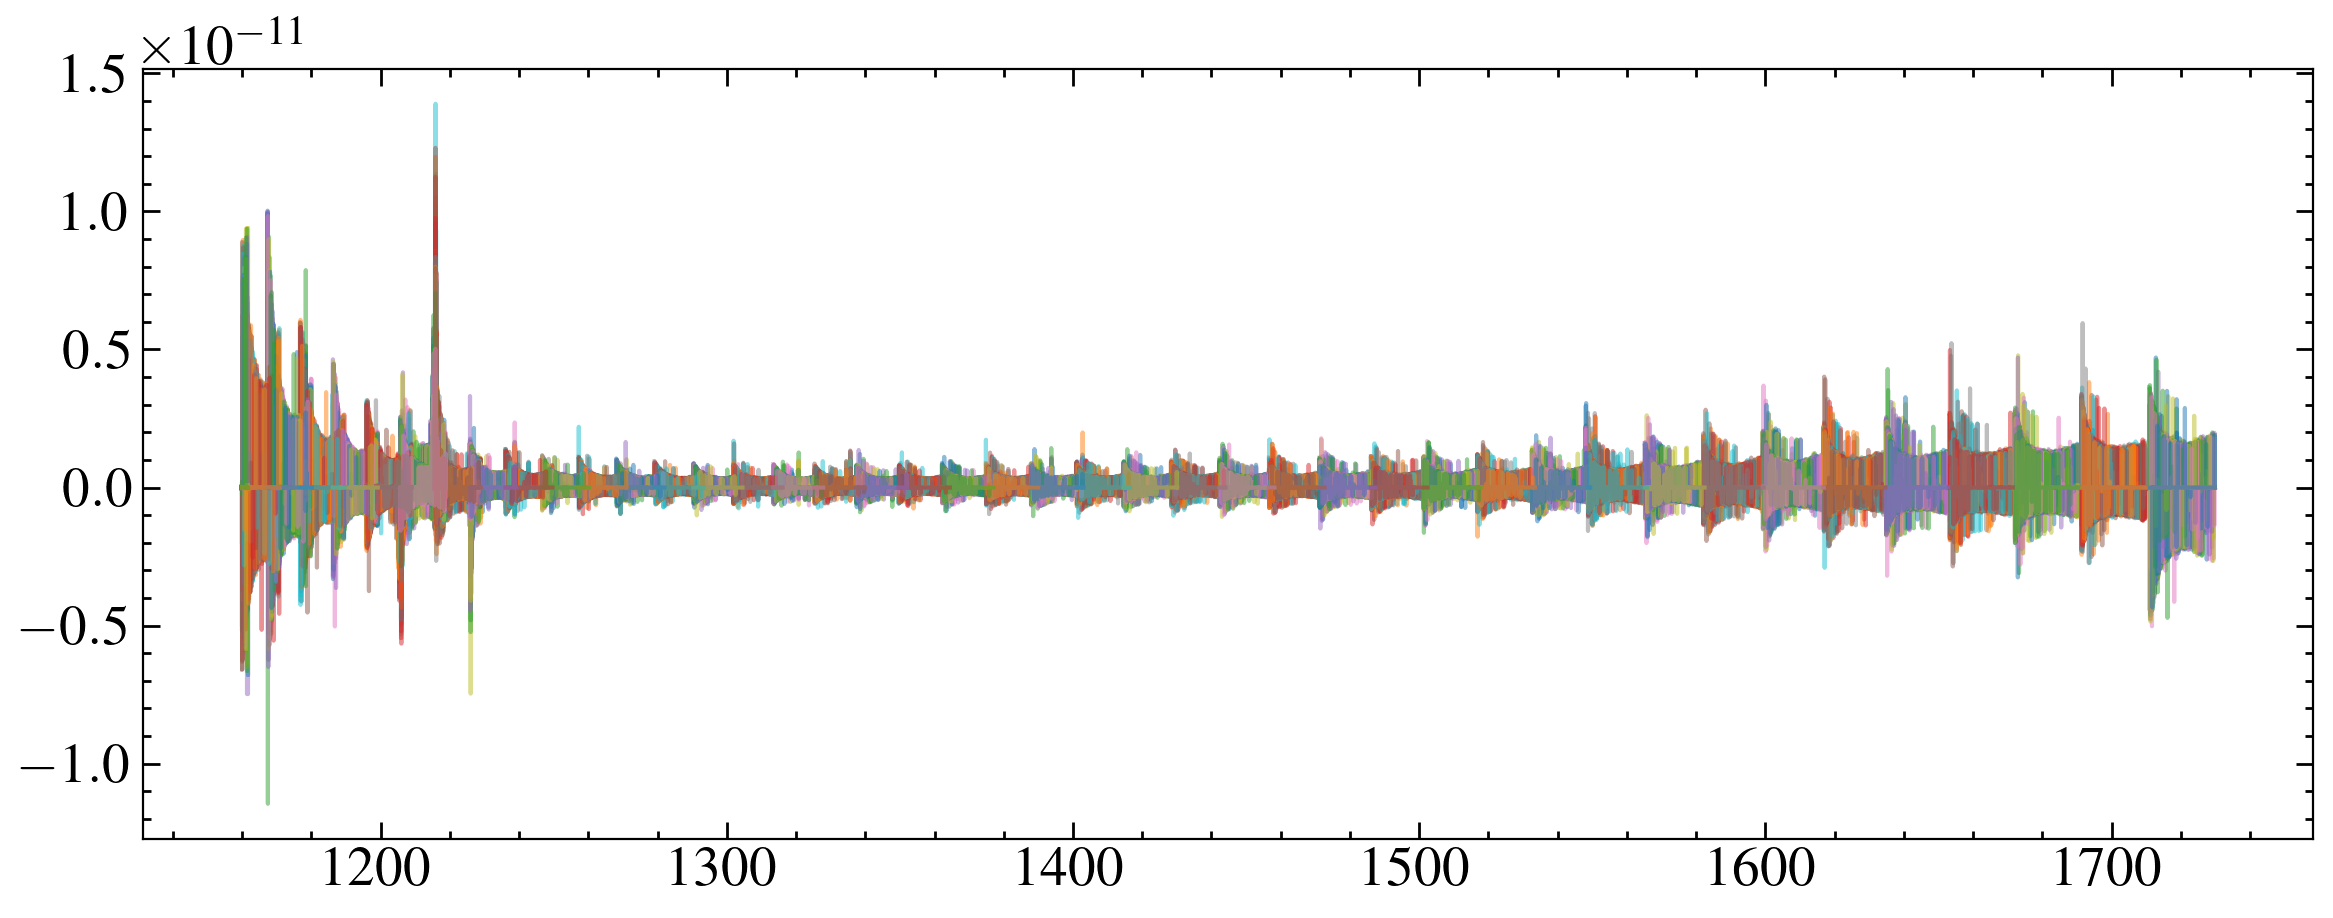

odlm37050


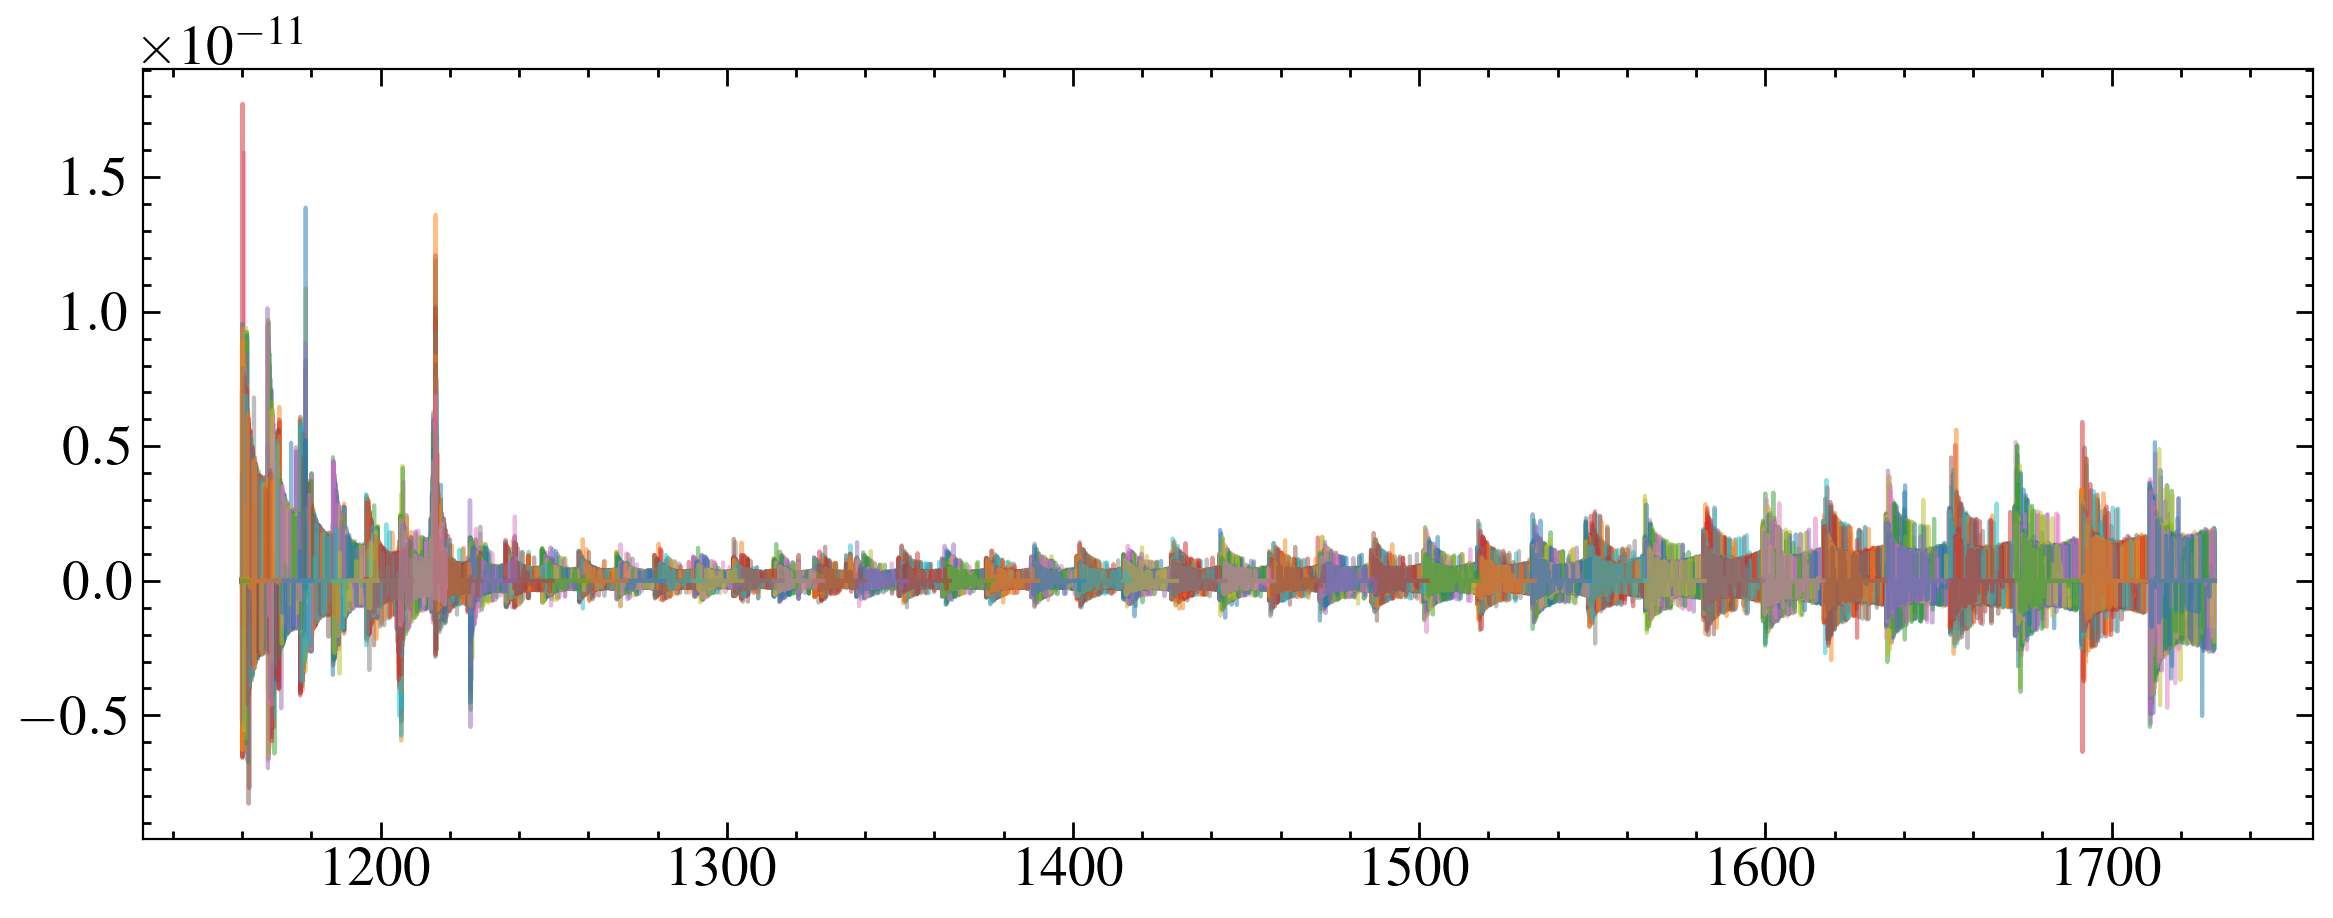

odlm37060


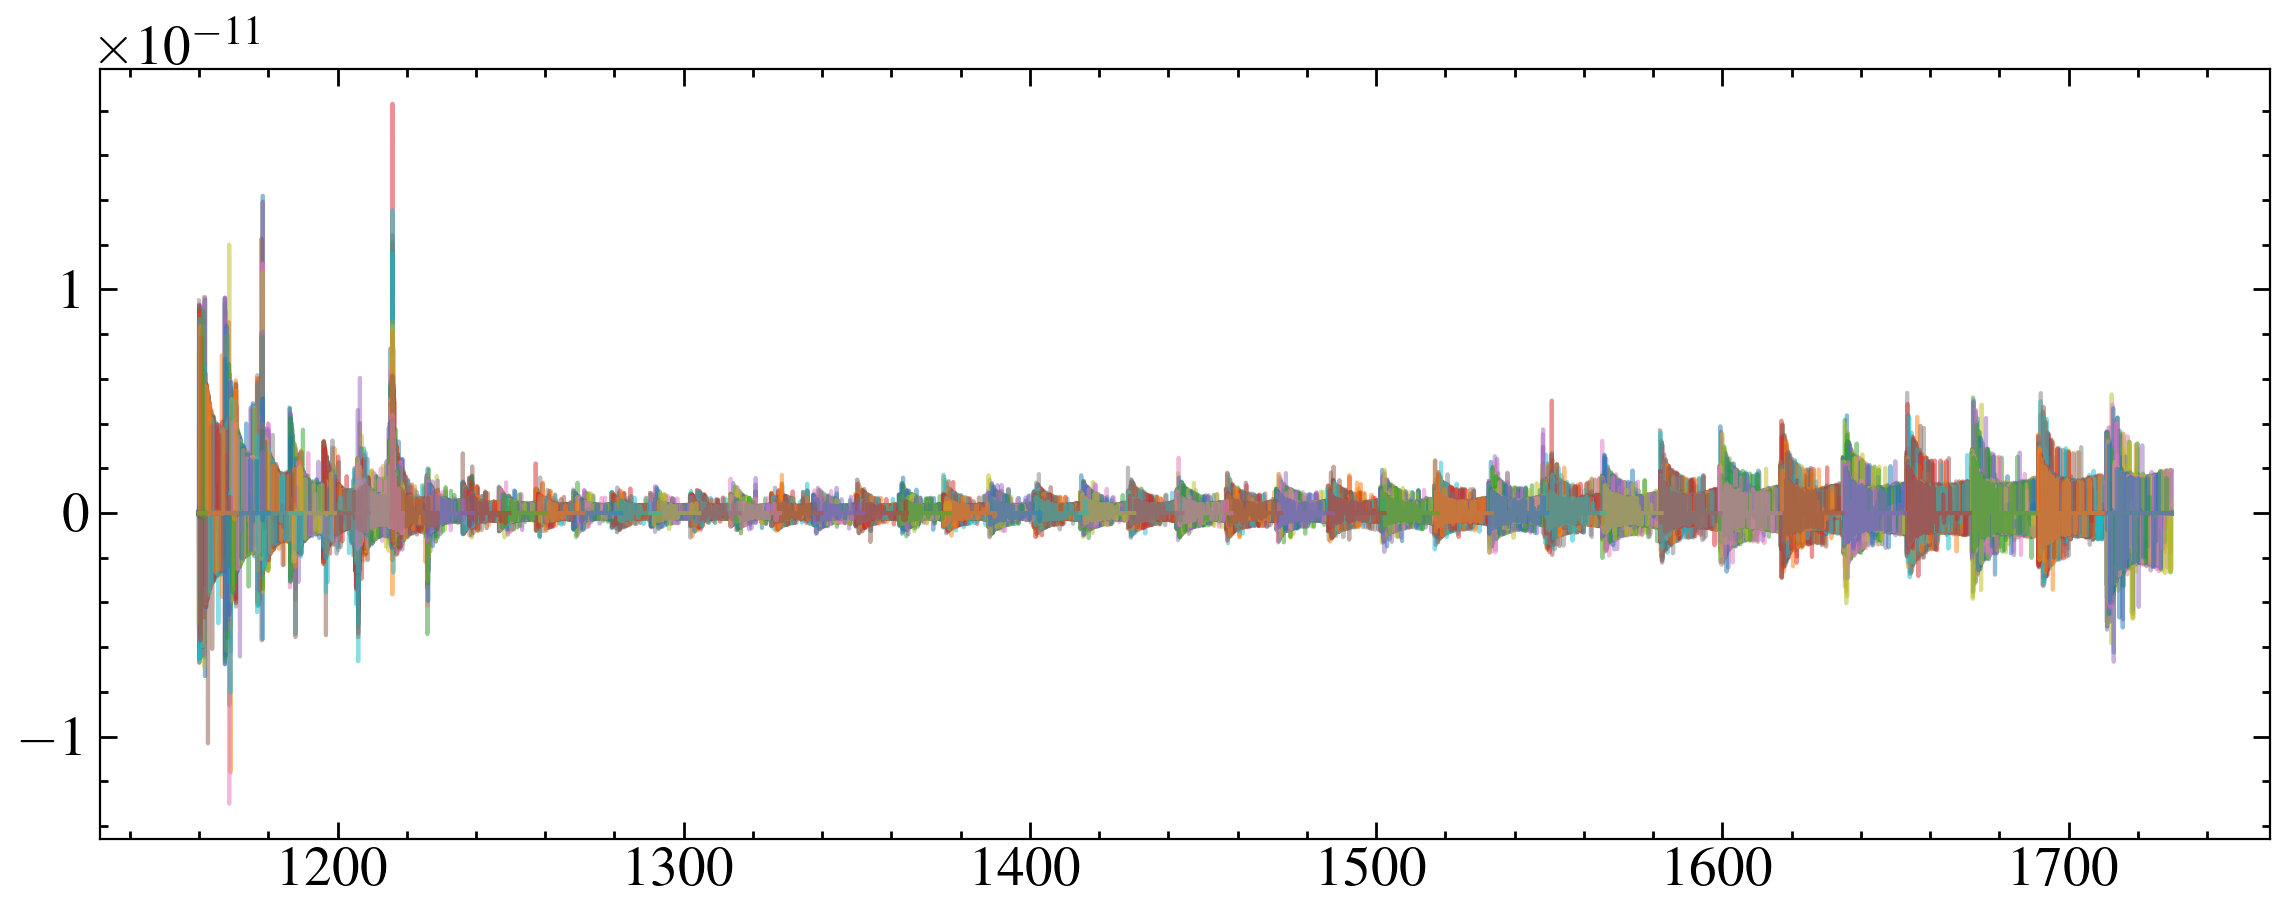

odlm38030


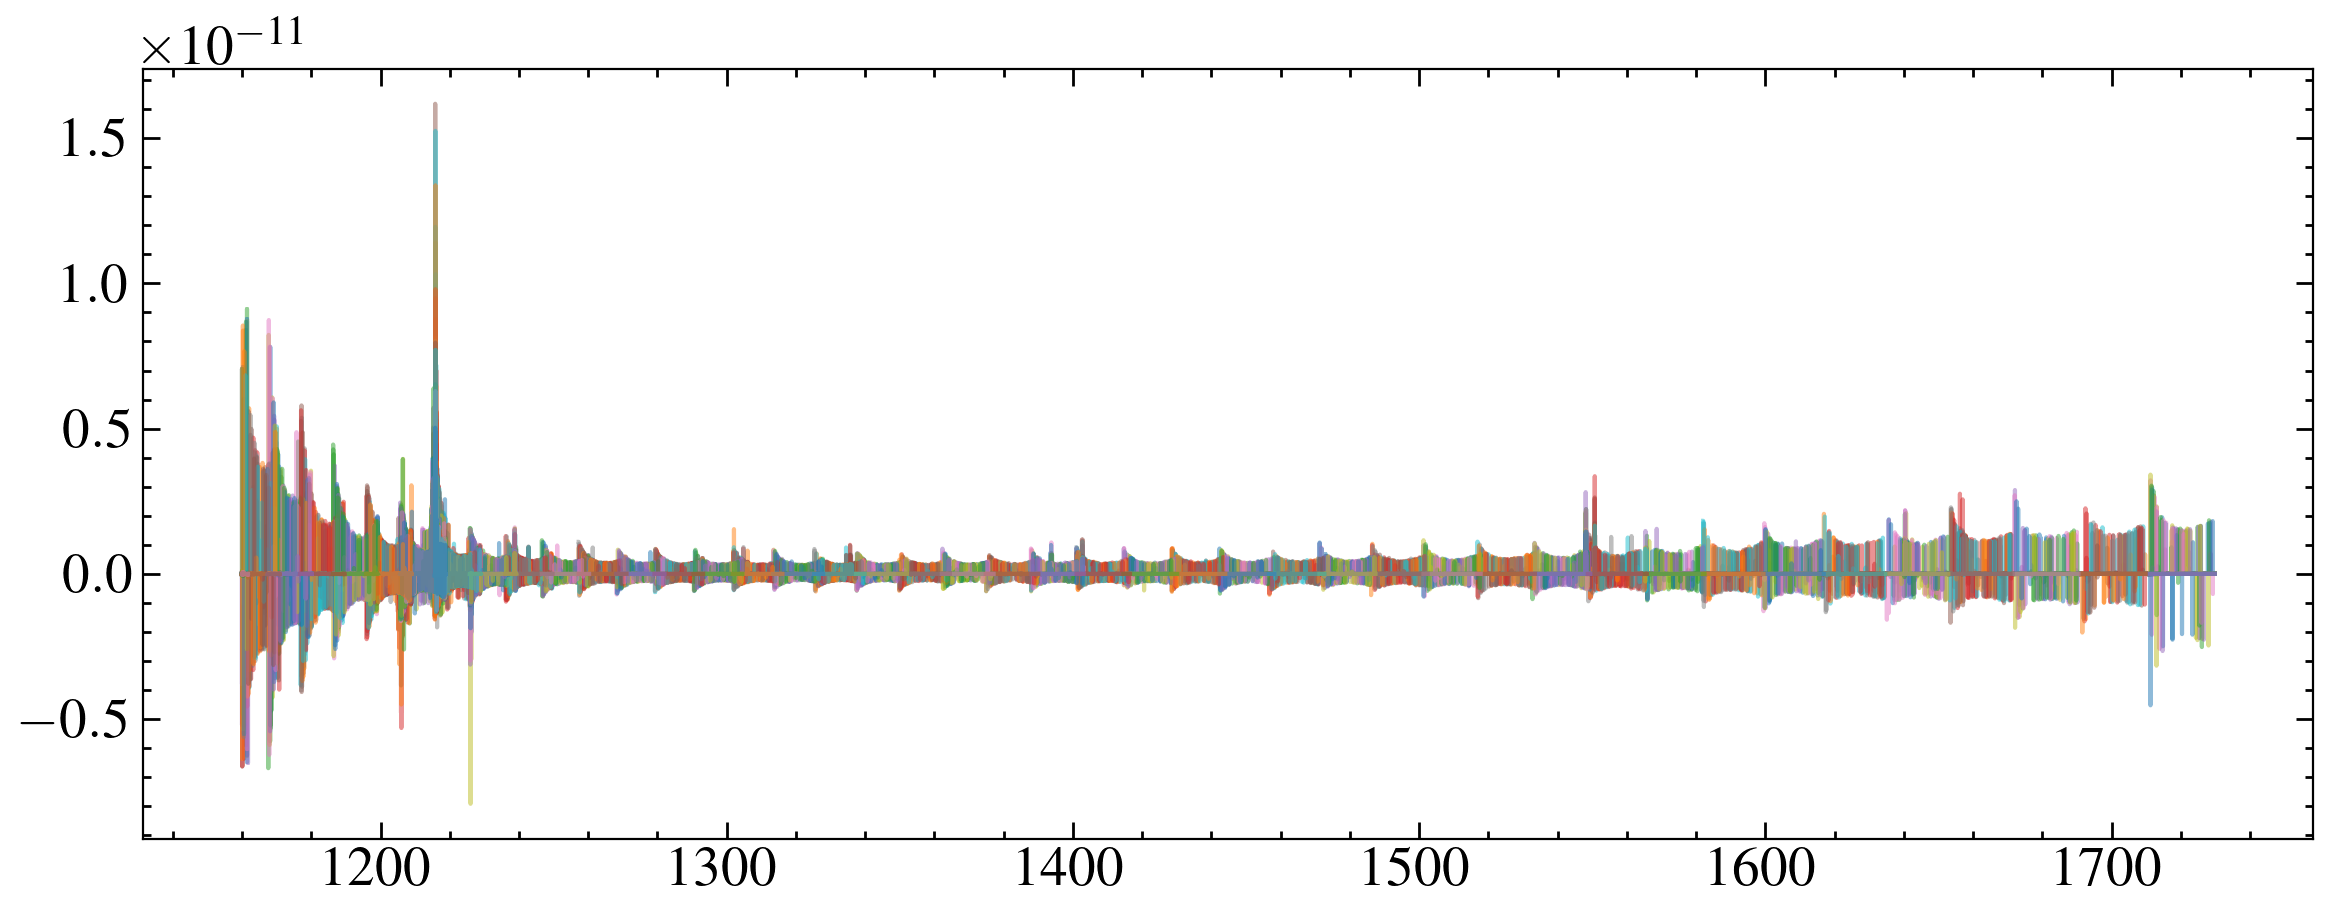

odlm38040


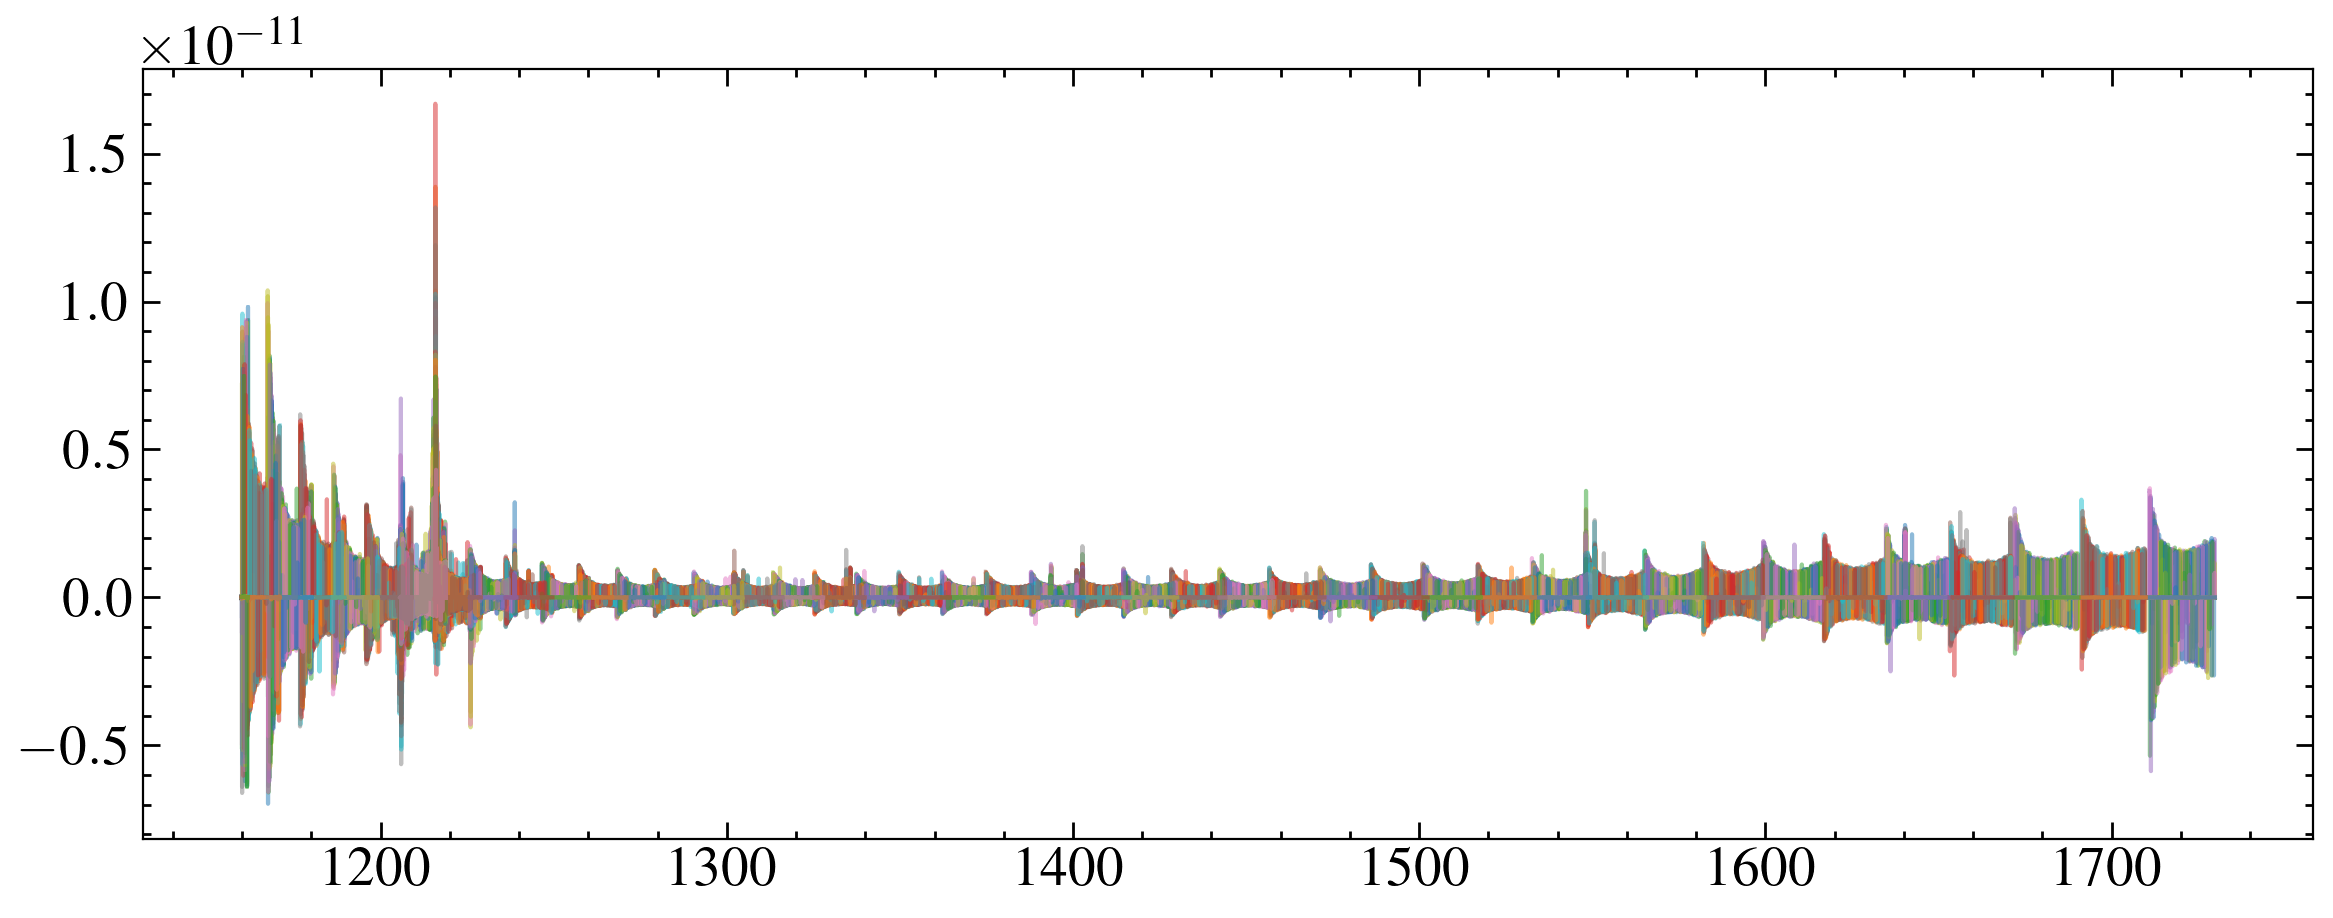

odlm38050


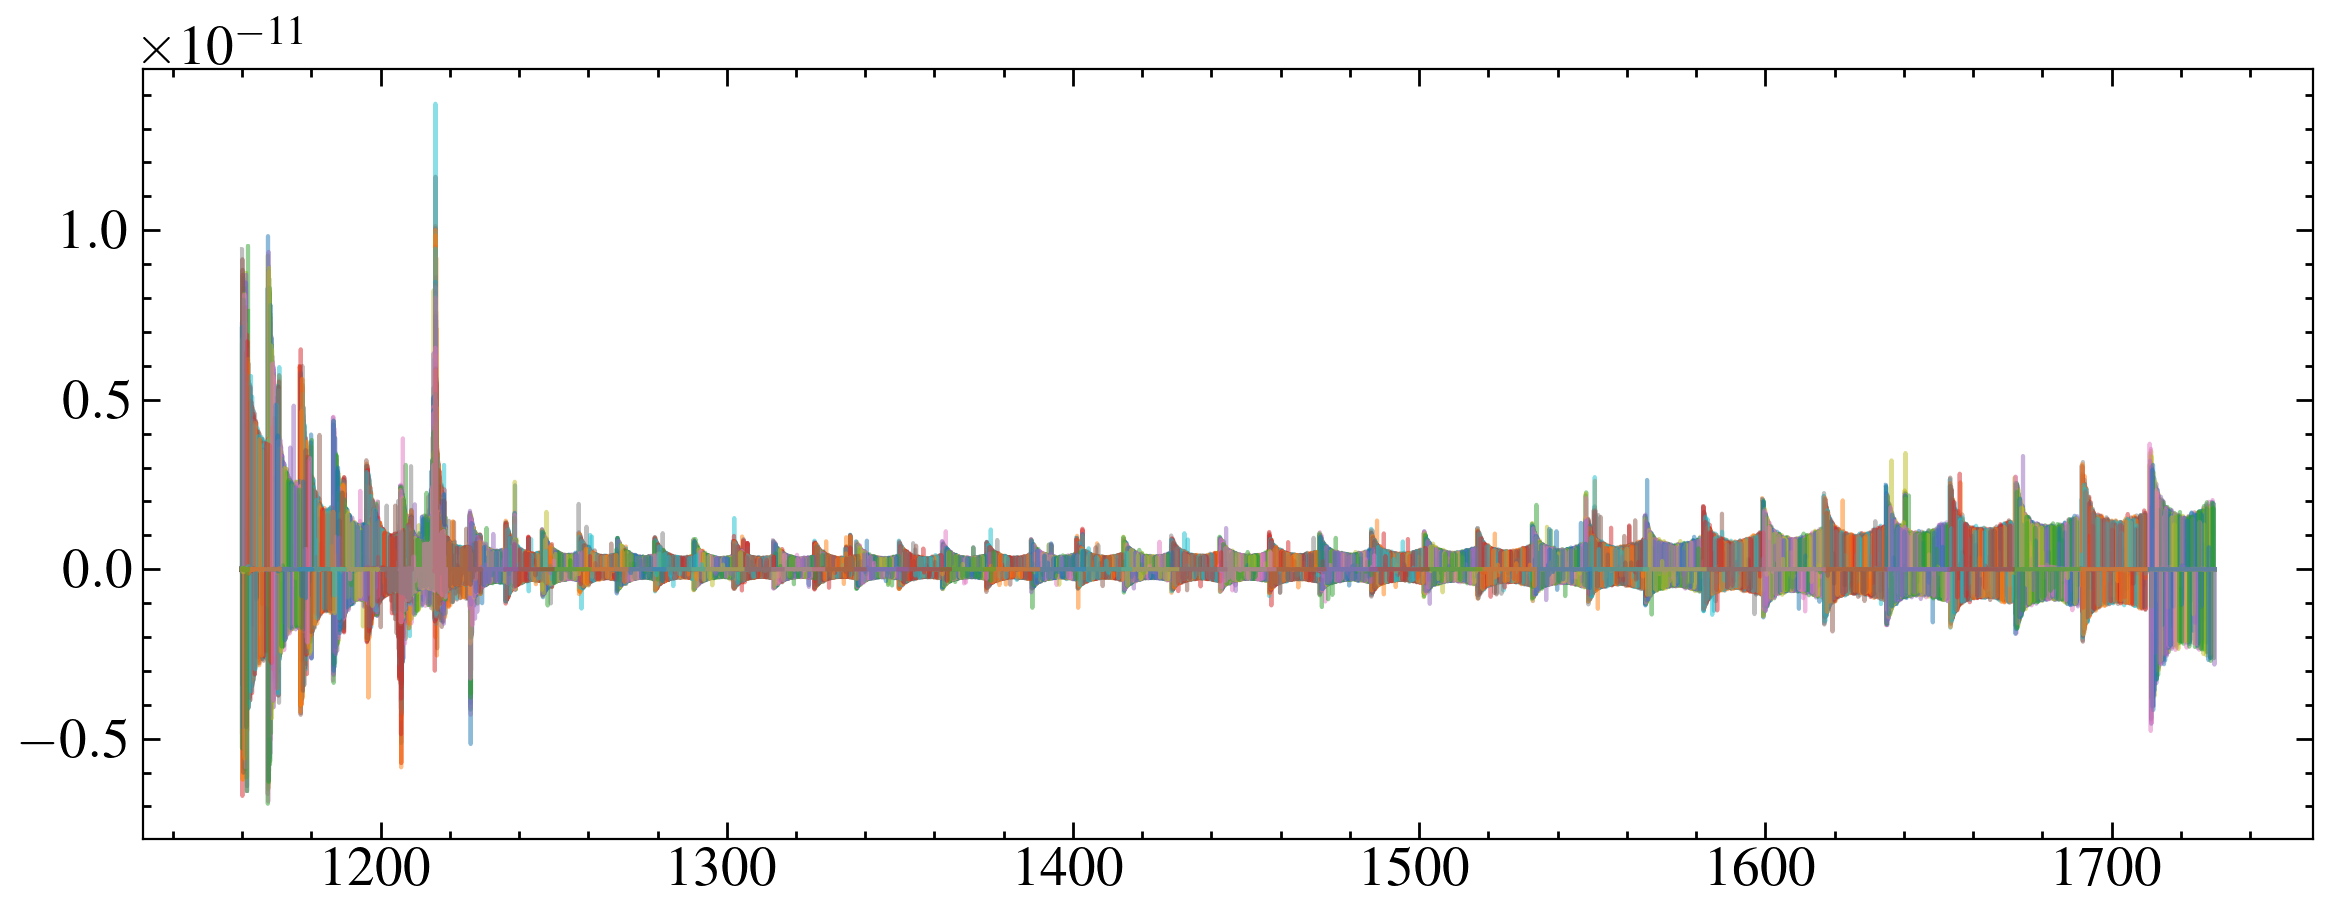

In [126]:
for x in new_x1ds:
    fig, ax = plt.subplots()
    hdul = fits.open(x)
    print(hdul[0].header['ROOTNAME'])
    for ext in hdul[1::]: #spectra in every extension after the first
        data = ext.data
        for dt in data:
            mask = dt['WAVELENGTH'] > 1160
            ax.step(dt['WAVELENGTH'][mask], dt['FLUX'][mask], where='mid', alpha=0.5)
        # plt.step(data['WAVELENGTH'], data['ERROR'], alpha =0.5, where='mid')
        # ax.set_ylim(0, 1.1*max(data['FLUX']))
        # plt.show()
    hdul.close()
    plt.show()
    

In [127]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux,error

def echelle_coadd_dq(wavelength, flux, err, dq, nclip =5, find_ratio =True, dq_adjust=False, dq_cut =0):
    """
    combines echelle orders into one spectrum, stiching them together at the overlap 
    """
    #slice dodgy ends off orders (usually 5-10 for stis el40m)
    wavelength = wavelength[:, nclip:-(nclip+1)]
    flux = flux[:, nclip:-(nclip+1)]
    err = err[:, nclip:-(nclip+1)]
    dq = dq[:, nclip:-(nclip+1)]
    
    #new arrays to put the output in
    w_full = np.array([], dtype=float)
    f_full = np.array([], dtype=float)
    e_full = np.array([], dtype=float)
    dq_full = np.array([], dtype=int)
    if find_ratio:
        r_full = np.array([], dtype=float) #ratio between orders

    shape = np.shape(flux)
    order = 0
    while order < (shape[0]):
        
        #first add the part that does not overlap ajacent orders to the final spectrum
        if order == 0: #first and last orders do not overlap at both ends
            overmask = (wavelength[order] > wavelength[order + 1][-1])
        elif order == shape[0]-1:
            overmask = (wavelength[order] < wavelength[order - 1][1])
        else:
            overmask = (wavelength[order] > wavelength[order + 1][-1]) & (wavelength[order] < wavelength[order - 1][1])
        w_full = np.concatenate((w_full, wavelength[order][overmask]))
        f_full = np.concatenate((f_full, flux[order][overmask]))
        e_full = np.concatenate((e_full, err[order][overmask]))
        dq_full = np.concatenate((dq_full, dq[order][overmask]))
        if find_ratio:
            r_full = np.concatenate((r_full, np.full(len(err[order][overmask]), -1)))
  
        if order != shape[0]-1:
            
            #interpolate each order onto the one beneath it, with larger wavelength bins. Code adapted from stisblazefix
            f = interpolate.interp1d(wavelength[order + 1], flux[order + 1], fill_value='extrapolate')
            g = interpolate.interp1d(wavelength[order + 1], err[order + 1], fill_value='extrapolate')
            dqi = interpolate.interp1d(wavelength[order + 1], dq[order + 1], kind='nearest',bounds_error=False, fill_value=0)
            overlap = np.where(wavelength[order] <= wavelength[order + 1][-1])
            f0 = flux[order][overlap]
            f1 = f(wavelength[order][overlap])
            g0 = err[order][overlap]
            g1 = g(wavelength[order][overlap])
            dq0 = dq[order][overlap]
            dq1 = dqi(wavelength[order][overlap])
       
             
            #combine flux and error at overlap and add to final spectrum
            w_av = wavelength[order][overlap]
            if dq_adjust: #removes values with high dq: #THIS DOESN'T REALLY WORK YET
                if dq_cut == 0:
                    dq_cut = 1 #allows zero to be the default
                for i in range(len(wavelength[order][overlap])):
                    if dq0[i] >= dq_cut:
                        g0 *= 100 #make error very large so it doesn't contribute to the coadd
                    if dq1[i] >= dq_cut:
                        g1 *= 100 
                        
            
            
            f_av, e_av = spectra_adder(np.array([f0,f1]),np.array([g0,g1]))
            dq_av = [(np.sum(np.unique(np.array([dq0, dq1])[:,i]))) for i in range(len(dq0))]
            
            
            w_full = np.concatenate((w_full, w_av))
            f_full = np.concatenate((f_full, f_av))
            e_full = np.concatenate((e_full, e_av))
            dq_full = np.concatenate((dq_full, dq_av))
            
            if find_ratio:
                r_full = np.concatenate((r_full, f0/f1))
        order += 1
    
    #stis orders are saved in reverse order, so combined spectra are sorted by the wavelength array
    arr1inds = w_full.argsort()
    sorted_w = w_full[arr1inds]
    sorted_f = f_full[arr1inds]
    sorted_e = e_full[arr1inds]
    sorted_dq = dq_full[arr1inds]
    if find_ratio:
        sorted_r = r_full[arr1inds]
 
    if find_ratio:
        return sorted_w, sorted_f, sorted_e, sorted_dq, sorted_r
    else:
        return sorted_w, sorted_f, sorted_e, sorted_dq

GJ15A


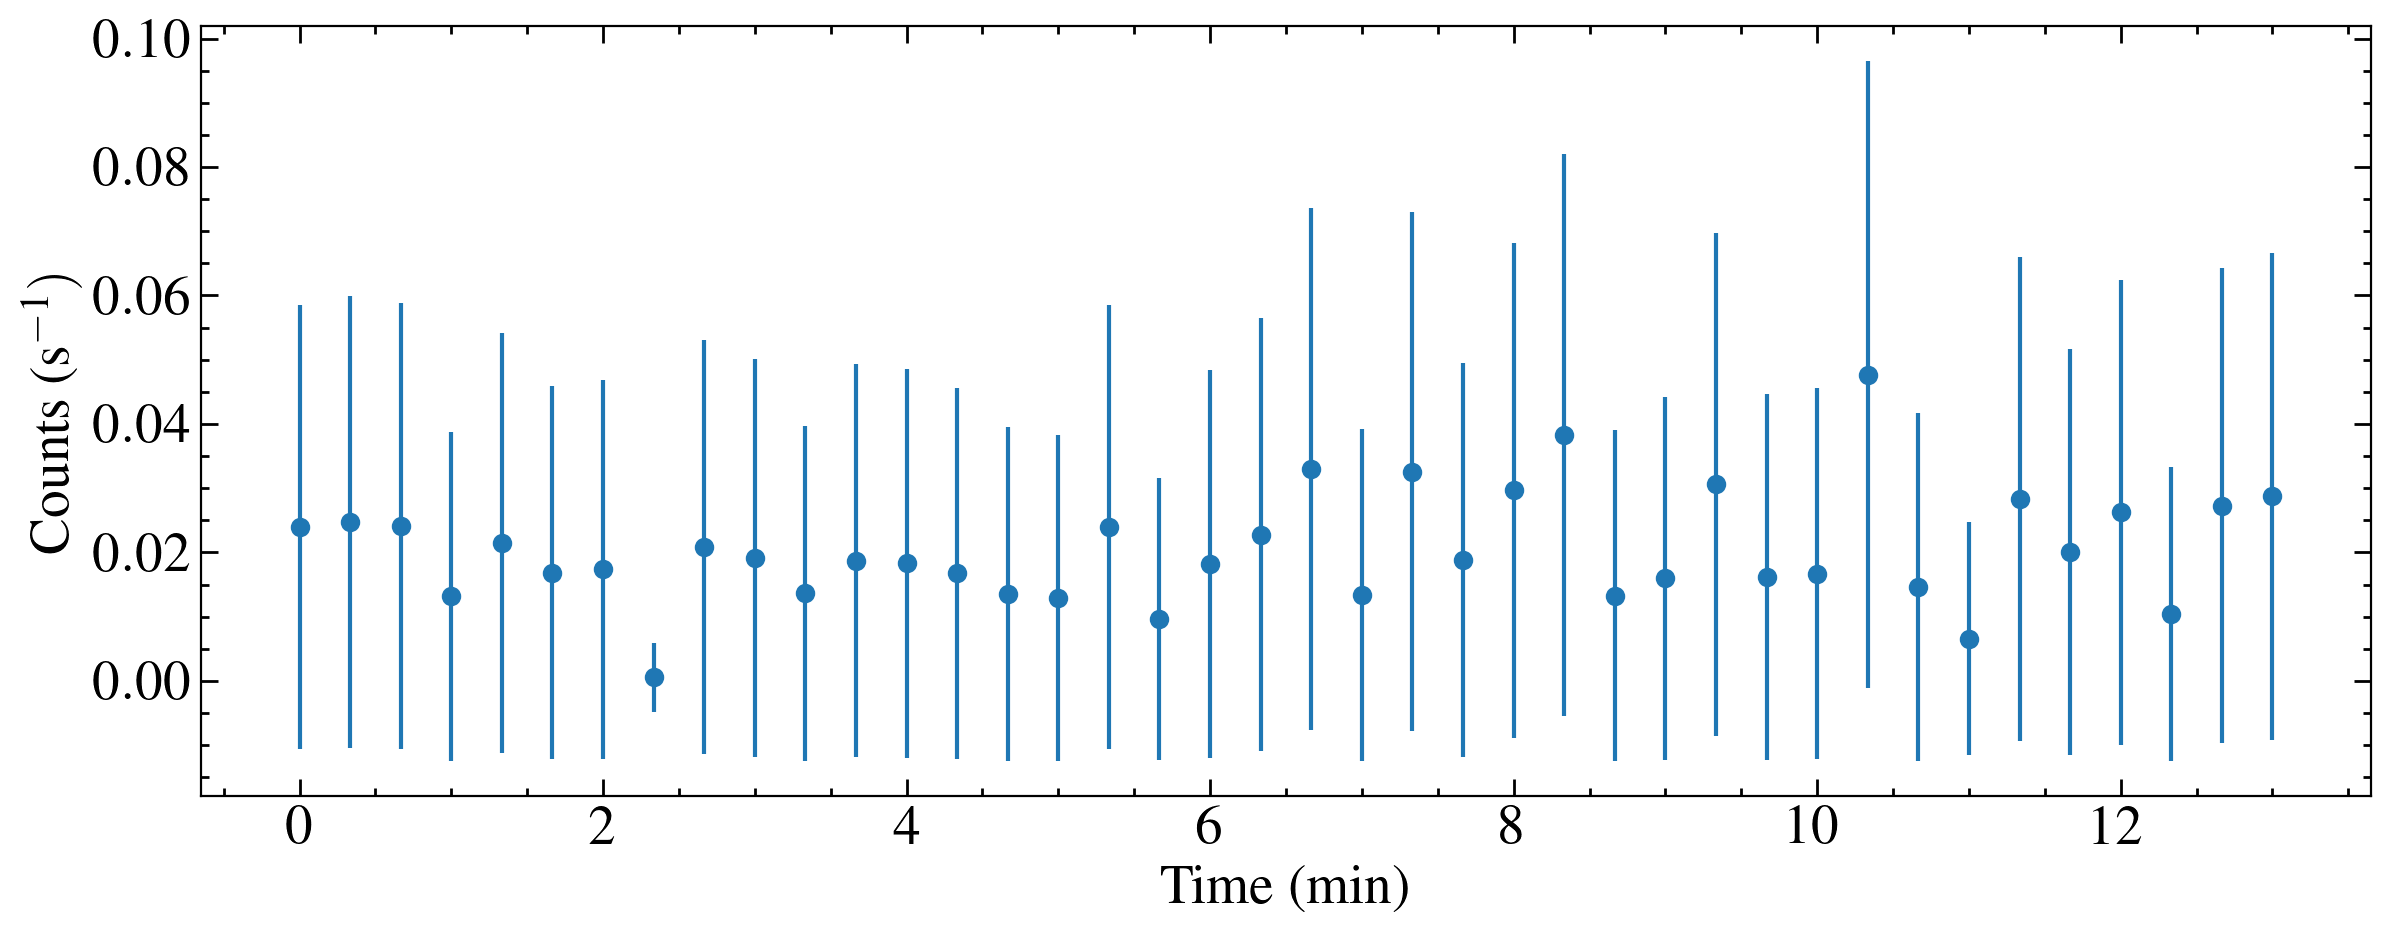

GJ15A


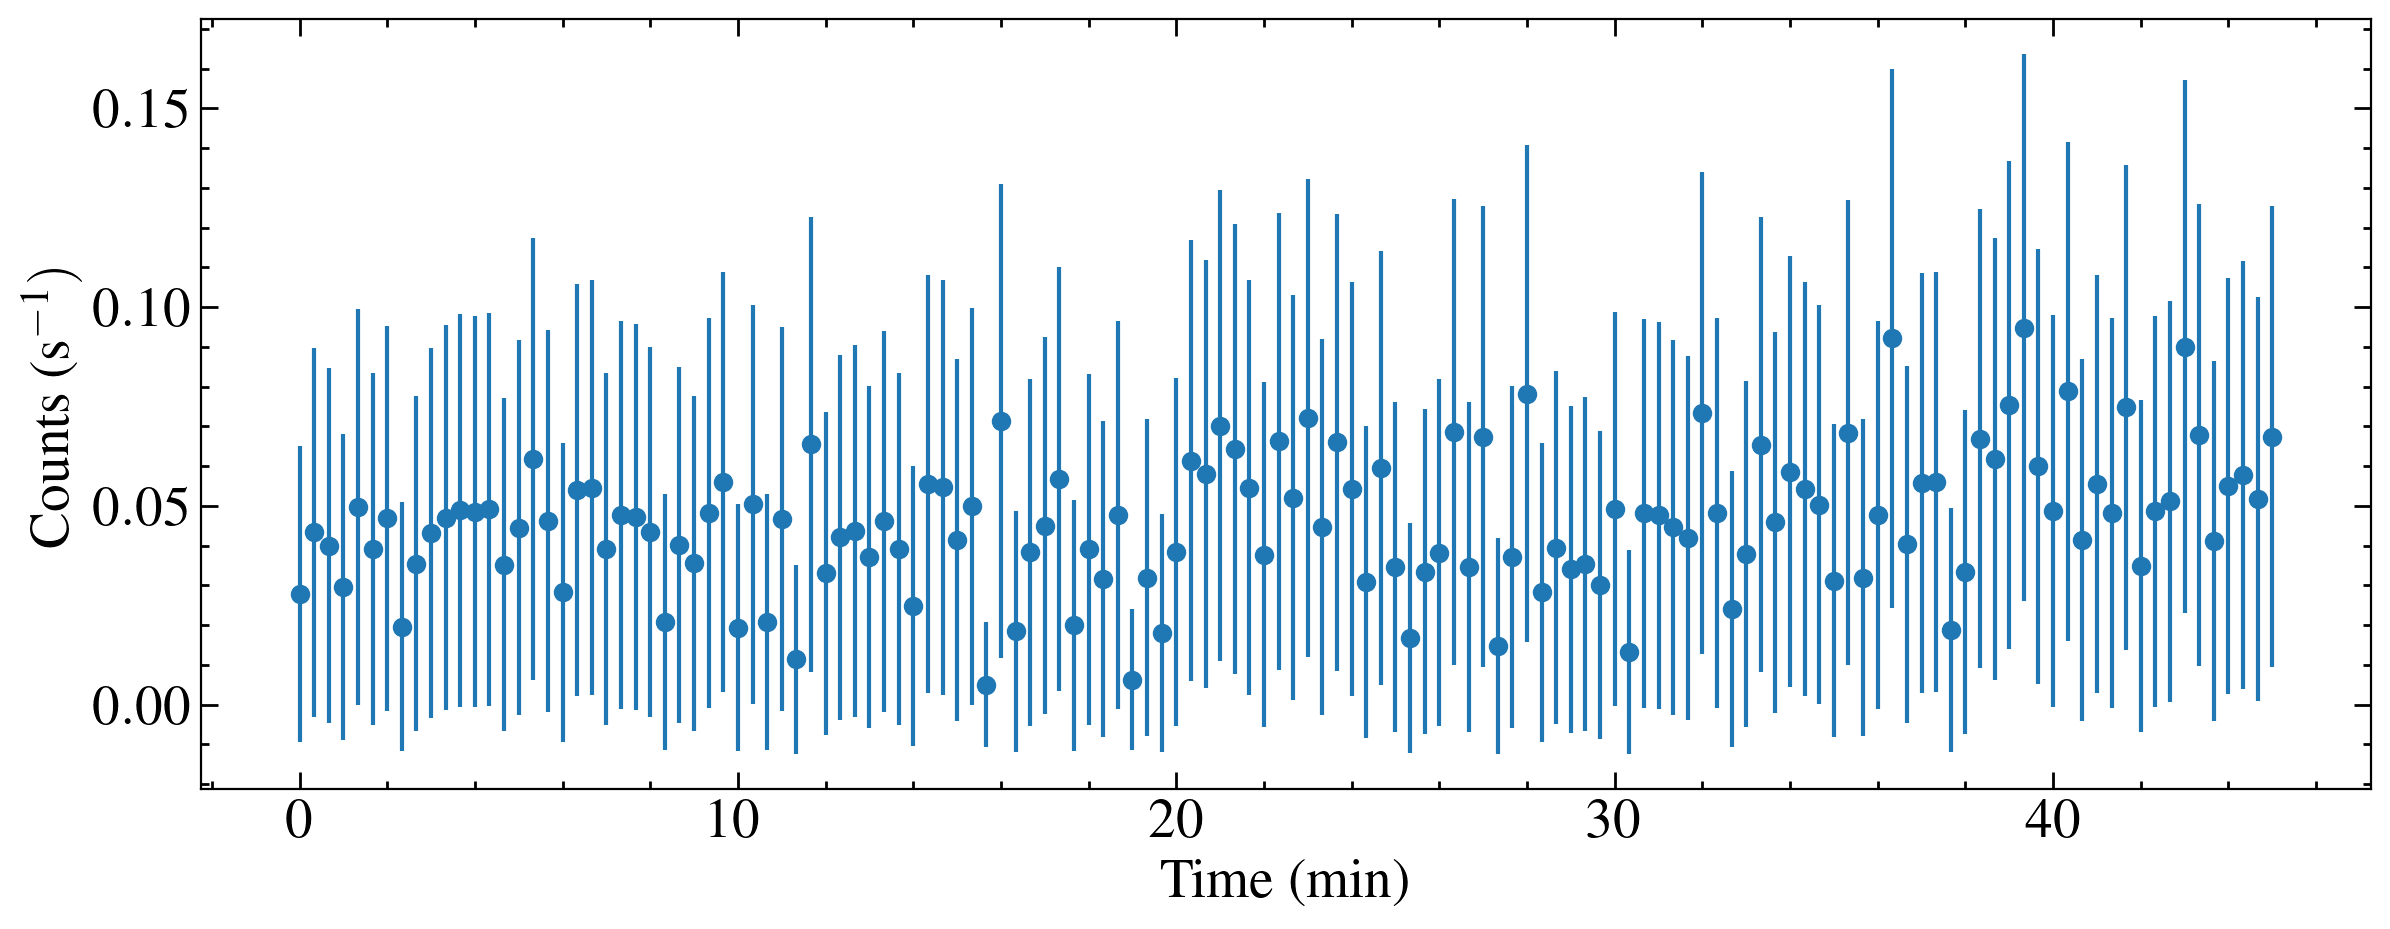

GJ15A


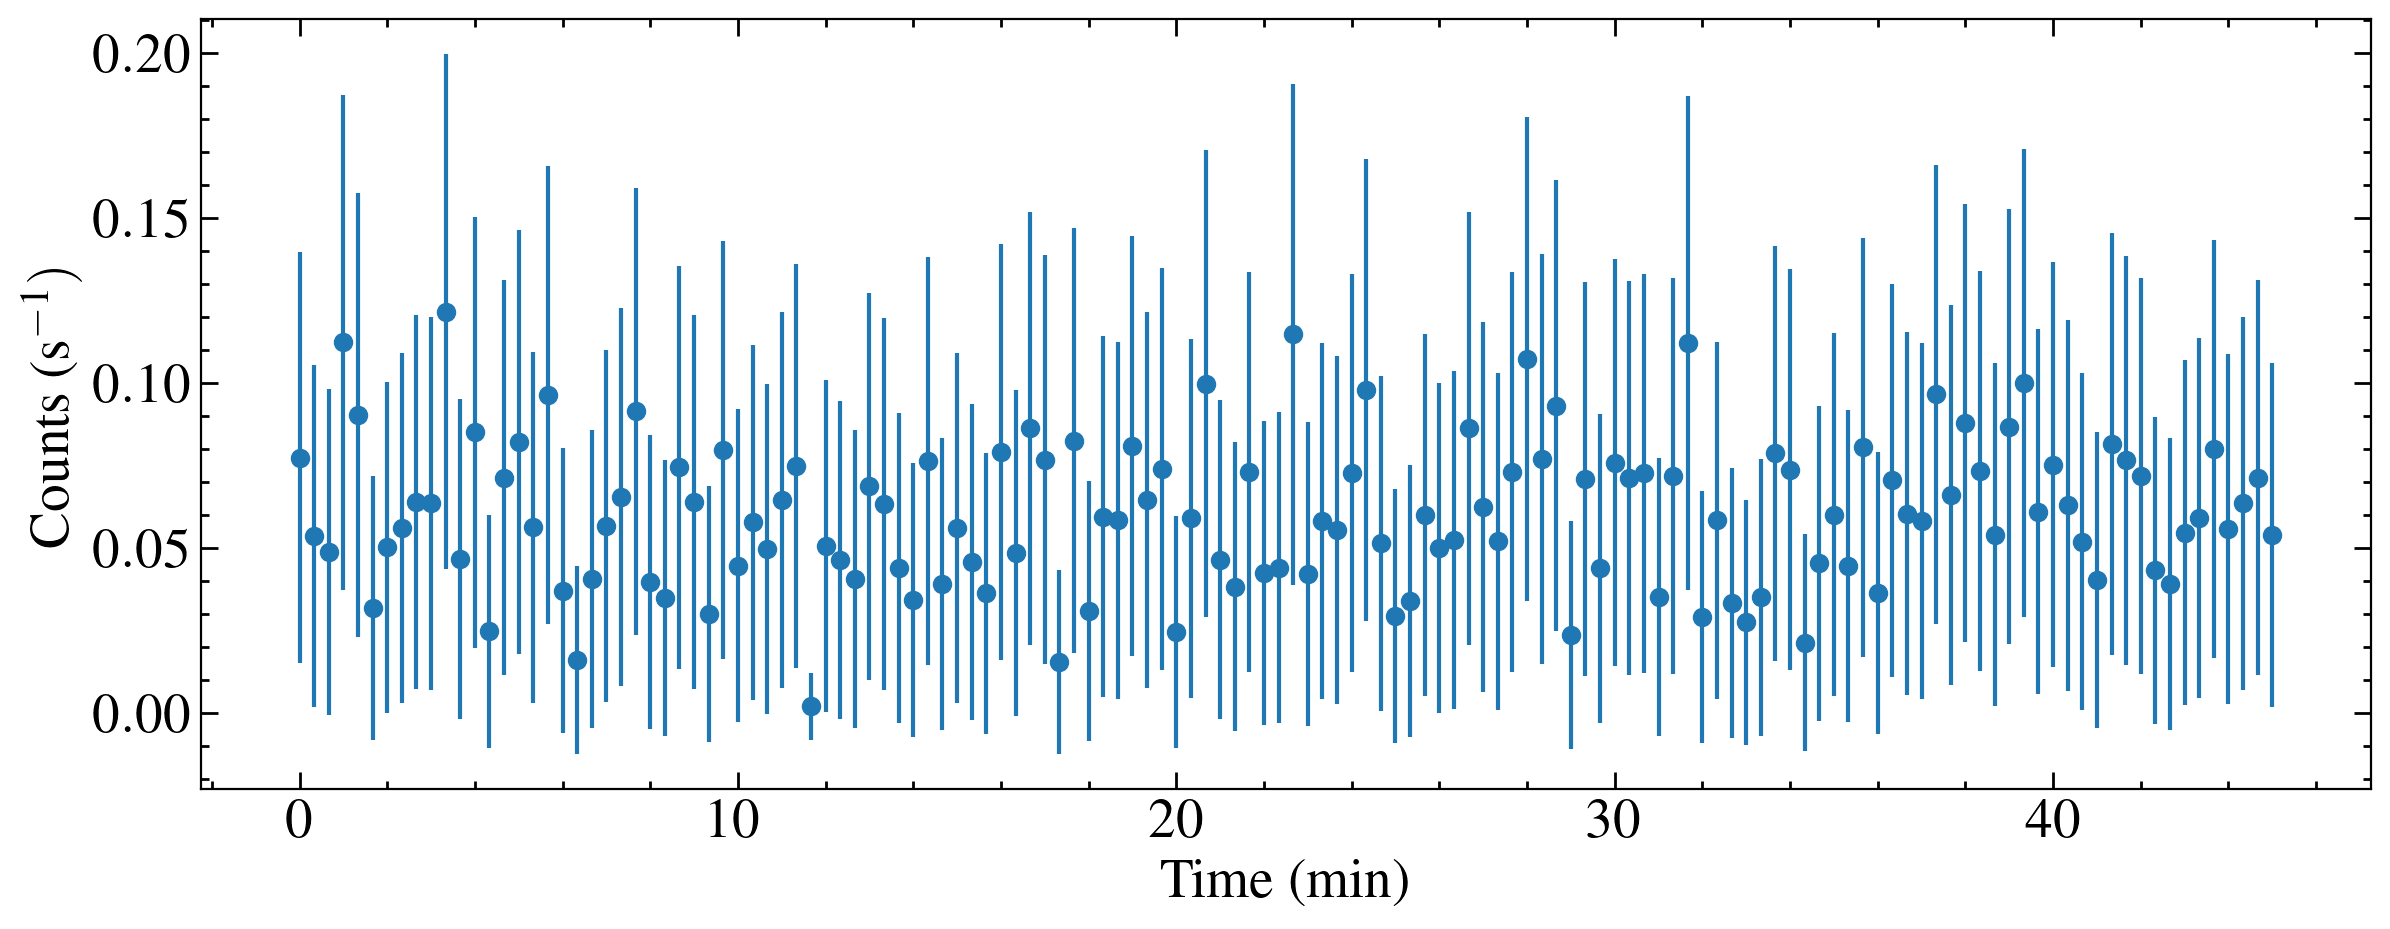

GJ15A


/tmp/ipykernel_22885/1980954059.py:41: RuntimeWarning: invalid value encountered in scalar power
  ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts


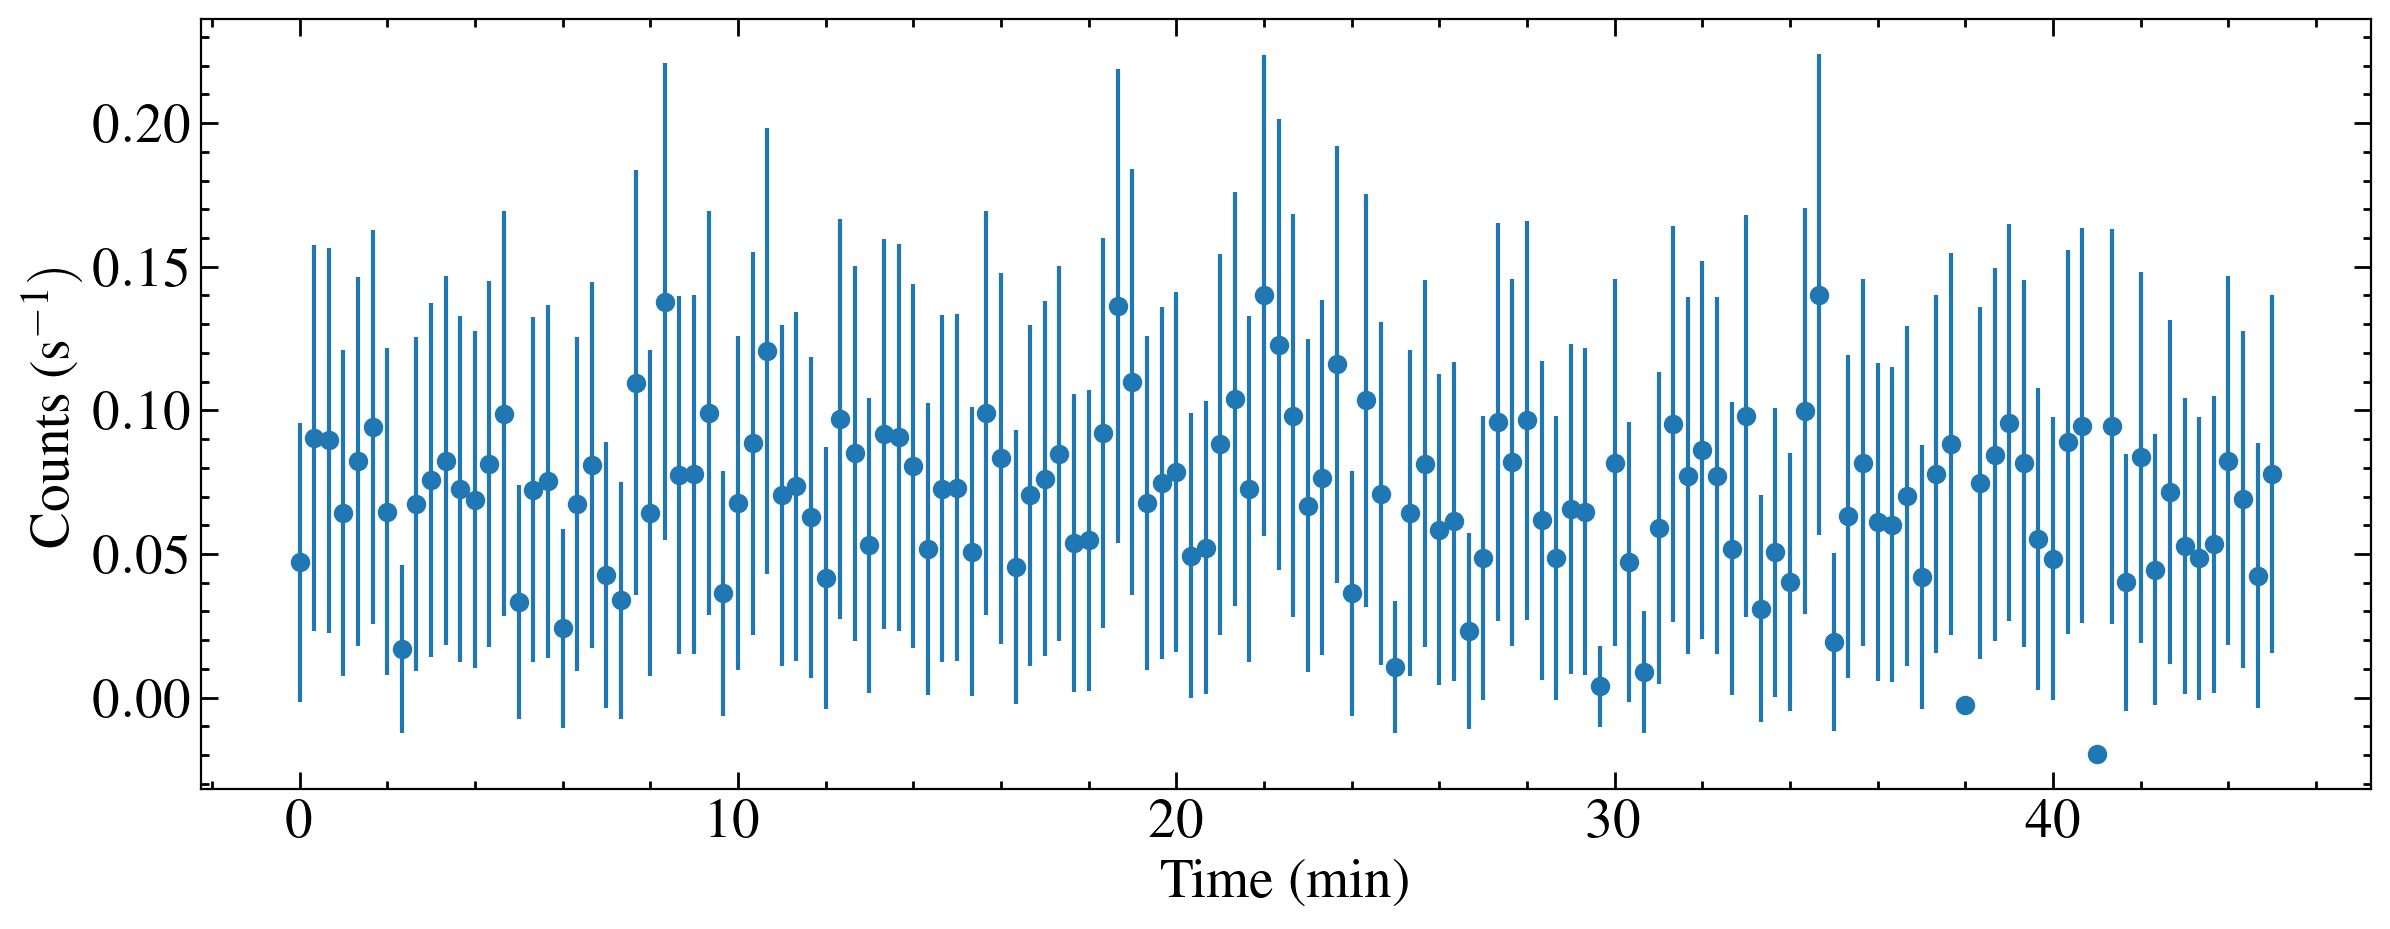

GJ15A


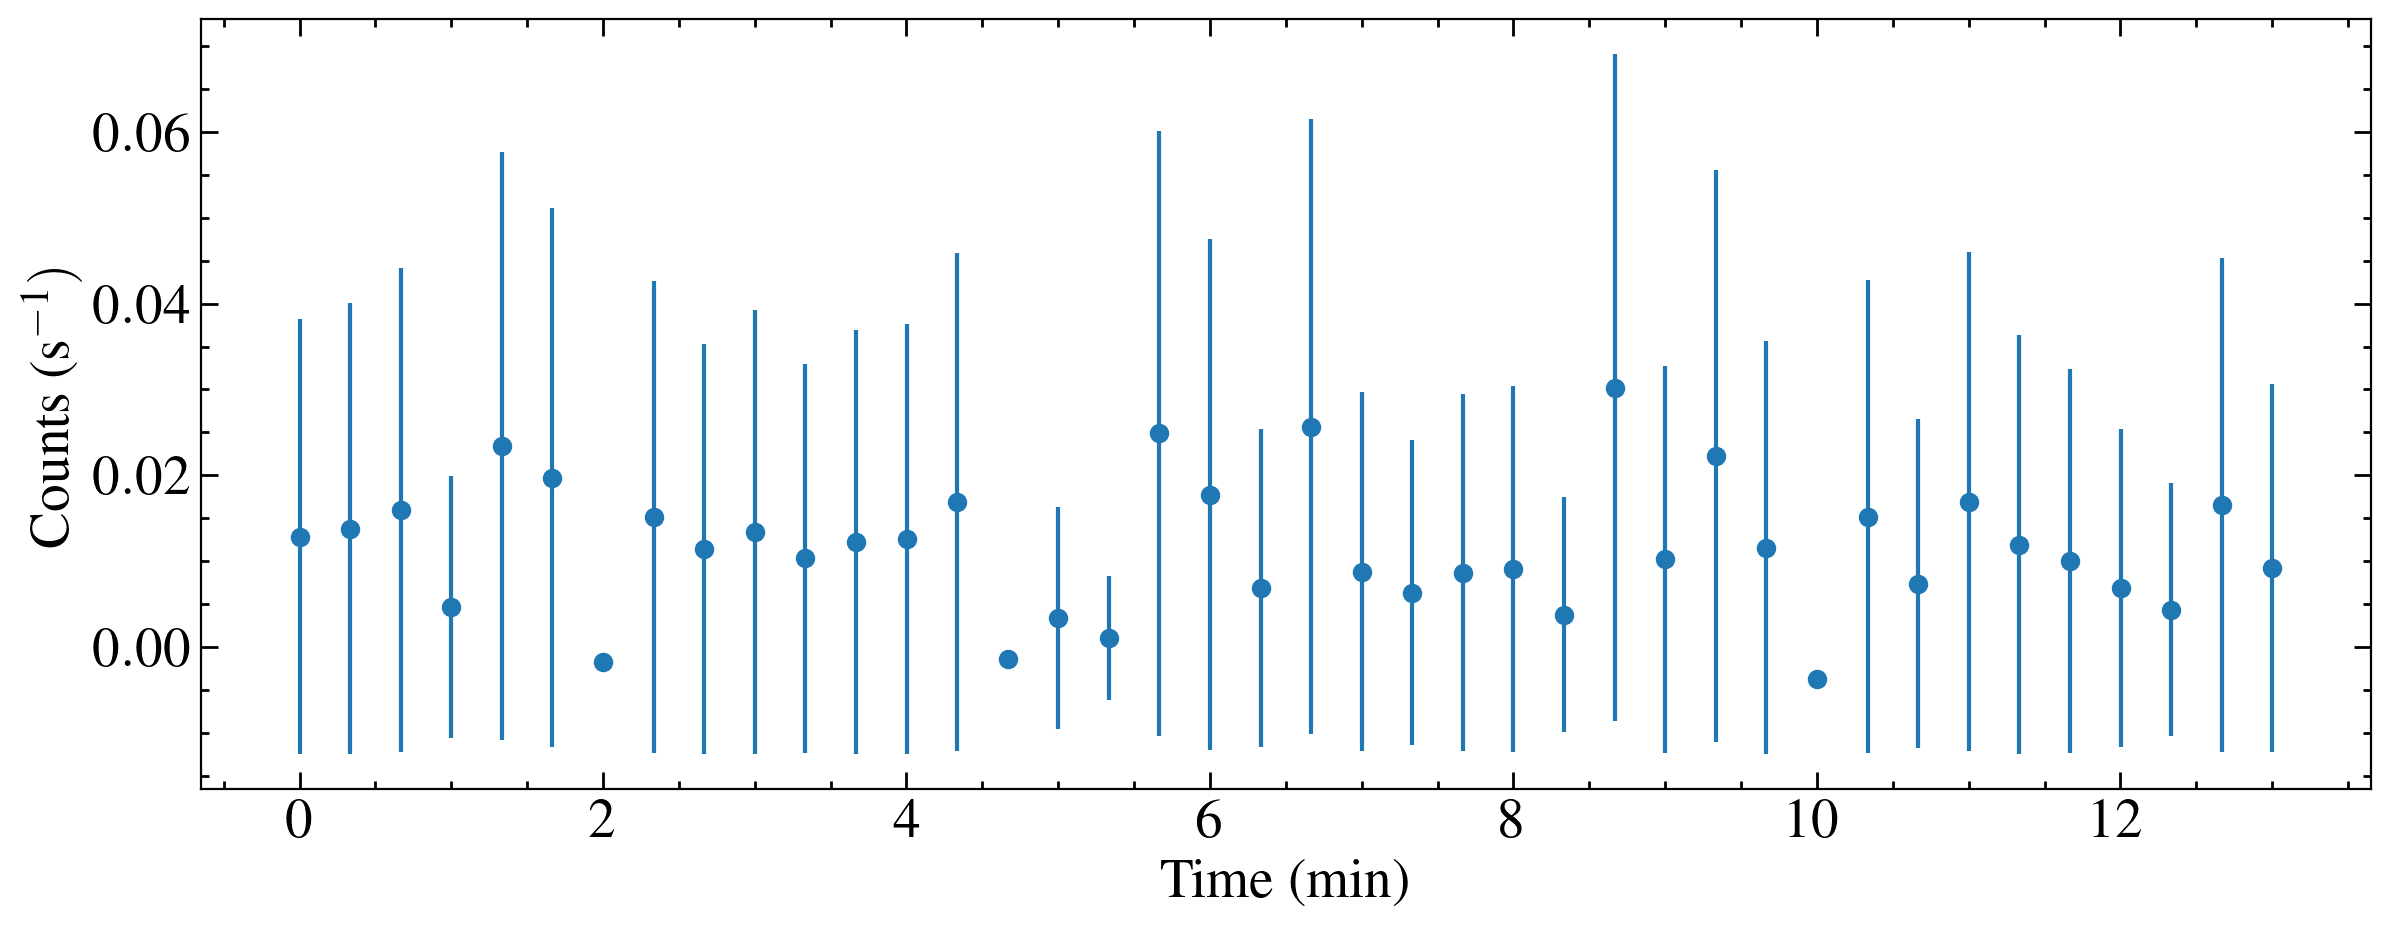

GJ15A


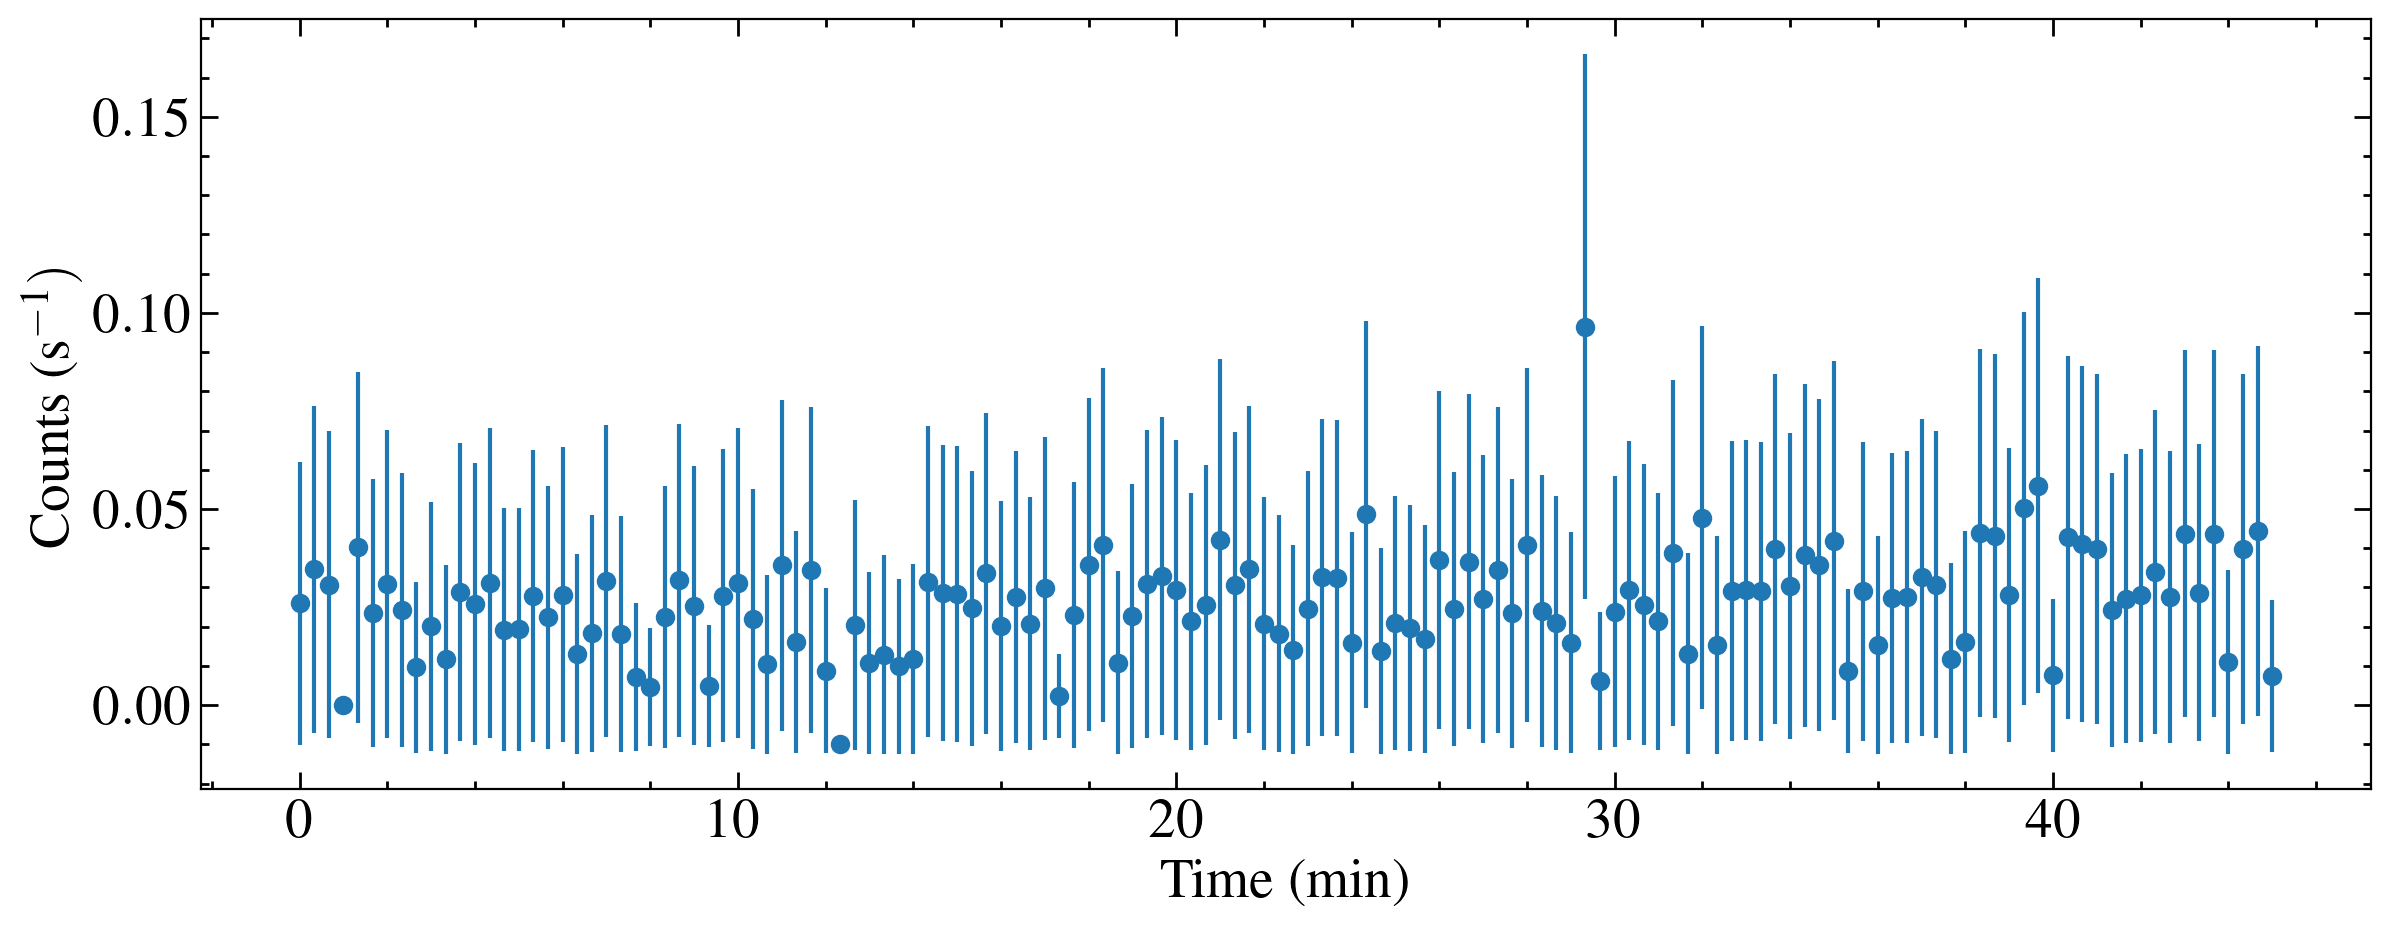

GJ15A


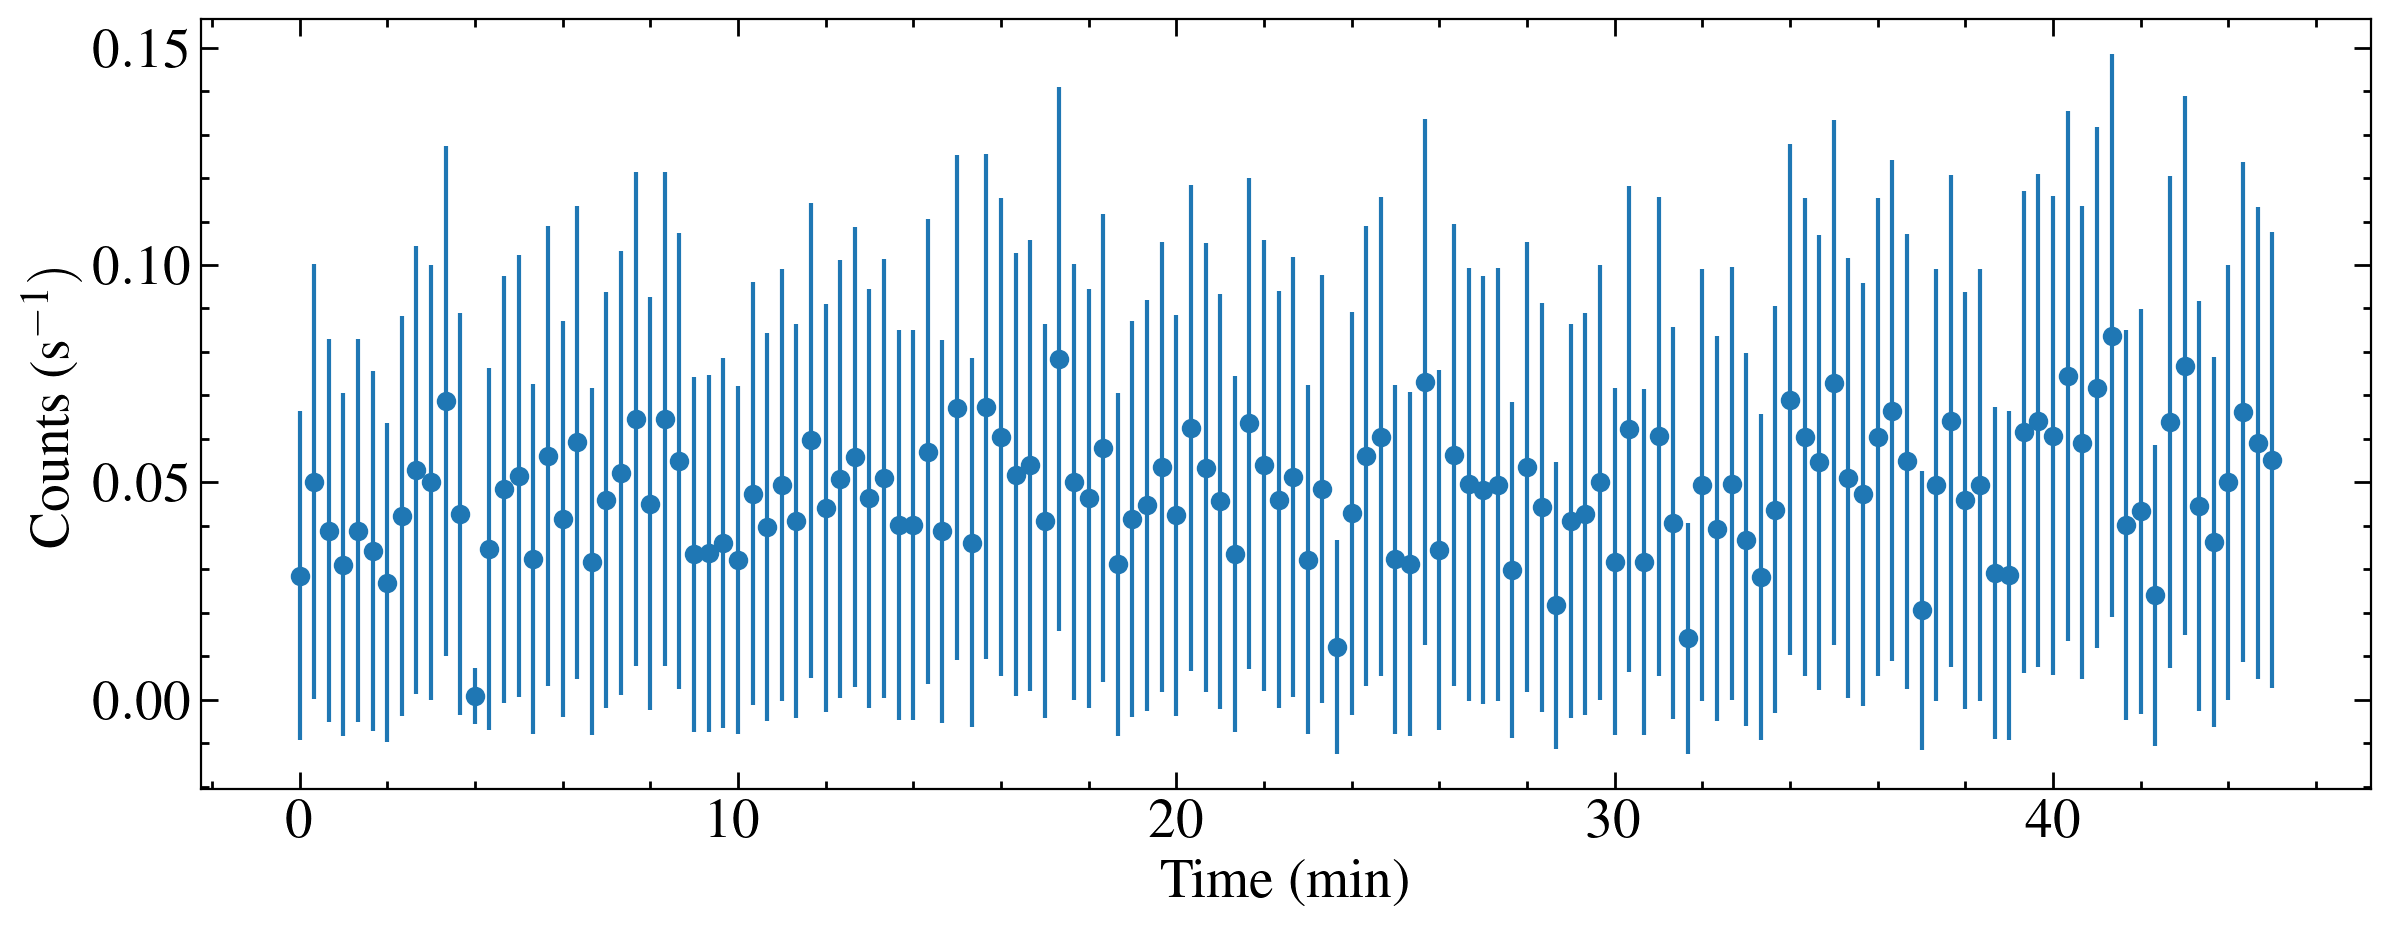

GJ15A


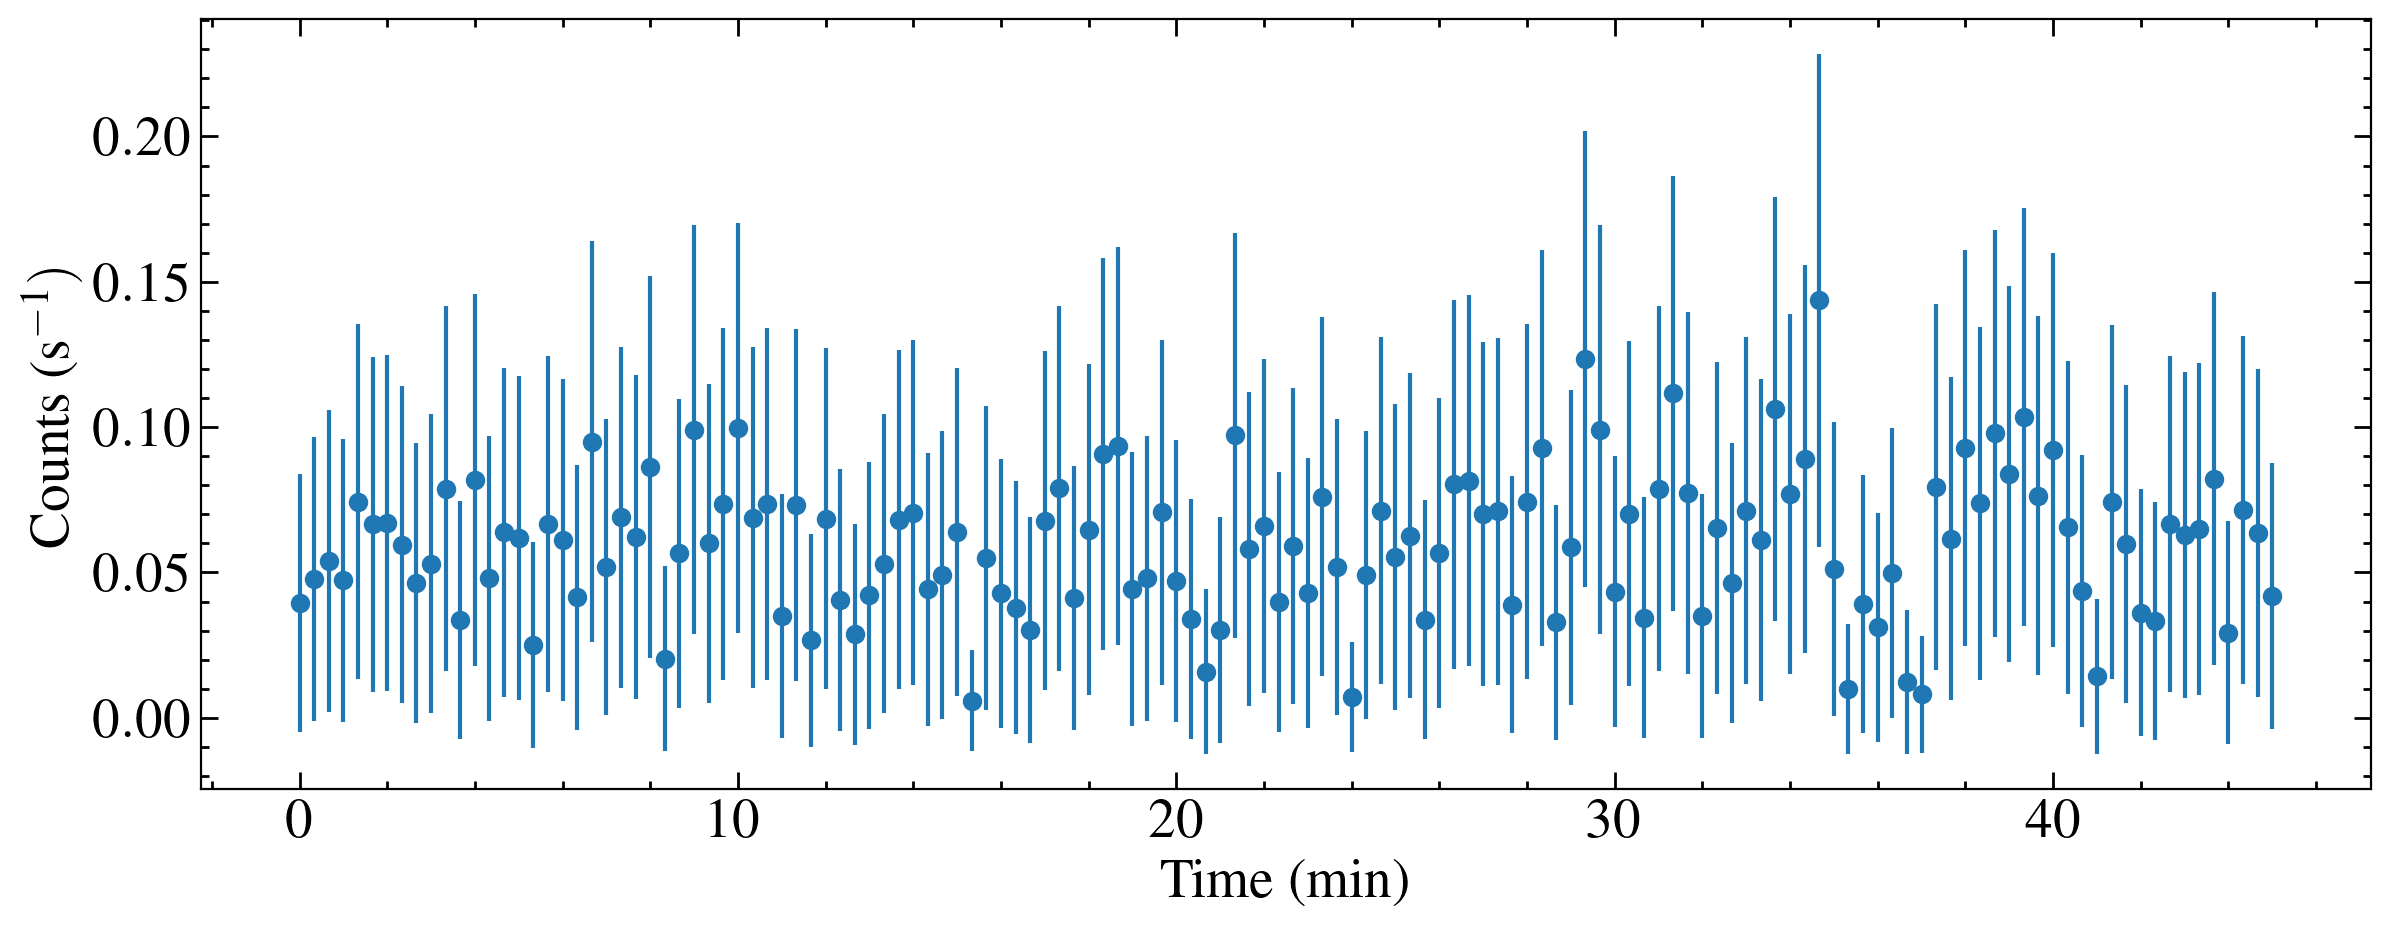

GJ729


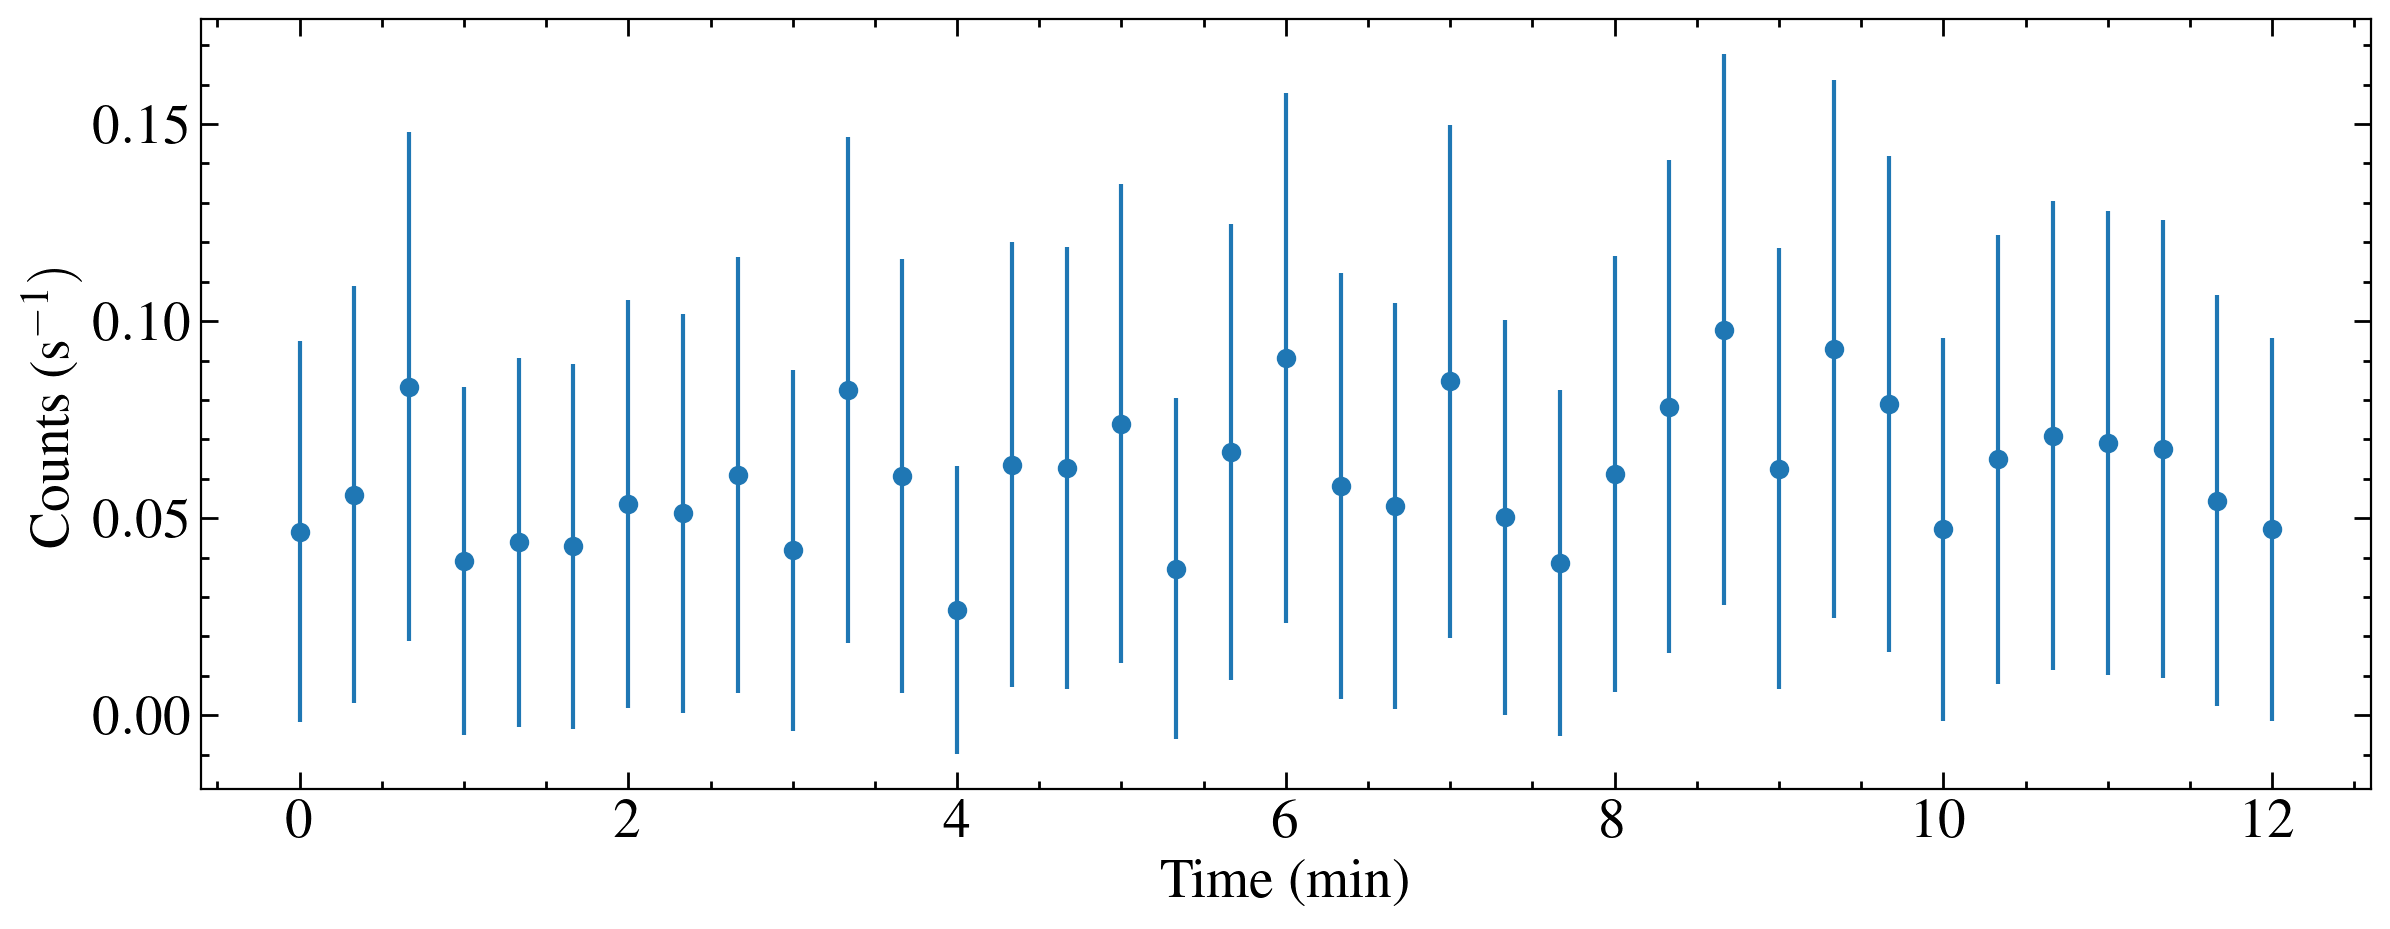

GJ729


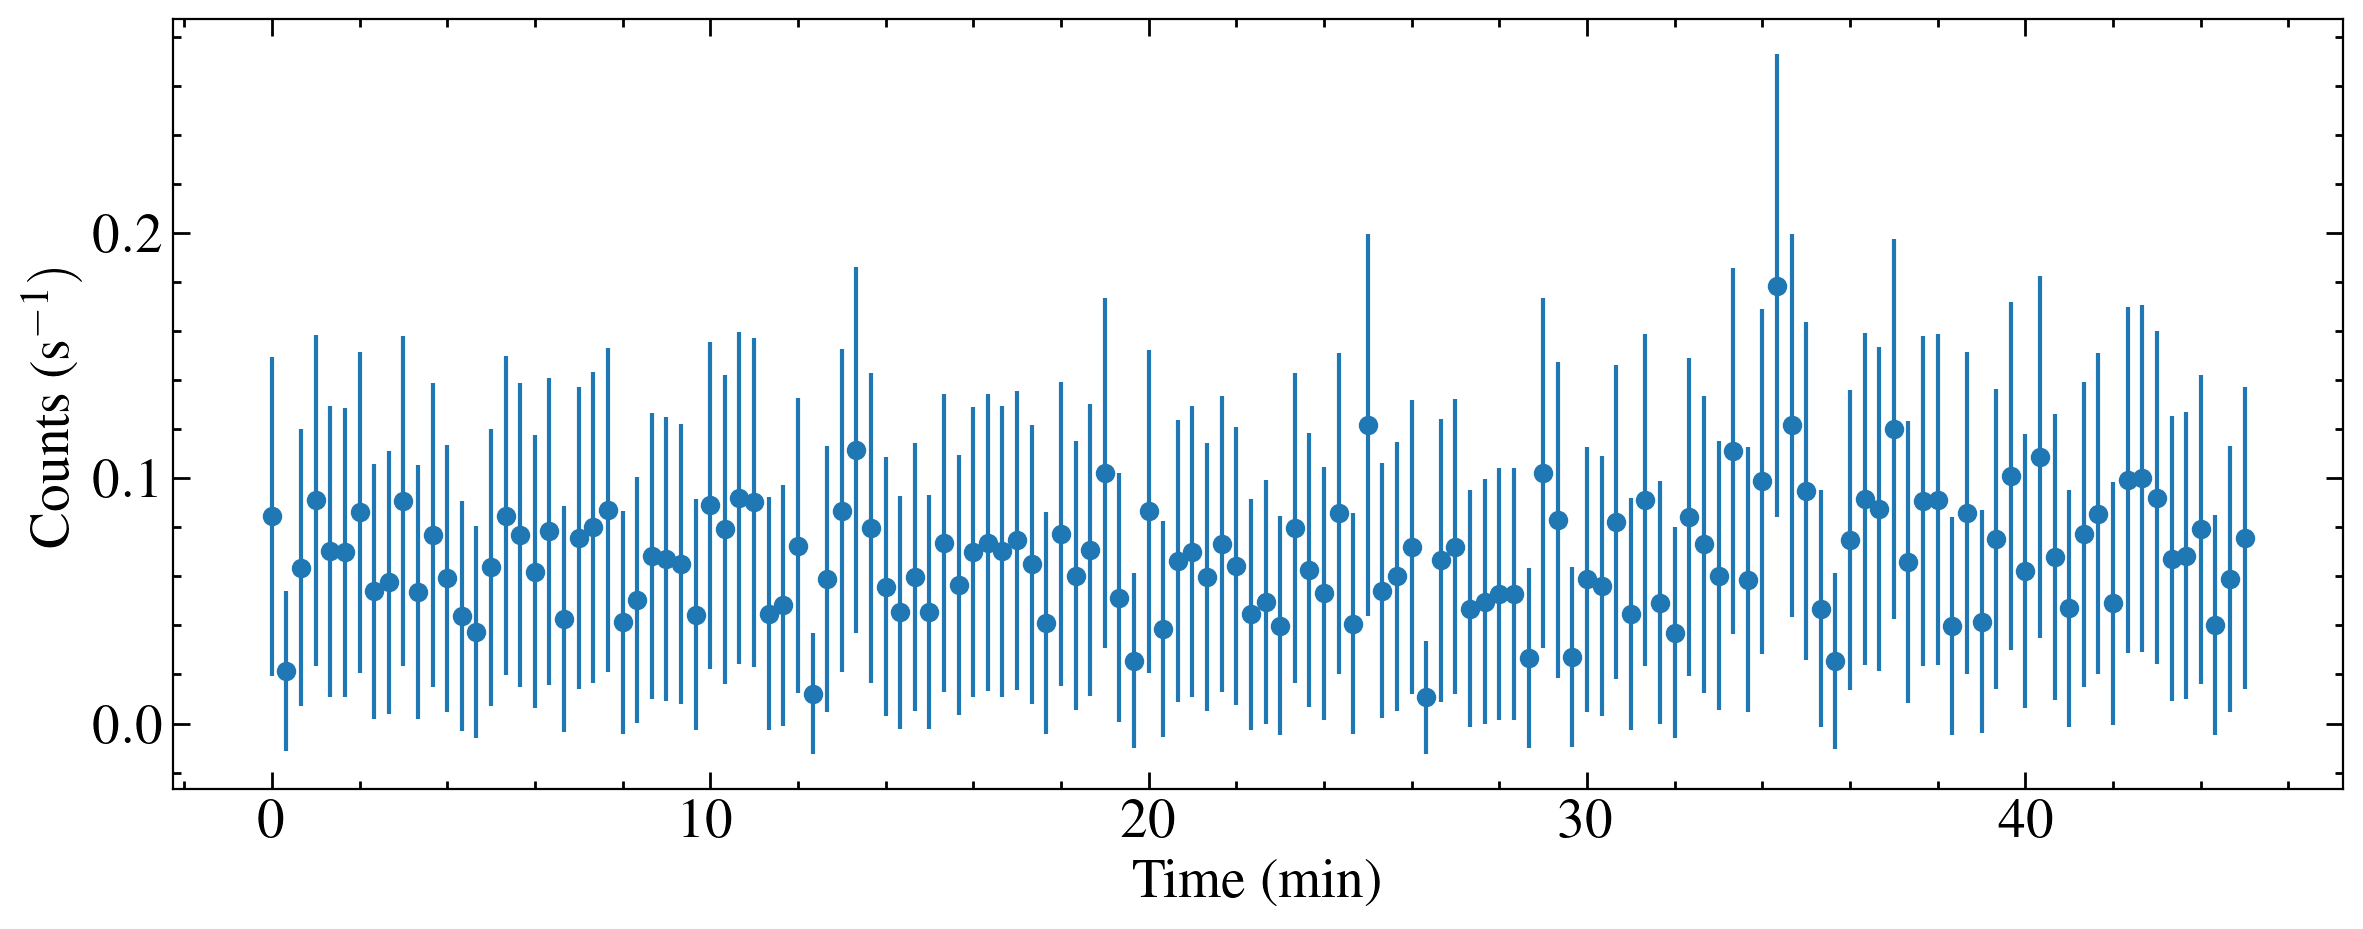

GJ729


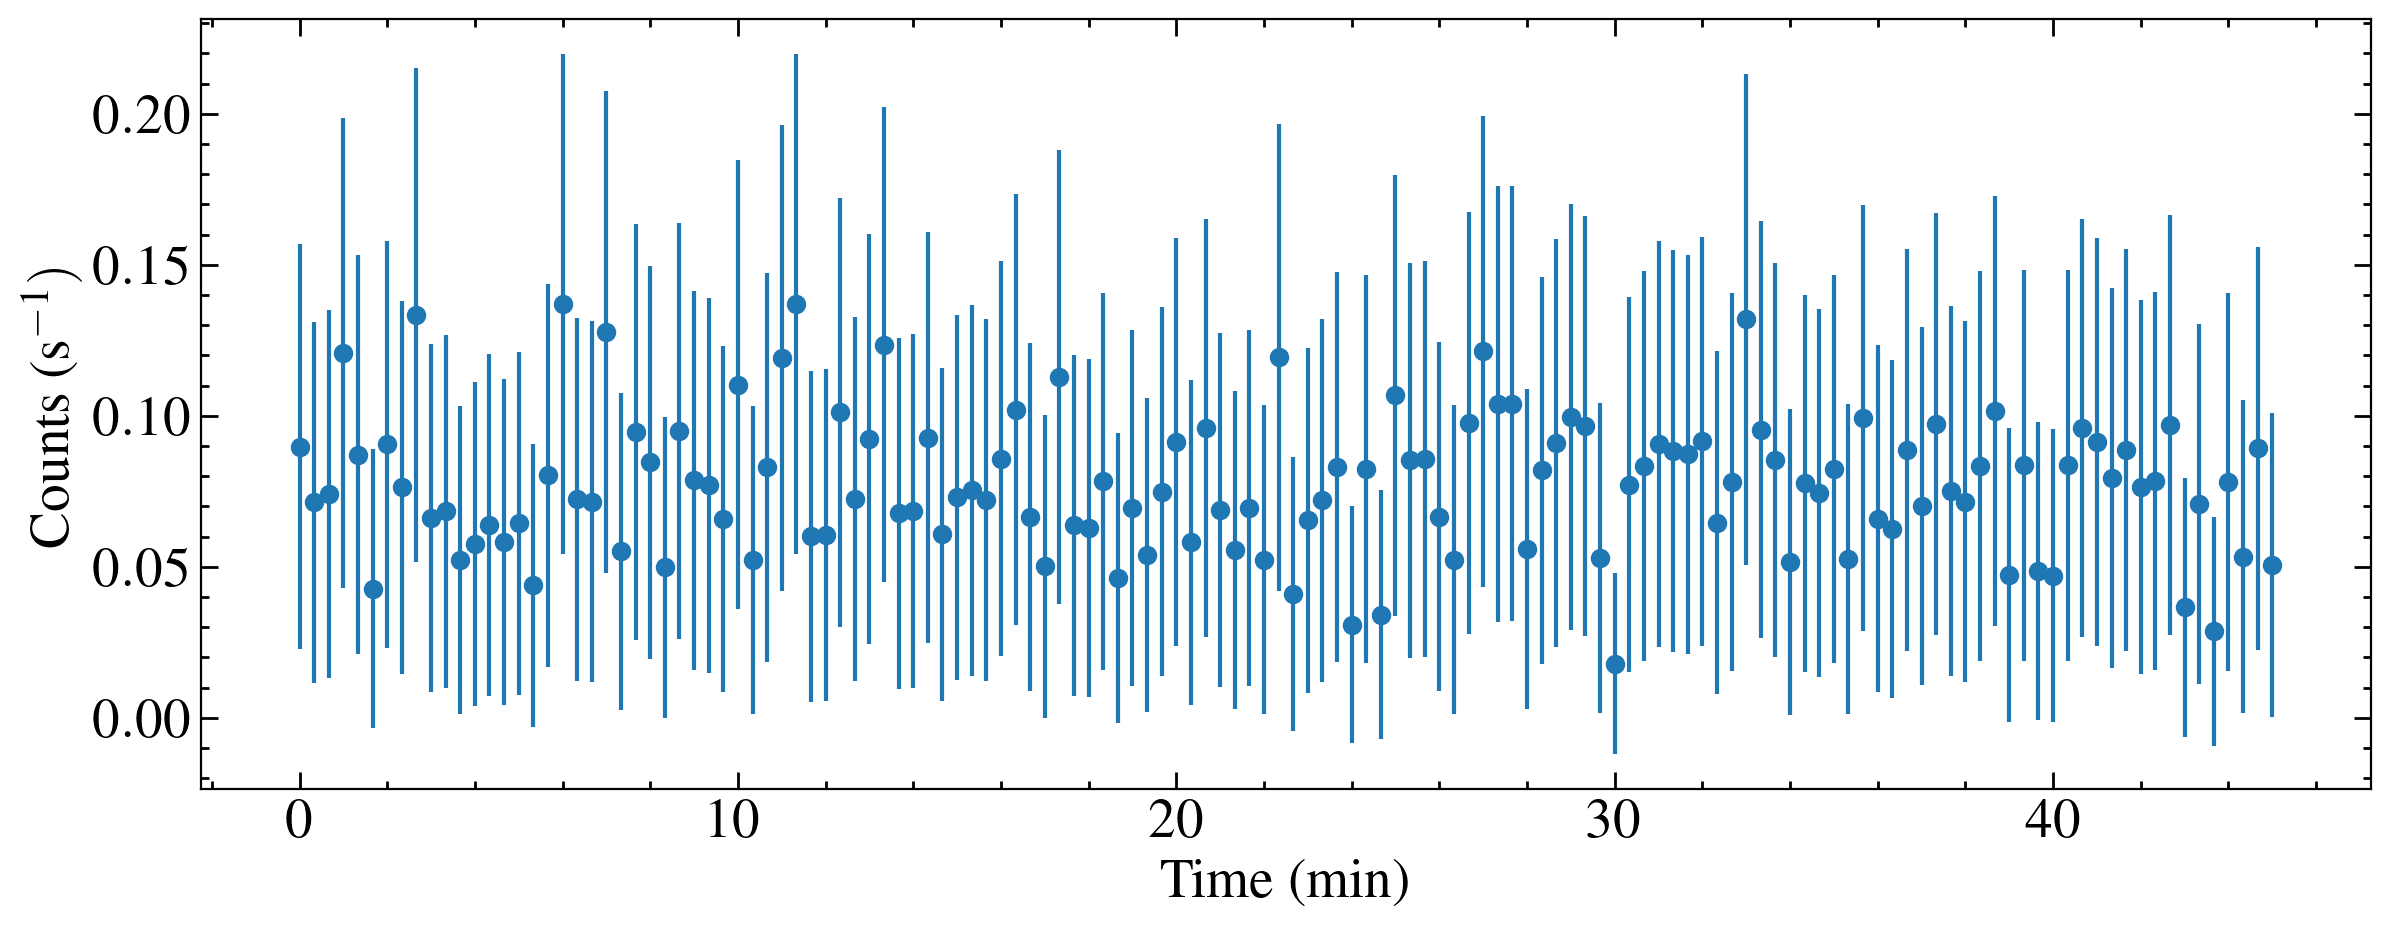

GJ729


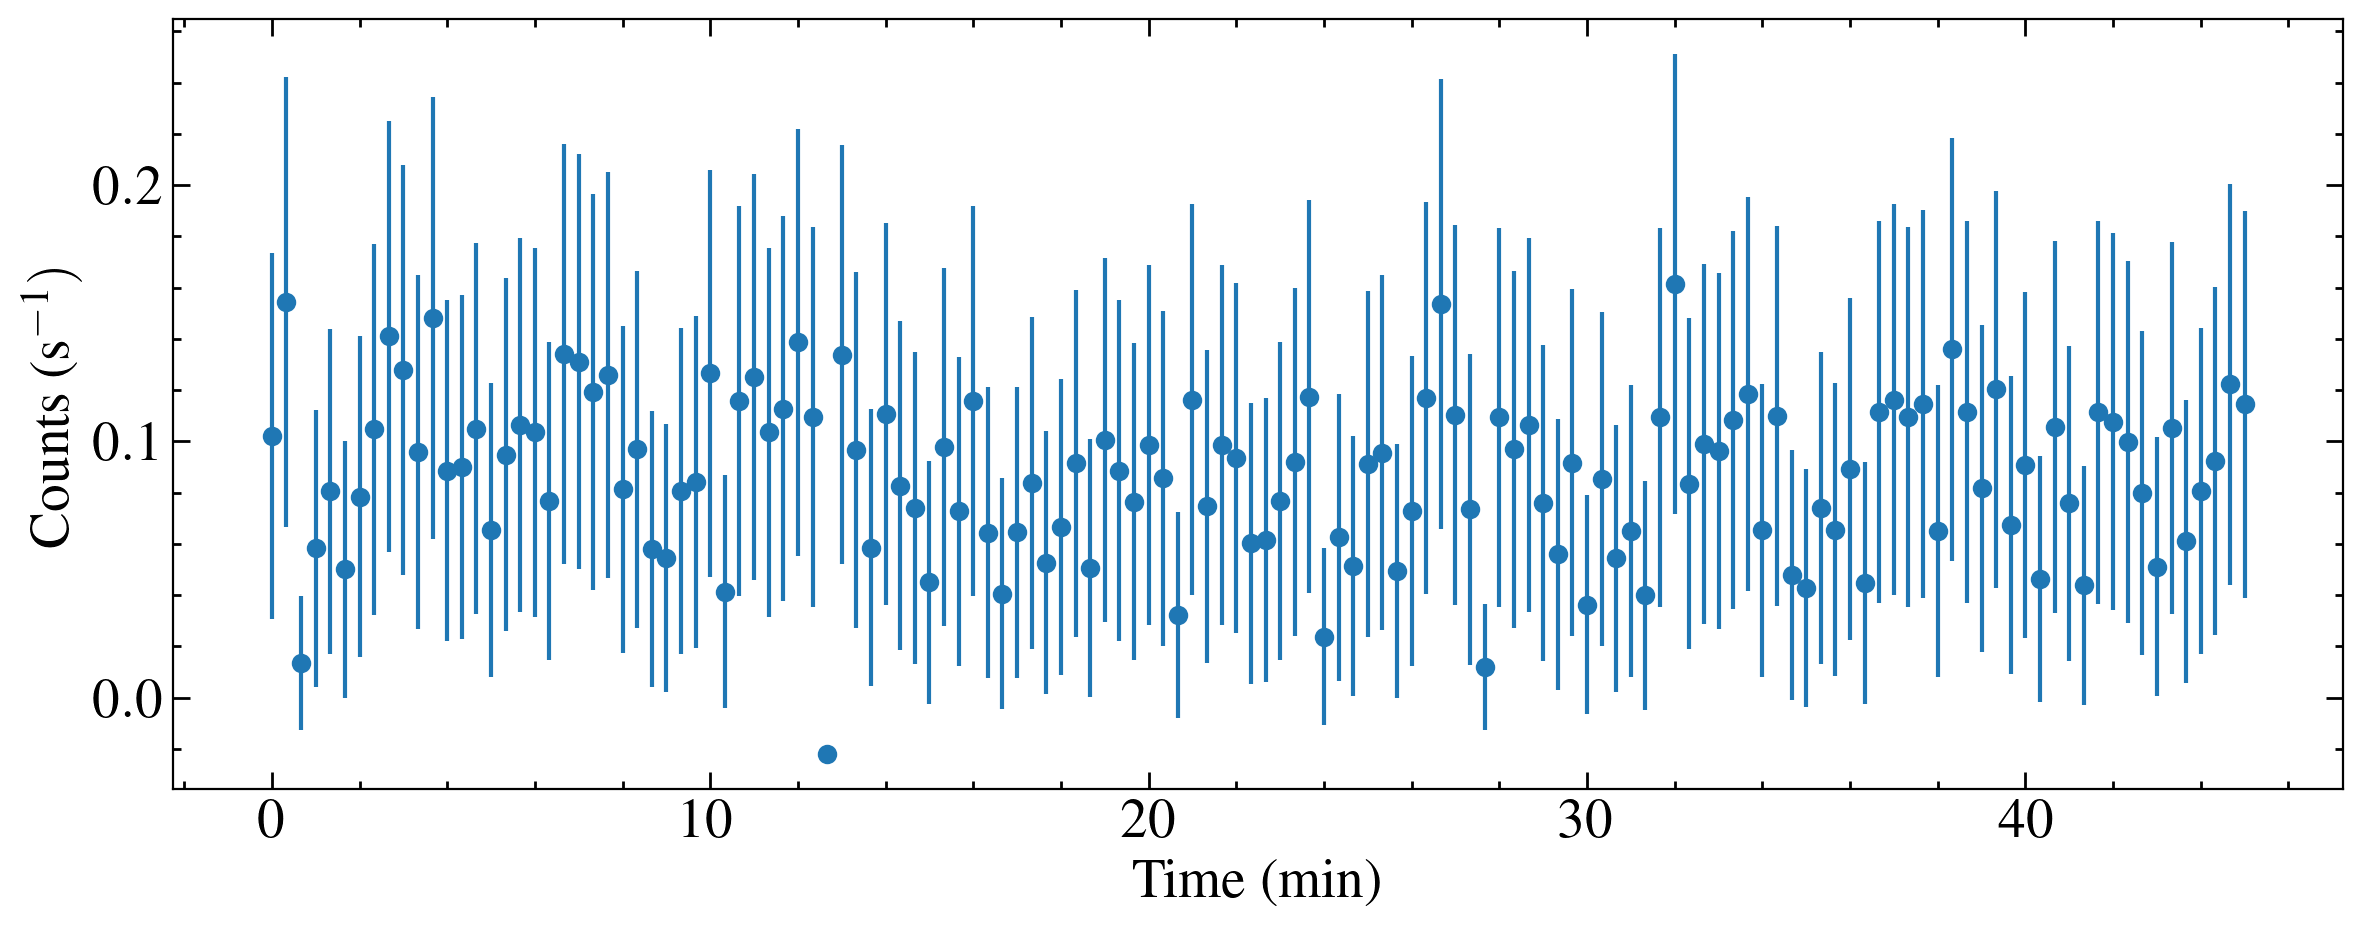

GJ729


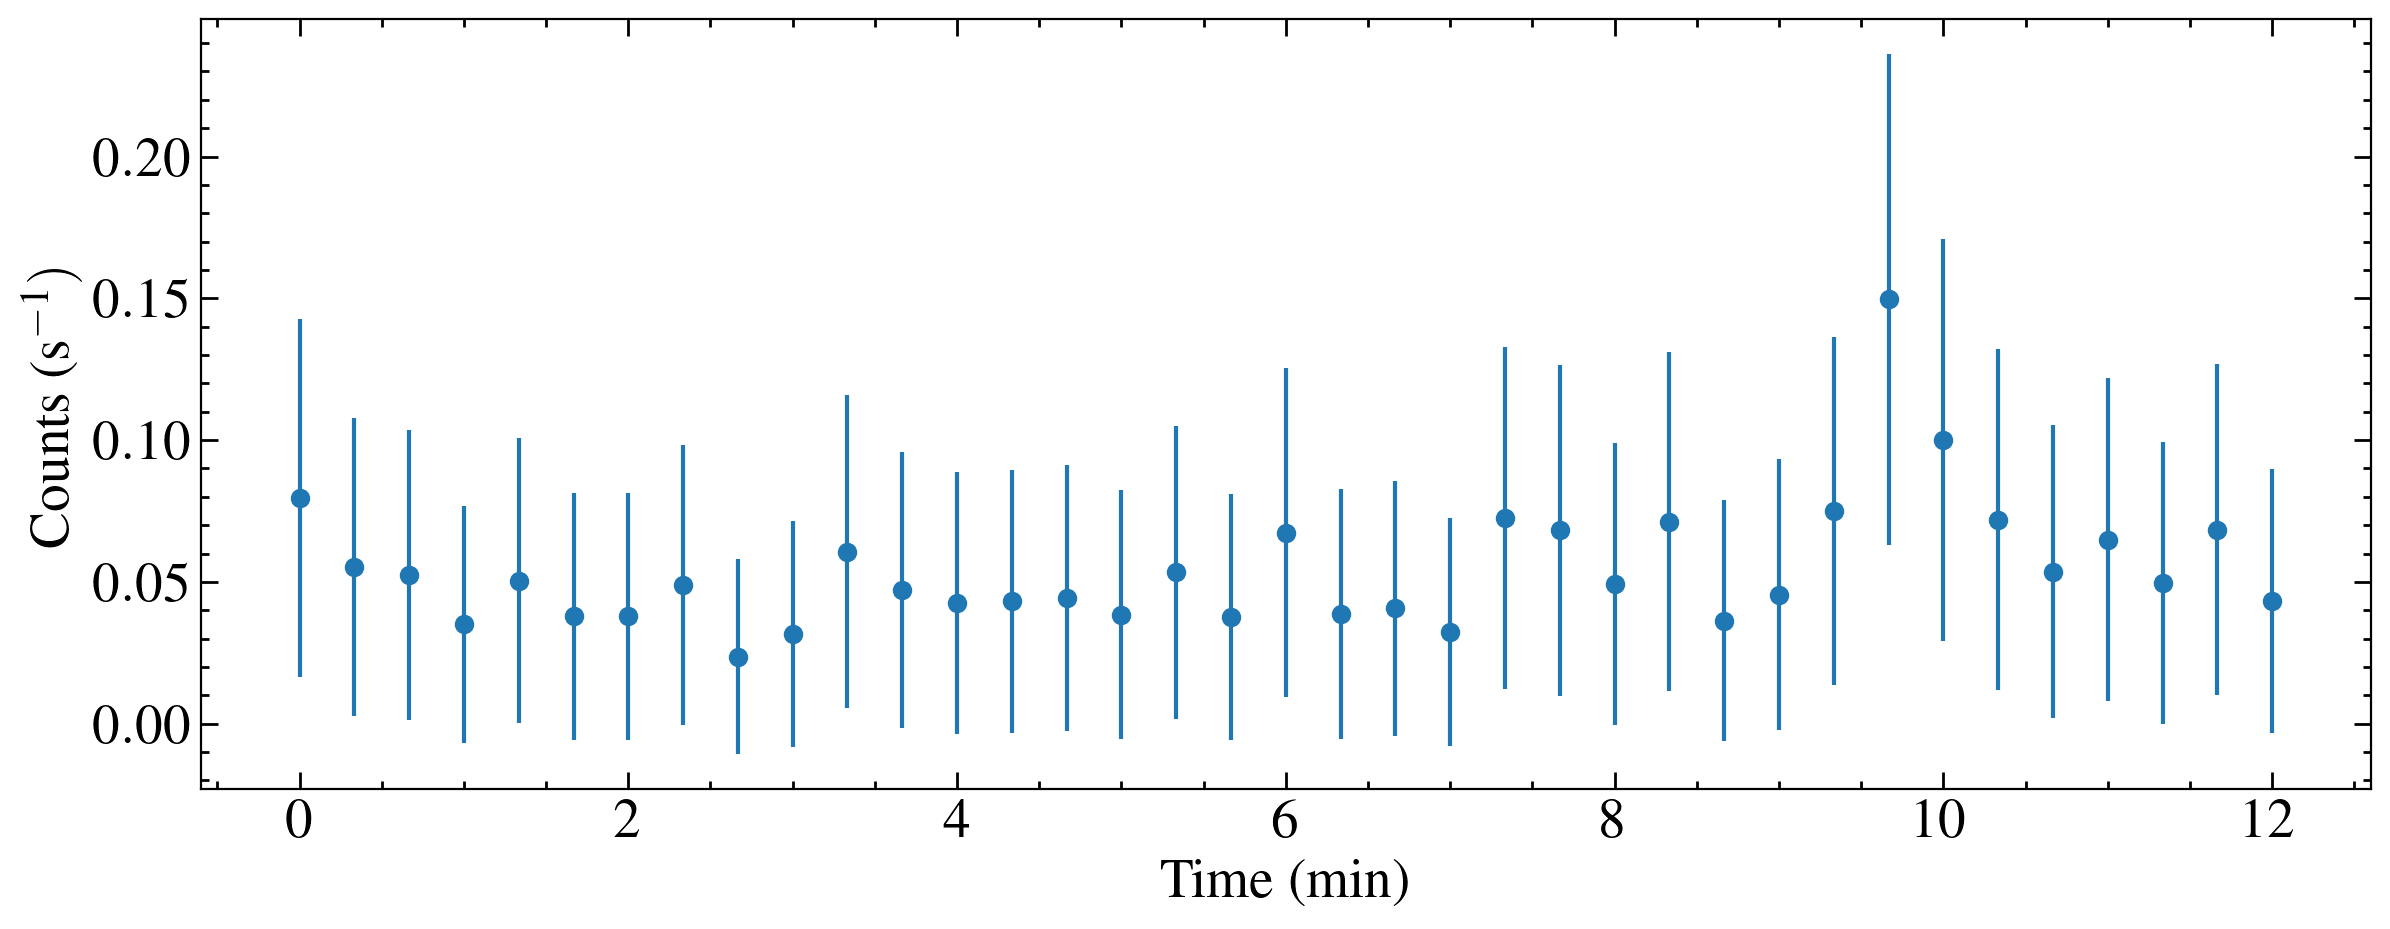

GJ729


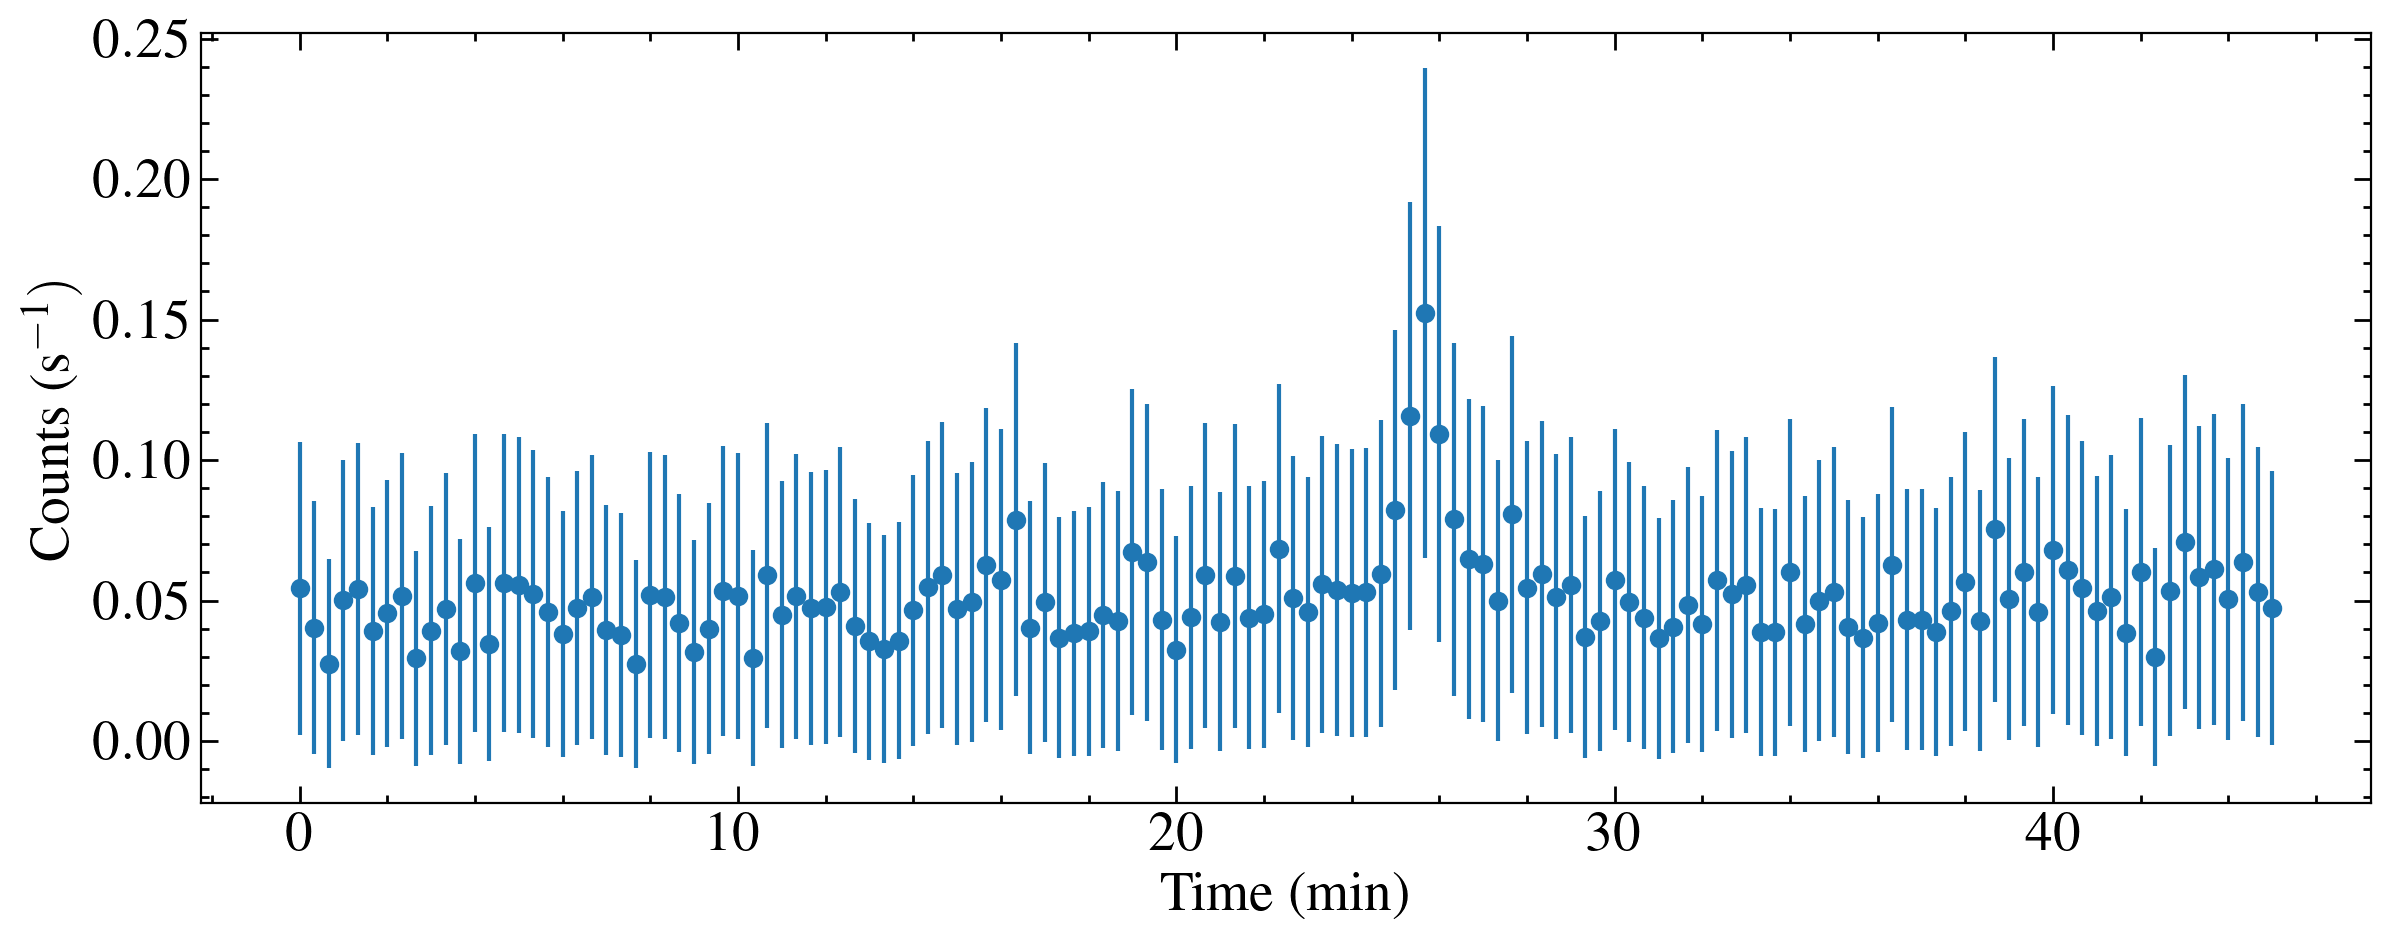

GJ729


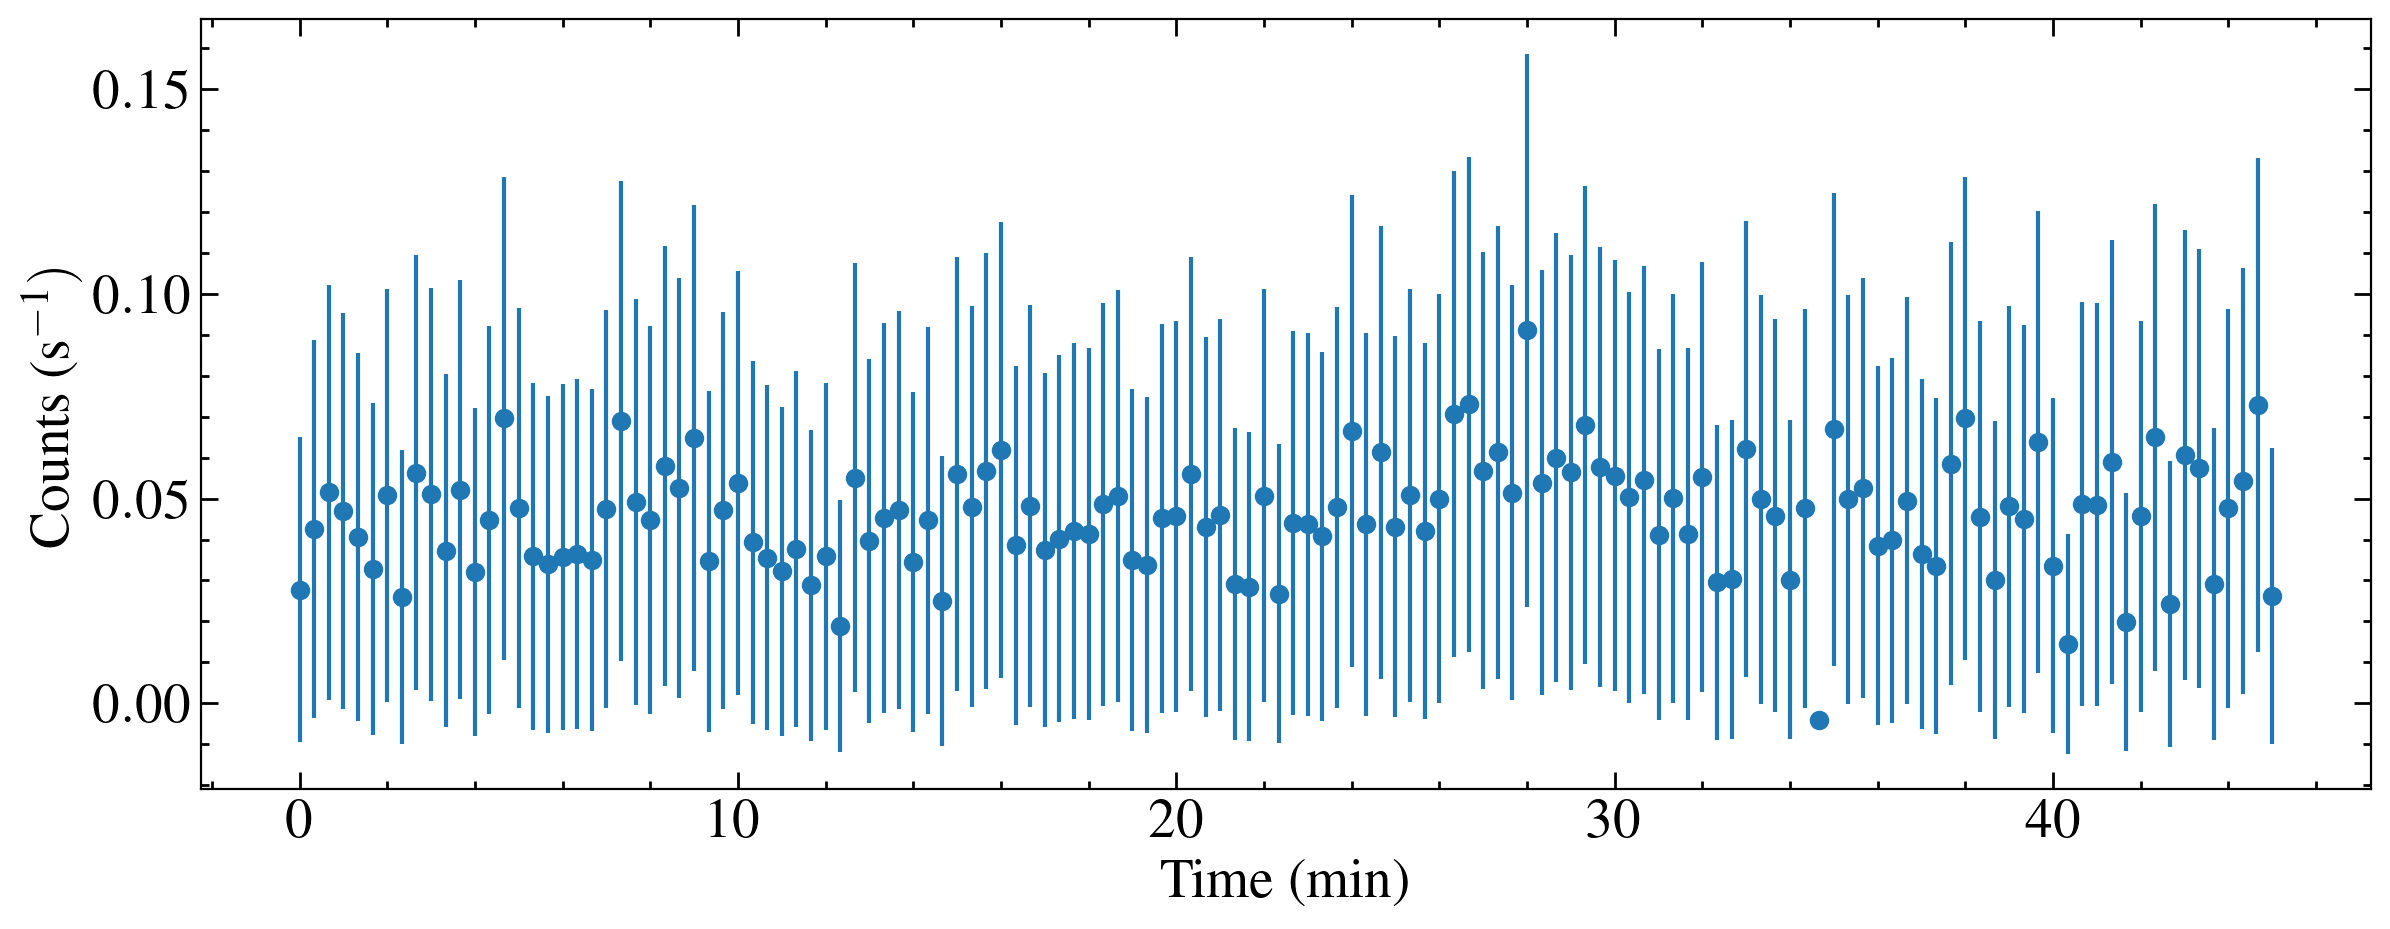

In [131]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

for x in new_x1ds:   
    fig, ax = plt.subplots()
    hdul = fits.open(x)
    print(hdul[0].header['TARGNAME'])
    time = []
    flux = []
    error = []
    error_sqrt = []
    hdul = fits.open(x)
    band = [1230, 1700]
    for ext in hdul[1::]:
        hdr = ext.header
        ti = (hdr['EXPSTART']+hdr['EXPEND'])/2 #work out the mid-point of the time bin and add it to the time array
        time.append(ti)
        data = ext.data
        if grating == 'e140m': 
            w, f, e , dq = (data['WAVELENGTH'], data['NET'], data['NET_ERROR'], data['DQ'])
            w, f, e , dq = echelle_coadd_dq(w, f,e, dq, nclip =10, find_ratio =False)
        else:
            data = data[0]
            w, f, e , dq = (data['WAVELENGTH'], data['NET'], data['NET_ERROR'], data['DQ'])
        #w, f, e , dq = (data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']) #uncomment this line for flux-calibrated light curves
        w0, w1 = wavelength_edges(w) 
        mask  = (w > band[0]) & (w < band[1]) & (dq == 0)
        w, w0, w1, f, e = w[mask], w0[mask], w1[mask], f[mask], e[mask]
        fi = np.sum(f*(w1-w0))
        ei = (np.sum(e**2 * (w1-w0)**2))**0.5
        flux.append(fi)
        error.append(ei)
        ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts 
        error_sqrt.append(ei) #better approach for these low-signal spectra
        
        
    
    hdul.close()    
    time, flux, error = np.array(time), np.array(flux), np.array(error)
    t0 = time[0]
    tplot = ((time - t0)*u.d).to(u.min)
    # ax.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
    ax.errorbar(tplot, flux, yerr = error_sqrt, marker='o', ls='none') #plot the light curve
    ax.set_ylabel('Counts (s$^{-1})$')
    # ax.set_xlabel('Time (MJD-{})'.format(t0))
    ax.set_xlabel('Time (min)')
    plt.show()
    
    # print(hdul[0].header['ROOTNAME'])
    # for ext in hdul[1::]: #spectra in every extension after the first
    #     data = ext.data[0]
    #     ax.step(data['WAVELENGTH'], data['FLUX'], where='mid', alpha=0.5)
    #     # plt.step(data['WAVELENGTH'], data['ERROR'], alpha =0.5, where='mid')
    #     ax.set_ylim(0, 1.1*max(data['FLUX']))
    #     # plt.show()
    # hdul.close()
    # plt.show()
    

In [132]:
# plt.plot(w, f)
# plt.plot(w, e)

nice flare in LHS 2686, quick look at TESS TIC 198511612. Nothing much happening

In [133]:
# import lightkurve as lk
# search_result = lk.search_lightcurve('TIC 198511612')
# search_result

In [134]:
# lc120s = []
# for i, sr in enumerate(search_result):
#     if sr.exptime[0].value == 120 and sr.author[0] == 'SPOC':
#         # print(i)
#         lc120s.append(i)
# #         print(sr./#[0])
#         lc = sr.download(download_dir='mastDownload/')
#         lc.remove_outliers().plot()
# # print(lc120s)

In [135]:
savepath = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/light_curves/'

GJ15A


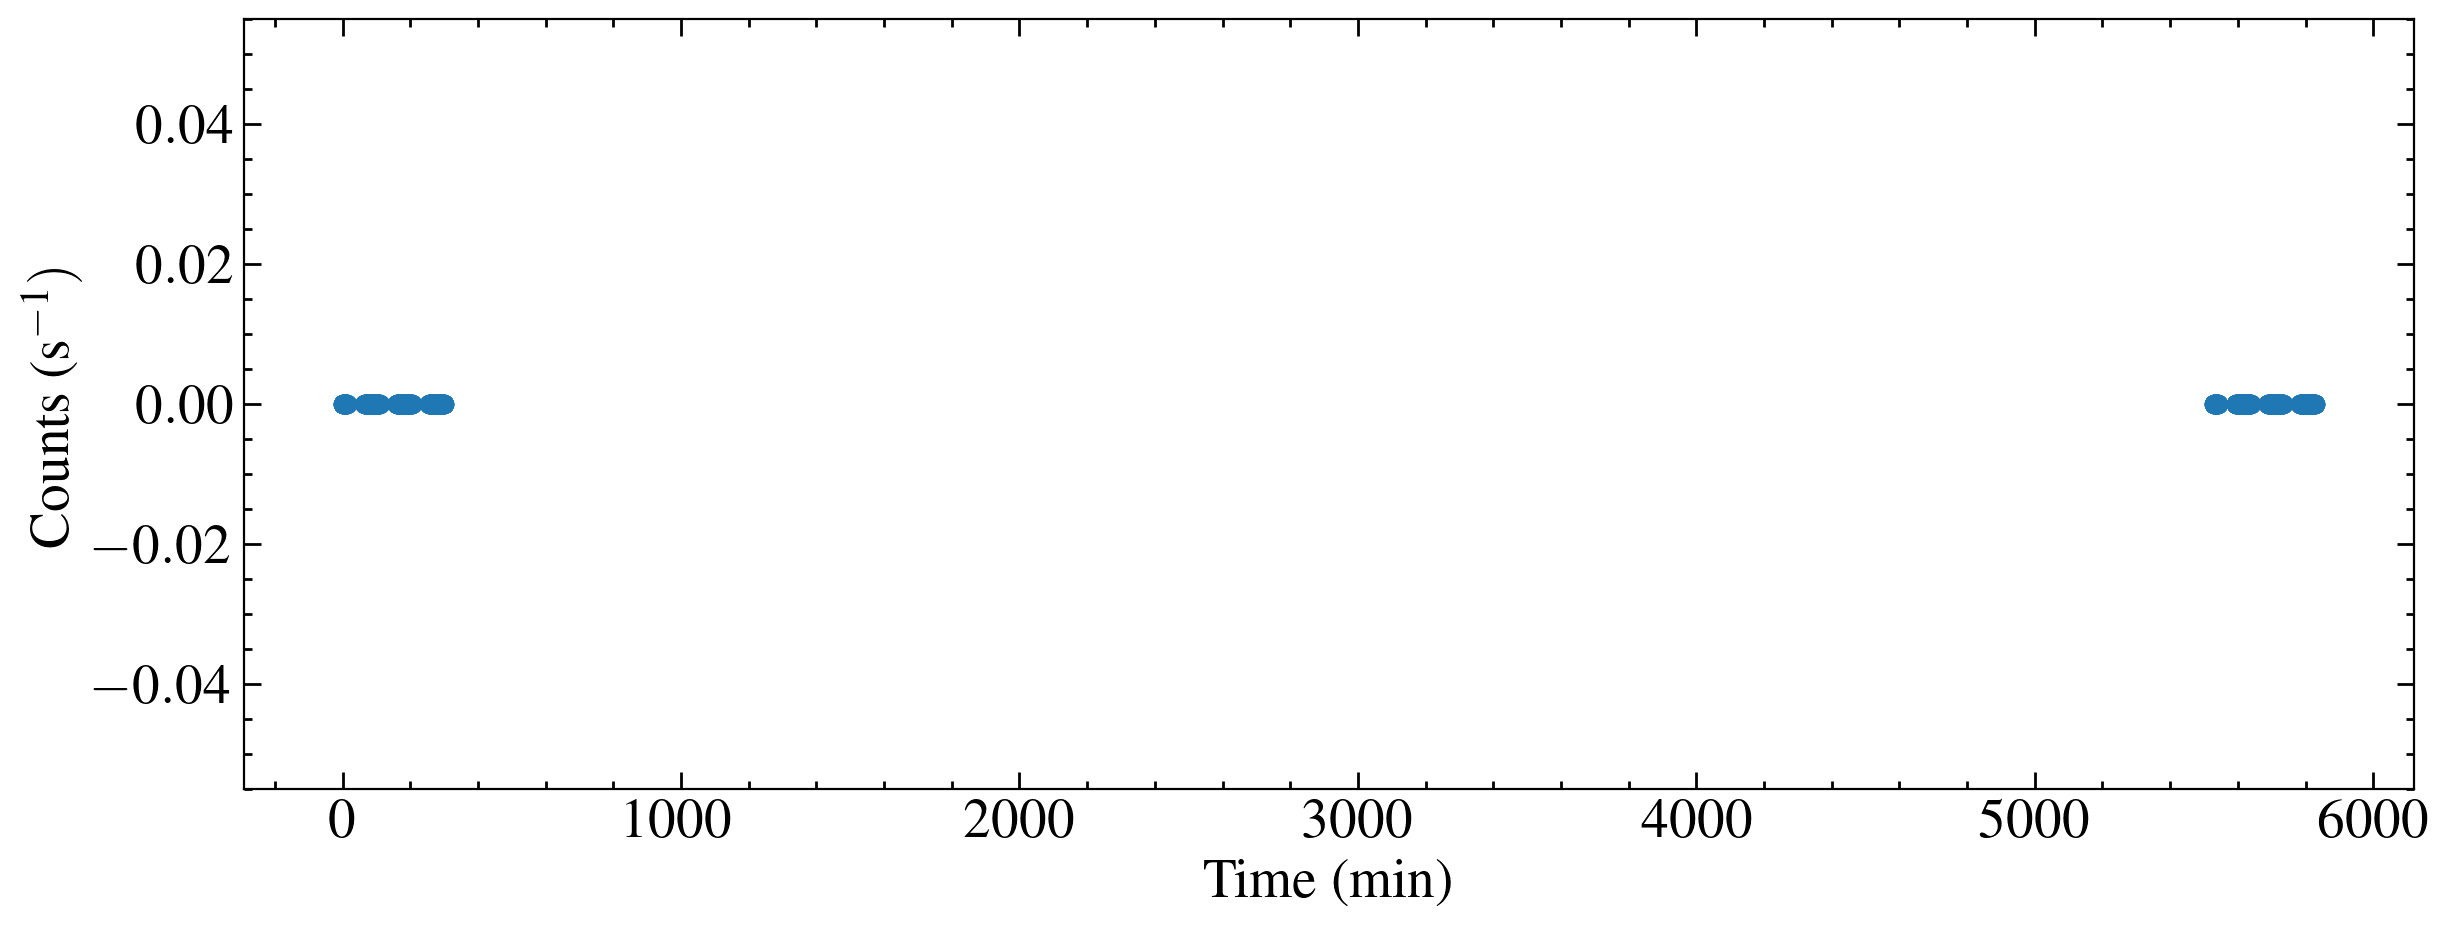

GJ729


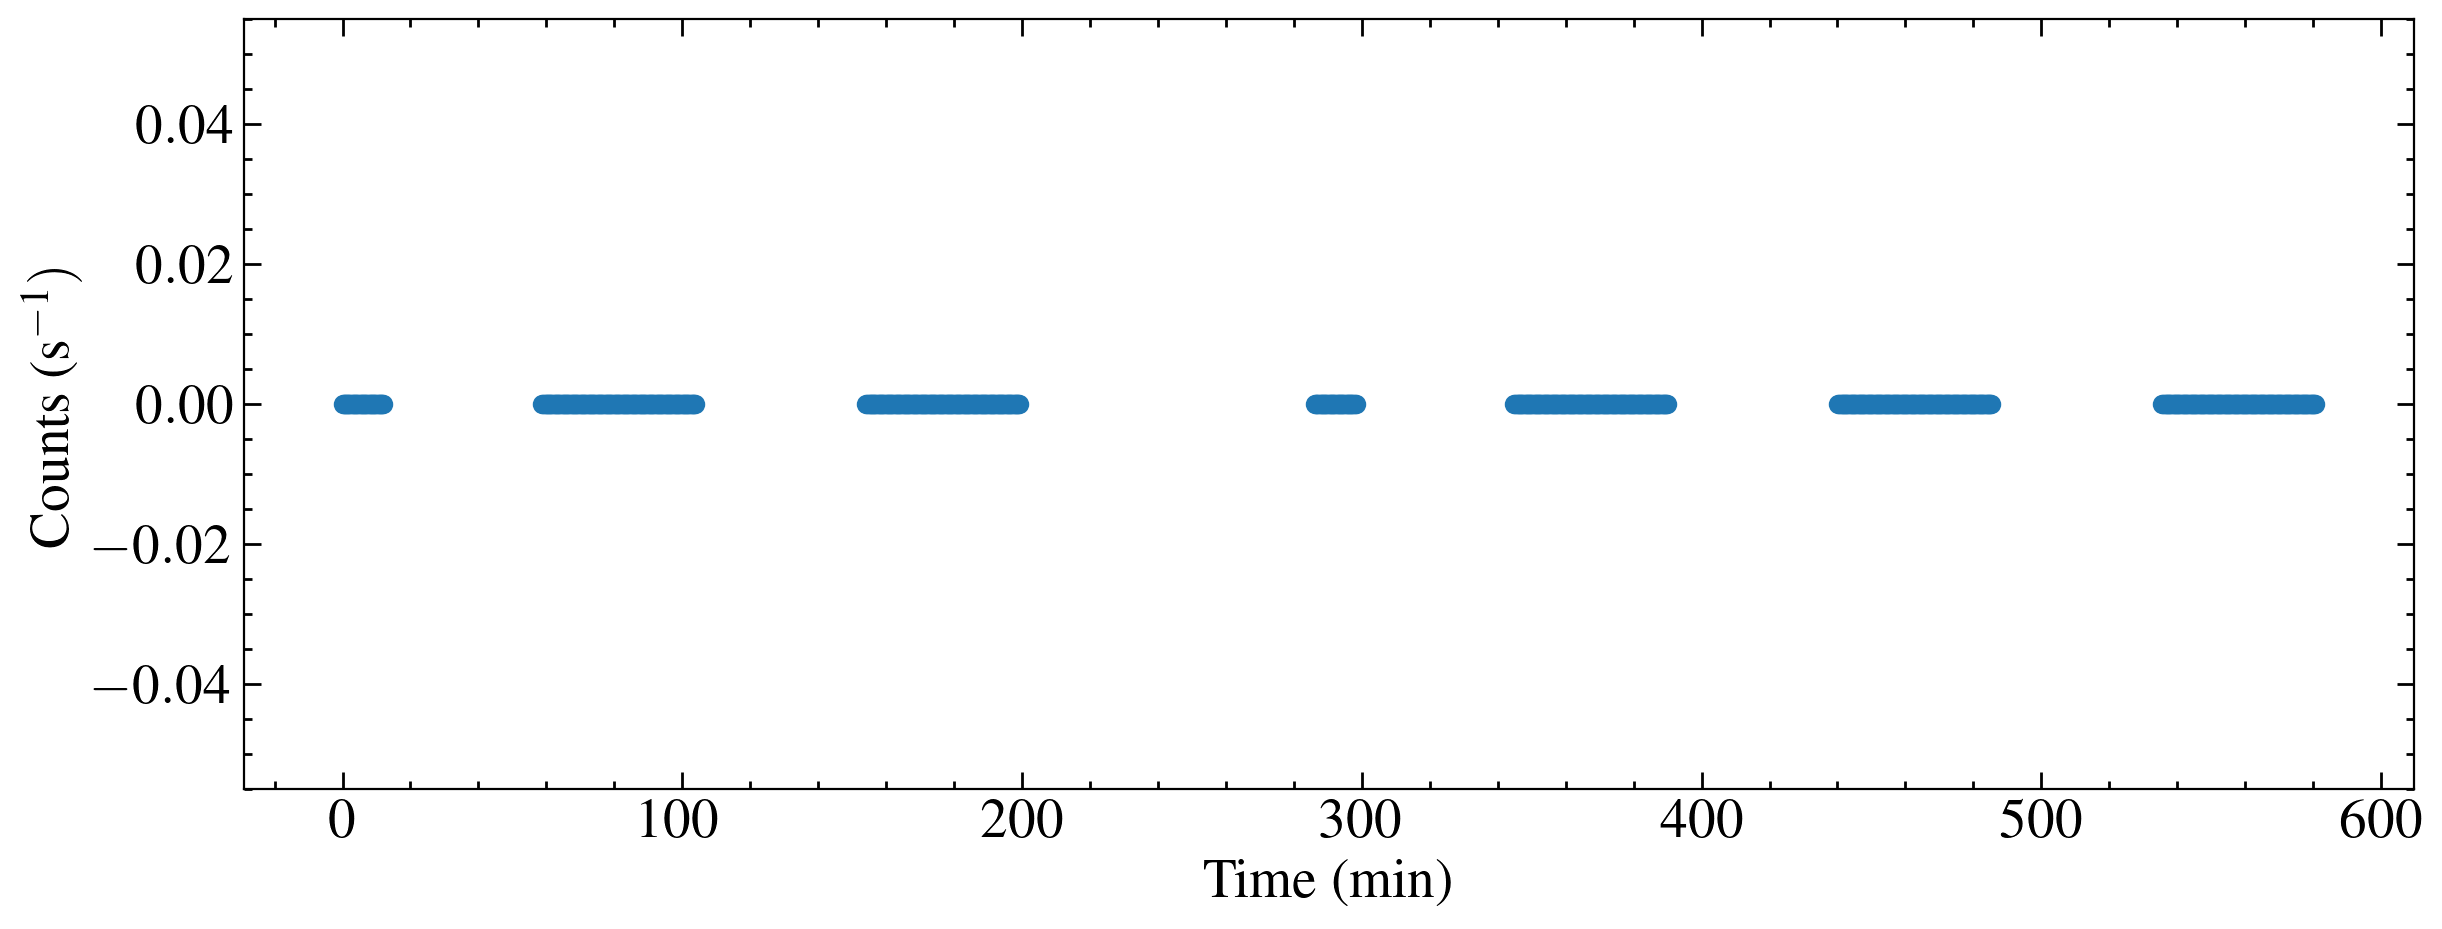

In [136]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

band = [1250, 1700]

for star in stars:
    print(star)
    fig, ax = plt.subplots()
    time = []
    flux = []
    error = []
    for x in new_x1ds:   
        hdul = fits.open(x)
        if hdul[0].header['TARGNAME'] == star: 
            for ext in hdul[1::]:
                data = ext.data[0]
                hdr = ext.header
                ti = (hdr['EXPSTART']+hdr['EXPEND'])/2 #work out the mid-point of the time bin and add it to the time array
                time.append(ti)
                w, f, e , dq = (data['WAVELENGTH'], data['NET'], data['NET_ERROR'], data['DQ'])
                #w, f, e , dq = (data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']) #uncomment this line for flux-calibrated light curves
                w0, w1 = wavelength_edges(w) 
                mask  = (w > band[0]) & (w < band[1]) & (dq == 0)
                w, w0, w1, f, e = w[mask], w0[mask], w1[mask], f[mask], e[mask]
                fi = np.sum(f*(w1-w0))
                # ei = (np.sum(e**2 * (w1-w0)**2))**0.5
                flux.append(fi)
                # error.append(ei)
                ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts 
                error.append(ei) #better approach for these low-signal spectra
                
                
        
        hdul.close()    
    time, flux, error = np.array(time), np.array(flux), np.array(error)
    args = np.argsort(time)
    time, flux, error = time[args], flux[args], error[args]
    t0 = time[0]
    tplot = ((time - t0)*u.d).to(u.min)
    # ax.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
    ax.errorbar(tplot, flux, yerr = error, marker='o', ls='none') #plot the light curve
    ax.set_ylabel('Counts (s$^{-1})$')
    # ax.set_xlabel('Time (MJD-{})'.format(t0))
    ax.set_xlabel('Time (min)')
    plt.show()

    savdat = Table([time*cds.MJD, flux/u.s, error/u.s], names=['MJD', 'COUNTS', 'COUNTS_ERROR'])
    savdat.write('{}{}_{}_{}s_lc.ecsv'.format(savepath, star, grating, t_bin), overwrite=True)
    
        # print(hdul[0].header['ROOTNAME'])
        # for ext in hdul[1::]: #spectra in every extension after the first
        #     data = ext.data[0]
        #     ax.step(data['WAVELENGTH'], data['FLUX'], where='mid', alpha=0.5)
        #     # plt.step(data['WAVELENGTH'], data['ERROR'], alpha =0.5, where='mid')
        #     ax.set_ylim(0, 1.1*max(data['FLUX']))
        #     # plt.show()
        # hdul.close()
        # plt.show()
        